In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
df = pd.read_csv(r"E:\sentiment_AI\ai_research_productivity\data_processed\step4_top_terms_per_dataset.csv")  # columns: file, group, term, count

# Optional cleanup
df["file"] = df["file"].astype(str)
df["group"] = df["group"].astype(str)
df["term"] = df["term"].astype(str).str.strip().str.lower()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0).astype(int)


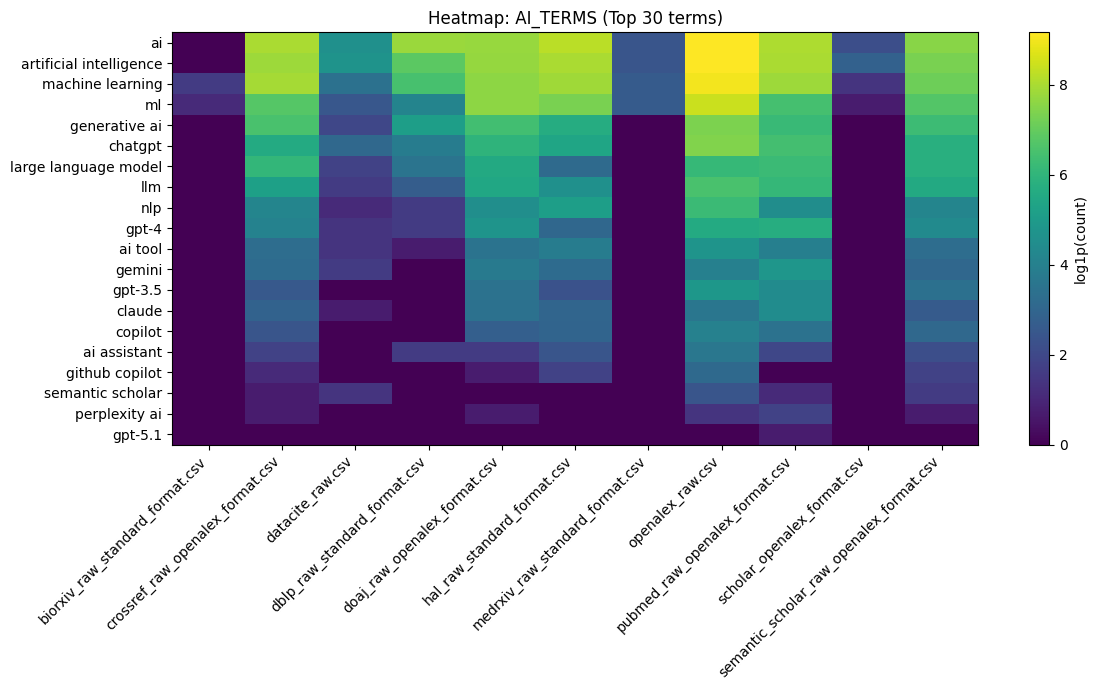

In [2]:
GROUP = "AI_TERMS"     # change: AI_TERMS / PRODUCTIVITY_TERMS / STANCE_TERMS / RISK_TERMS
TOP_N = 30             # top terms by total count
LOG = True             # log scale helps when counts vary a lot

d = df[df["group"] == GROUP].copy()

pivot = (d.pivot_table(index="term", columns="file", values="count", aggfunc="sum", fill_value=0))

# keep top N terms
top_terms = pivot.sum(axis=1).sort_values(ascending=False).head(TOP_N).index
M = pivot.loc[top_terms]

# optional log transform (log1p keeps zeros)
Z = np.log1p(M) if LOG else M

plt.figure(figsize=(12, max(6, 0.35 * len(M))))
plt.imshow(Z.values, aspect="auto")
plt.colorbar(label=("log1p(count)" if LOG else "count"))
plt.yticks(range(len(M.index)), M.index)
plt.xticks(range(len(M.columns)), M.columns, rotation=45, ha="right")
plt.title(f"Heatmap: {GROUP} (Top {TOP_N} terms)")
plt.tight_layout()
plt.show()


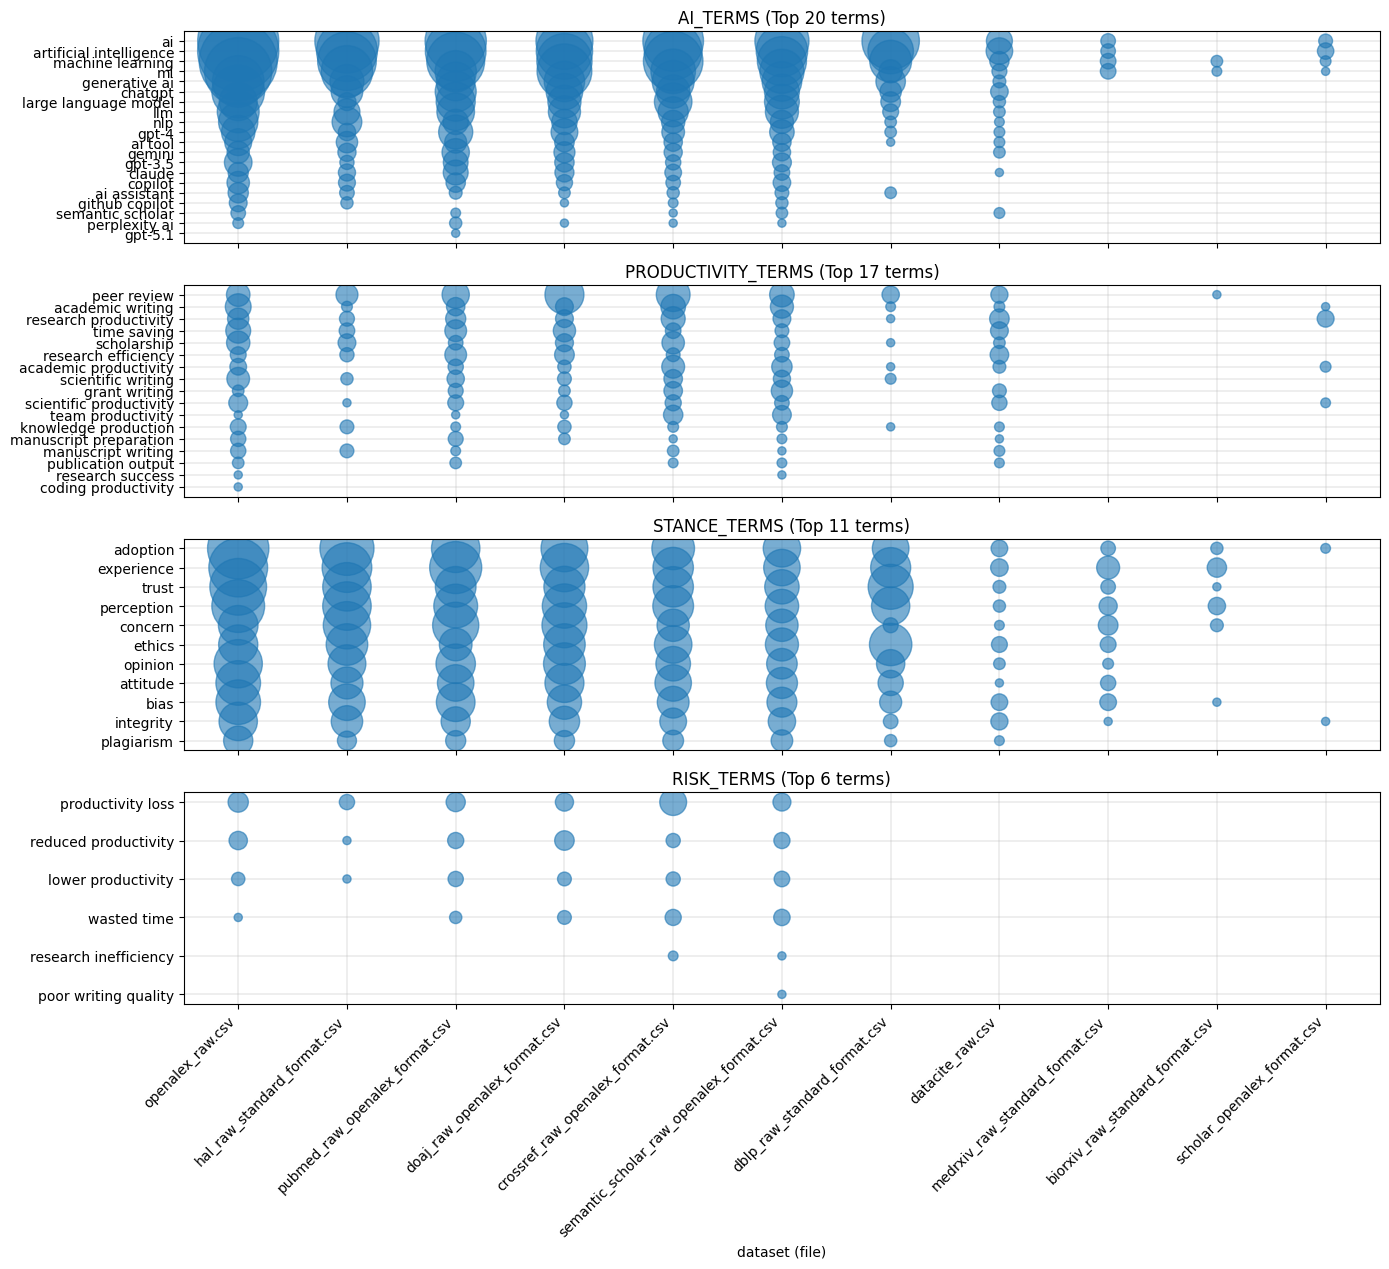

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
df = pd.read_csv(r"E:\sentiment_AI\ai_research_productivity\data_processed\step4_top_terms_per_dataset.csv")  # columns: file, group, term, count

# Clean
df["file"] = df["file"].astype(str)
df["group"] = df["group"].astype(str)
df["term"] = df["term"].astype(str).str.strip().str.lower()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0).astype(int)

# ---------- SETTINGS ----------
GROUP_ORDER = ["AI_TERMS", "PRODUCTIVITY_TERMS", "STANCE_TERMS", "RISK_TERMS"]  # adjust if needed
TOP_TERMS_PER_GROUP = 30   # bubble charts get unreadable if too many terms
INCLUDE_ALL_FILES = True   # user asked all datasets
MIN_COUNT = 1              # drop zero/very rare points
SIZE_SCALE = 35            # increase/decrease bubble sizes
USE_SQRT_SIZE = True       # sqrt makes huge counts less dominant
# -----------------------------

# Keep only nonzero
d = df[df["count"] >= MIN_COUNT].copy()

# All files (datasets) shown on x-axis
if INCLUDE_ALL_FILES:
    file_order = d.groupby("file")["count"].sum().sort_values(ascending=False).index.tolist()
else:
    file_order = d.groupby("file")["count"].sum().sort_values(ascending=False).head(10).index.tolist()

# Prepare figure (one figure, subplots for each group)
groups_present = [g for g in GROUP_ORDER if g in set(d["group"])]
n = len(groups_present)
if n == 0:
    raise ValueError("No matching groups found in the data. Check GROUP_ORDER or df['group'].")

fig_h = max(10, 3.2 * n)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(max(14, 0.85 * len(file_order)), fig_h), sharex=True)
if n == 1:
    axes = [axes]

for ax, grp in zip(axes, groups_present):
    dg = d[d["group"] == grp].copy()

    # Select top terms for this group (across ALL files)
    top_terms = (
        dg.groupby("term")["count"].sum()
        .sort_values(ascending=False)
        .head(TOP_TERMS_PER_GROUP)
        .index.tolist()
    )

    dg = dg[dg["term"].isin(top_terms) & dg["file"].isin(file_order)]
    dg = dg.groupby(["term", "file"], as_index=False)["count"].sum()

    # Order y terms by total count (descending)
    term_order = (
        dg.groupby("term")["count"].sum()
        .sort_values(ascending=False)
        .index.tolist()
    )

    # Map to coordinates
    x_map = {f: i for i, f in enumerate(file_order)}
    y_map = {t: i for i, t in enumerate(term_order)}
    dg["x"] = dg["file"].map(x_map)
    dg["y"] = dg["term"].map(y_map)

    # Bubble sizes
    vals = dg["count"].values.astype(float)
    sizes = np.sqrt(vals) * SIZE_SCALE if USE_SQRT_SIZE else vals * (SIZE_SCALE / max(vals.max(), 1.0))

    ax.scatter(dg["x"], dg["y"], s=sizes, alpha=0.6)

    # Y labels
    ax.set_yticks(range(len(term_order)))
    ax.set_yticklabels(term_order)
    ax.invert_yaxis()
    ax.set_title(f"{grp} (Top {len(term_order)} terms)")

    # Light grid for readability
    ax.set_axisbelow(True)
    ax.grid(True, which="major", axis="both", linestyle="-", linewidth=0.3)

# X labels (all datasets)
axes[-1].set_xticks(range(len(file_order)))
axes[-1].set_xticklabels(file_order, rotation=45, ha="right")
axes[-1].set_xlabel("dataset (file)")

plt.tight_layout()
plt.show()


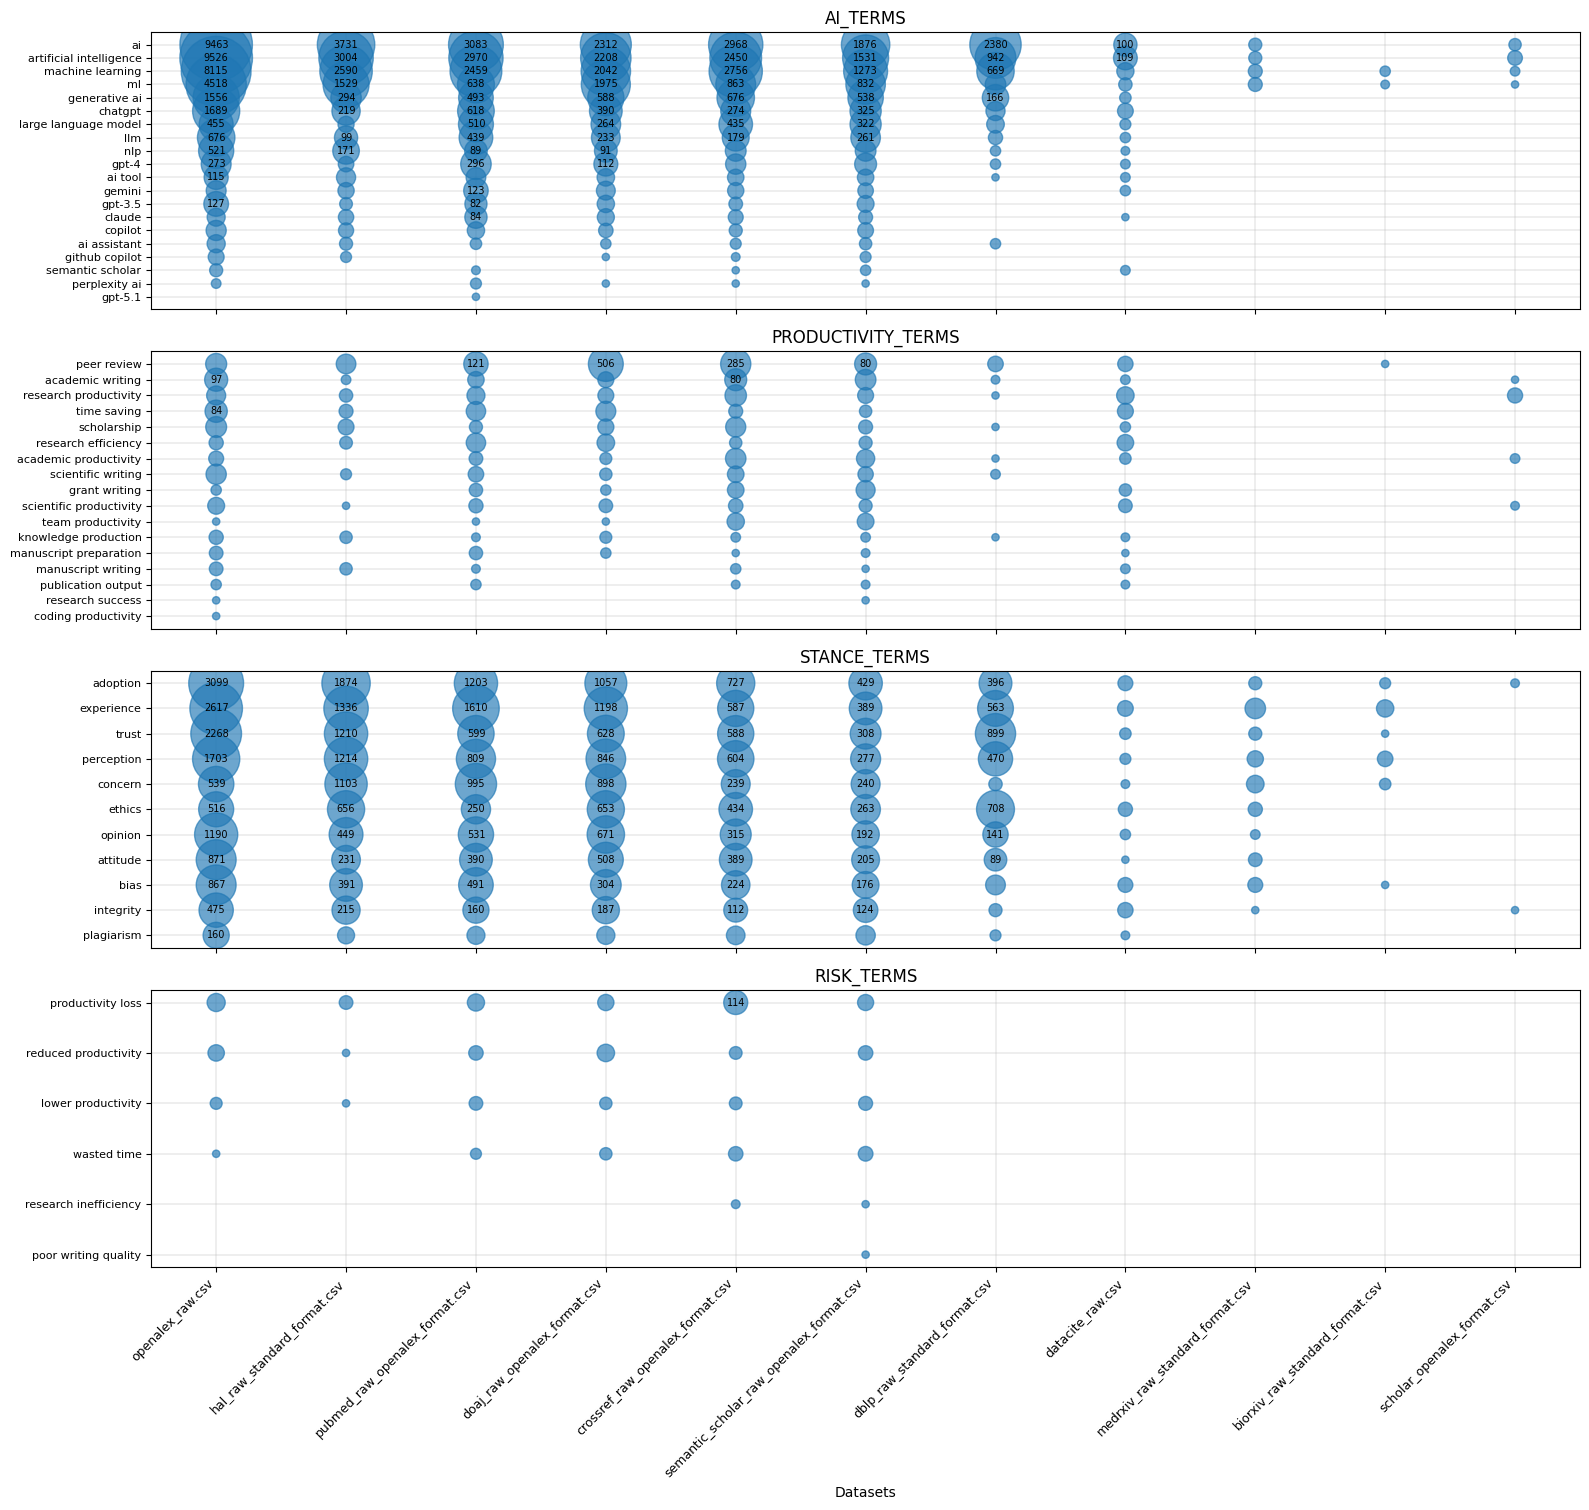

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"E:\sentiment_AI\ai_research_productivity\data_processed\step4_top_terms_per_dataset.csv")  # file, group, term, count

# Clean
df["file"] = df["file"].astype(str)
df["group"] = df["group"].astype(str)
df["term"] = df["term"].str.strip().str.lower()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0).astype(int)

# ---------------- SETTINGS ----------------
GROUP_ORDER = ["AI_TERMS", "PRODUCTIVITY_TERMS", "STANCE_TERMS", "RISK_TERMS"]
TOP_TERMS_PER_GROUP = 25        # reduce to avoid y overlap
SIZE_SCALE = 28                 # bubble size control
LABEL_THRESHOLD = 80            # only show numbers if count >= this
YTICK_FONTSIZE = 8
# -----------------------------------------

# All datasets on x-axis
file_order = (
    df.groupby("file")["count"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

groups_present = [g for g in GROUP_ORDER if g in df["group"].unique()]
n = len(groups_present)

fig, axes = plt.subplots(
    nrows=n,
    ncols=1,
    figsize=(max(16, 0.9 * len(file_order)), 3.8 * n),
    sharex=True
)

if n == 1:
    axes = [axes]

for ax, grp in zip(axes, groups_present):
    dg = df[df["group"] == grp].copy()

    # Top terms per group
    top_terms = (
        dg.groupby("term")["count"]
        .sum()
        .sort_values(ascending=False)
        .head(TOP_TERMS_PER_GROUP)
        .index
    )

    dg = dg[dg["term"].isin(top_terms)]
    dg = dg.groupby(["term", "file"], as_index=False)["count"].sum()

    # Order terms by total frequency
    term_order = (
        dg.groupby("term")["count"]
        .sum()
        .sort_values(ascending=False)
        .index.tolist()
    )

    x_map = {f: i for i, f in enumerate(file_order)}
    y_map = {t: i for i, t in enumerate(term_order)}

    dg["x"] = dg["file"].map(x_map)
    dg["y"] = dg["term"].map(y_map)

    sizes = np.sqrt(dg["count"]) * SIZE_SCALE

    ax.scatter(dg["x"], dg["y"], s=sizes, alpha=0.65)

    # ---- Add numbers inside bubbles (filtered) ----
    for _, r in dg.iterrows():
        if r["count"] >= LABEL_THRESHOLD:
            ax.text(
                r["x"],
                r["y"],
                str(r["count"]),
                ha="center",
                va="center",
                fontsize=7,
                color="black"
            )

    # Y-axis formatting
    ax.set_yticks(range(len(term_order)))
    ax.set_yticklabels(term_order, fontsize=YTICK_FONTSIZE)
    ax.invert_yaxis()
    ax.set_title(f"{grp}", fontsize=12, pad=6)

    ax.grid(True, axis="both", linewidth=0.3)
    ax.set_axisbelow(True)

# X-axis (datasets)
axes[-1].set_xticks(range(len(file_order)))
axes[-1].set_xticklabels(file_order, rotation=45, ha="right", fontsize=9)
axes[-1].set_xlabel("Datasets")

plt.tight_layout()
plt.show()


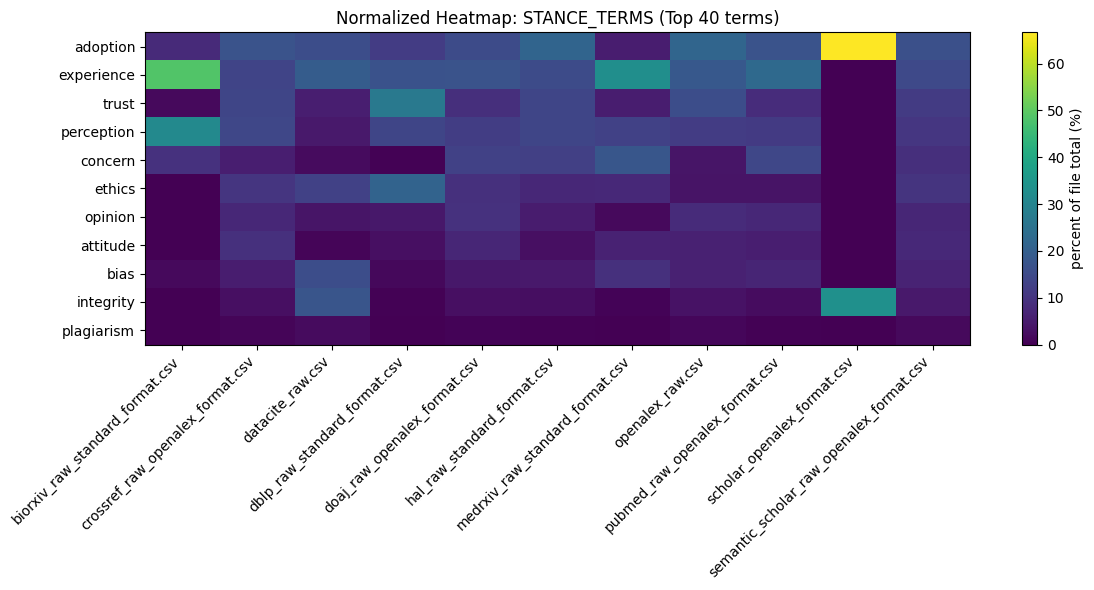

In [4]:
GROUP = "STANCE_TERMS"
TOP_N = 40

d = df[df["group"] == GROUP].copy()
pivot = d.pivot_table(index="term", columns="file", values="count", aggfunc="sum", fill_value=0)

top_terms = pivot.sum(axis=1).sort_values(ascending=False).head(TOP_N).index
M = pivot.loc[top_terms]

# column-wise percentage
col_sums = M.sum(axis=0).replace(0, np.nan)
P = (M / col_sums) * 100
P = P.fillna(0)

plt.figure(figsize=(12, max(6, 0.35 * len(P))))
plt.imshow(P.values, aspect="auto")
plt.colorbar(label="percent of file total (%)")
plt.yticks(range(len(P.index)), P.index)
plt.xticks(range(len(P.columns)), P.columns, rotation=45, ha="right")
plt.title(f"Normalized Heatmap: {GROUP} (Top {TOP_N} terms)")
plt.tight_layout()
plt.show()


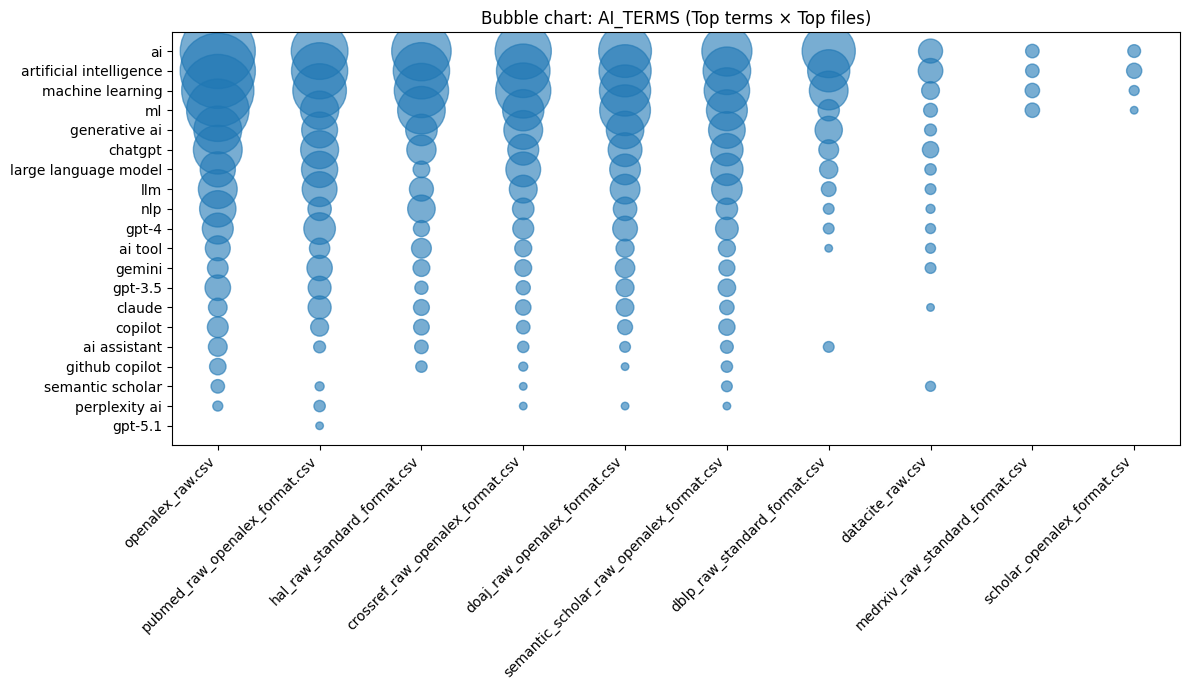

In [5]:
GROUP = "AI_TERMS"
TOP_N_TERMS = 25
TOP_N_FILES = 10

d = df[df["group"] == GROUP].copy()

# top terms and files
top_terms = d.groupby("term")["count"].sum().sort_values(ascending=False).head(TOP_N_TERMS).index
top_files = d.groupby("file")["count"].sum().sort_values(ascending=False).head(TOP_N_FILES).index

b = d[d["term"].isin(top_terms) & d["file"].isin(top_files)]
b = b.groupby(["term", "file"], as_index=False)["count"].sum()

# map to numeric positions
term_order = list(top_terms)
file_order = list(top_files)
b["x"] = b["file"].map({f:i for i,f in enumerate(file_order)})
b["y"] = b["term"].map({t:i for i,t in enumerate(term_order)})

plt.figure(figsize=(12, max(6, 0.35 * len(term_order))))
sizes = np.sqrt(b["count"].values) * 30  # adjust 30 if too small/large
plt.scatter(b["x"], b["y"], s=sizes, alpha=0.6)

plt.xticks(range(len(file_order)), file_order, rotation=45, ha="right")
plt.yticks(range(len(term_order)), term_order)
plt.gca().invert_yaxis()
plt.title(f"Bubble chart: {GROUP} (Top terms × Top files)")
plt.tight_layout()
plt.show()


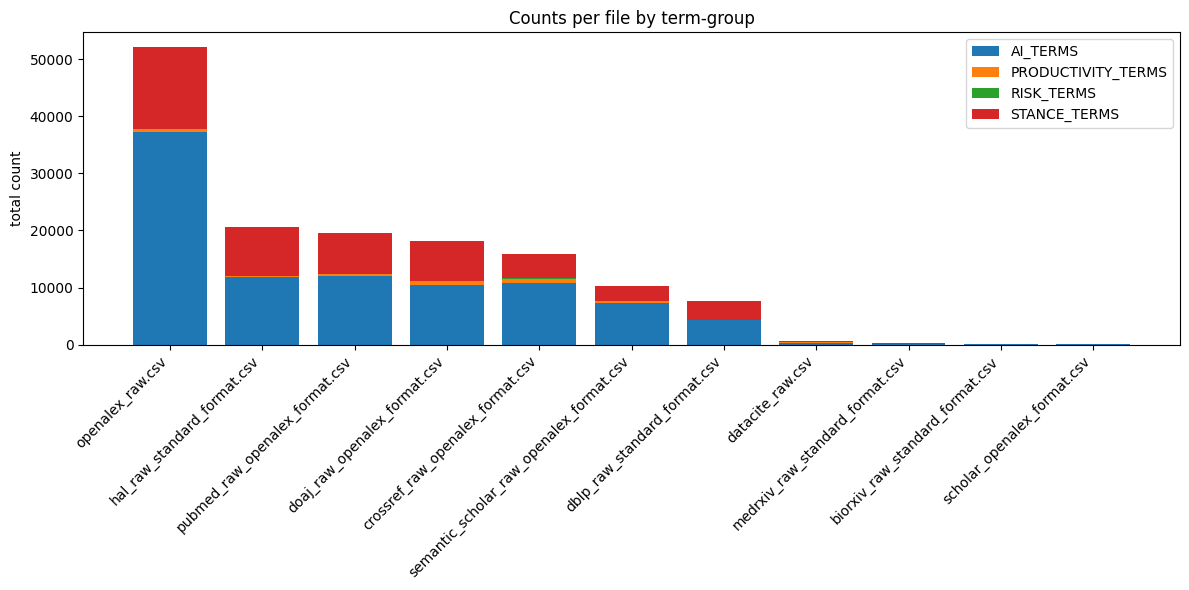

In [6]:
# Compare how much each dataset mentions each category overall
g = (df.groupby(["file", "group"], as_index=False)["count"].sum())

pivot = g.pivot_table(index="file", columns="group", values="count", aggfunc="sum", fill_value=0)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(pivot))
x = np.arange(len(pivot.index))

for col in pivot.columns:
    plt.bar(x, pivot[col].values, bottom=bottom, label=col)
    bottom += pivot[col].values

plt.xticks(x, pivot.index, rotation=45, ha="right")
plt.ylabel("total count")
plt.title("Counts per file by term-group")
plt.legend()
plt.tight_layout()
plt.show()


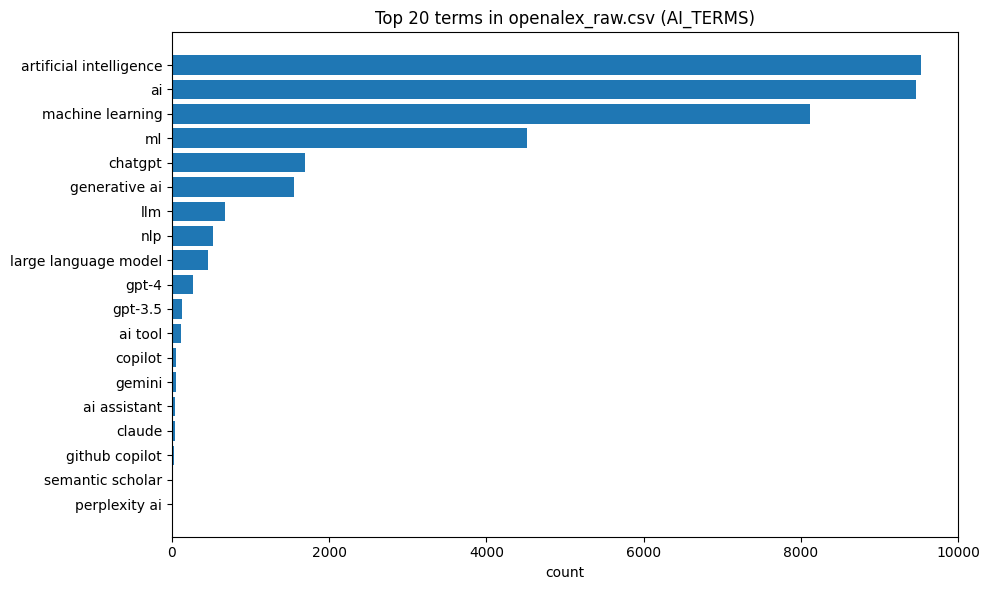

In [7]:
FILE = "openalex_raw.csv"
GROUP = "AI_TERMS"
TOP_N = 20

d = df[(df["file"] == FILE) & (df["group"] == GROUP)]
s = d.groupby("term")["count"].sum().sort_values(ascending=False).head(TOP_N)

plt.figure(figsize=(10, 6))
plt.barh(s.index[::-1], s.values[::-1])
plt.xlabel("count")
plt.title(f"Top {TOP_N} terms in {FILE} ({GROUP})")
plt.tight_layout()
plt.show()


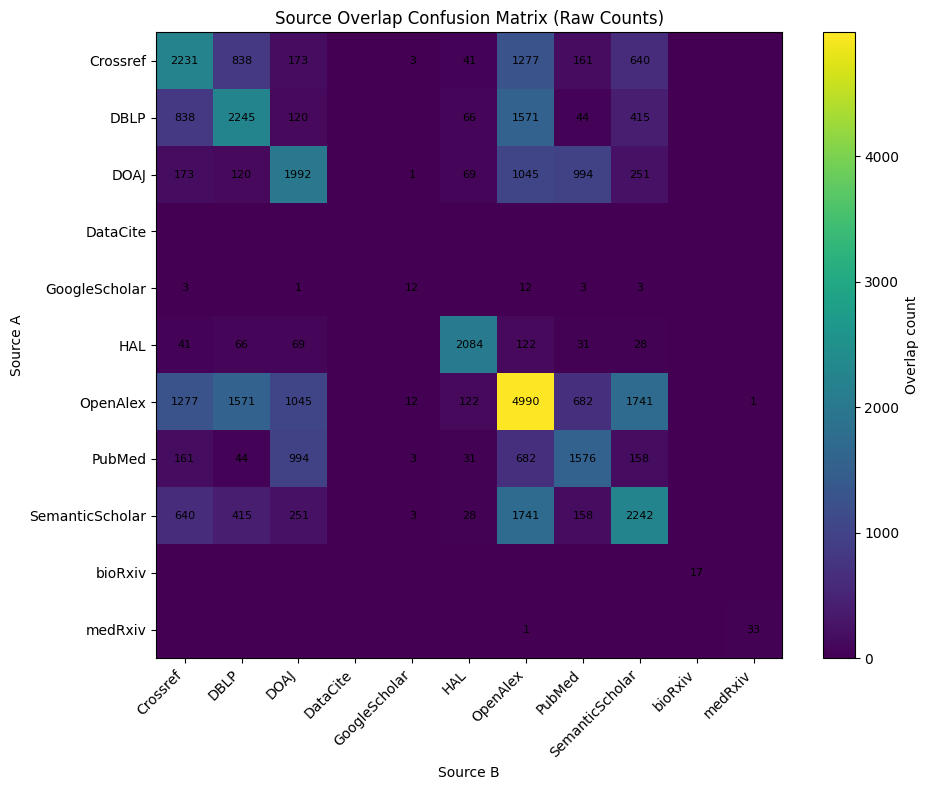

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load matrix
cm = pd.read_csv(r"E:\sentiment_AI\ai_research_productivity\data_processed\step5_source_overlap_matrix.csv", index_col=0)

plt.figure(figsize=(10, 8))
plt.imshow(cm.values)

plt.colorbar(label="Overlap count")

plt.xticks(range(len(cm.columns)), cm.columns, rotation=45, ha="right")
plt.yticks(range(len(cm.index)), cm.index)

# Add numbers inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm.iat[i, j]
        if val > 0:
            plt.text(j, i, str(val), ha="center", va="center", fontsize=8)

plt.title("Source Overlap Confusion Matrix (Raw Counts)")
plt.xlabel("Source B")
plt.ylabel("Source A")
plt.tight_layout()
plt.show()


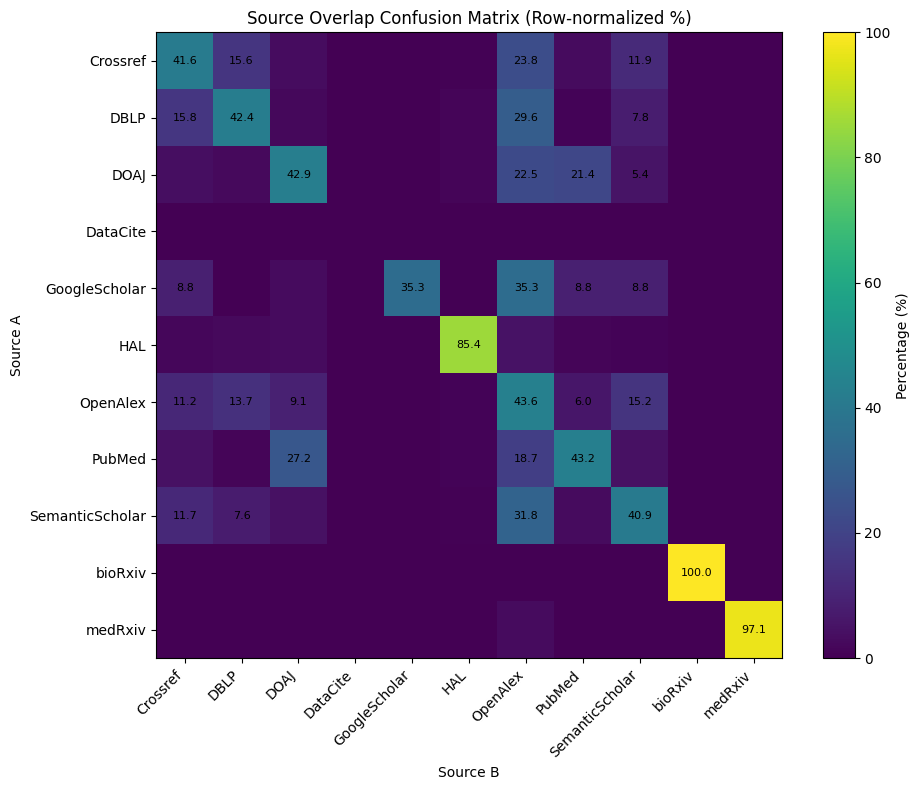

In [11]:
cm_norm = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0) * 100
cm_norm = cm_norm.fillna(0)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm.values)

plt.colorbar(label="Percentage (%)")

plt.xticks(range(len(cm.columns)), cm.columns, rotation=45, ha="right")
plt.yticks(range(len(cm.index)), cm.index)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm.iat[i, j]
        if val >= 5:  # avoid clutter
            plt.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=8)

plt.title("Source Overlap Confusion Matrix (Row-normalized %)")
plt.xlabel("Source B")
plt.ylabel("Source A")
plt.tight_layout()
plt.show()


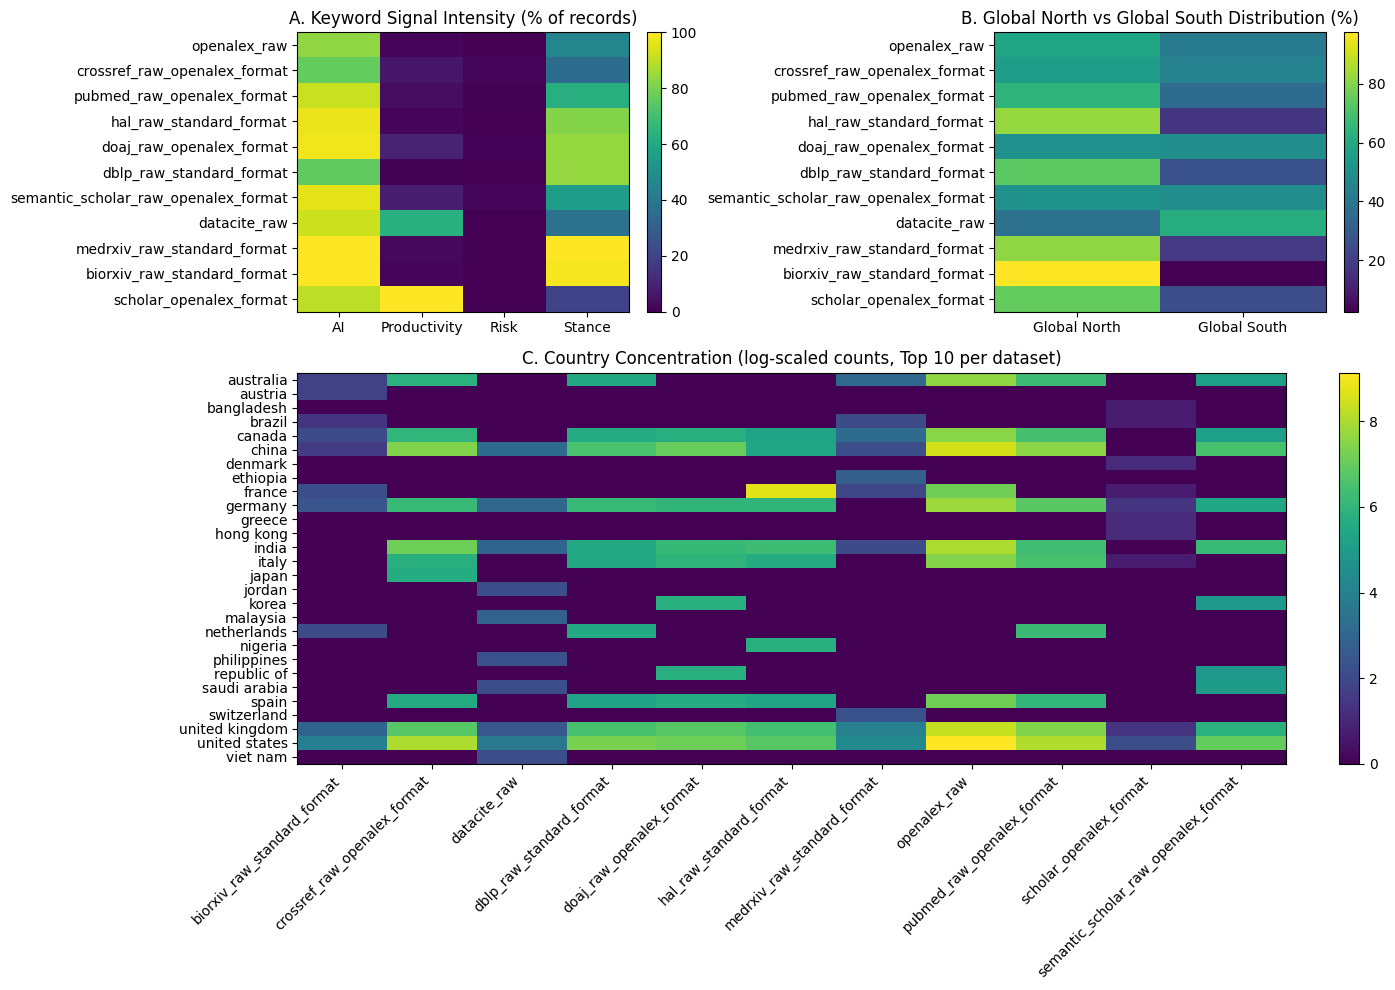

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------ LOAD DATA ------------------
kw = pd.read_csv(
    r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_keyword_hit_counts.csv"
)

qc = pd.read_csv(
    r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_qc_counts.csv"
)

ct = pd.read_csv(
    r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_top_countries.csv"
)

# Ensure consistent dataset order
dataset_order = kw["dataset"].tolist()

# ------------------ PANEL A: KEYWORD SIGNALS ------------------
kw_cols = ["AI_hit", "Productivity_hit", "Risk_hit", "Stance_hit"]
kw_norm = kw[kw_cols].div(kw["rows_usable"], axis=0) * 100

# ------------------ PANEL B: GLOBAL NORTH / SOUTH ------------------
qc_gn_gs = qc[["Global_North", "Global_South"]]
qc_norm = qc_gn_gs.div(qc_gn_gs.sum(axis=1), axis=0) * 100

# ------------------ PANEL C: TOP COUNTRIES ------------------
TOP_K = 10
ct_top = (
    ct.groupby(["dataset", "country"])["count"]
    .sum()
    .groupby(level=0, group_keys=False)
    .nlargest(TOP_K)
    .reset_index()
)

heat = ct_top.pivot(
    index="country", columns="dataset", values="count"
).fillna(0)

heat = np.log1p(heat)  # log-scale for stability

# ------------------ FIGURE ------------------
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.4])

# ---------- Panel A ----------
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(kw_norm.values, aspect="auto")
ax1.set_xticks(range(len(kw_cols)))
ax1.set_xticklabels(["AI", "Productivity", "Risk", "Stance"])
ax1.set_yticks(range(len(dataset_order)))
ax1.set_yticklabels(dataset_order)
ax1.set_title("A. Keyword Signal Intensity (% of records)")
plt.colorbar(im1, ax=ax1, fraction=0.046)

# ---------- Panel B ----------
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(qc_norm.values, aspect="auto")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["Global North", "Global South"])
ax2.set_yticks(range(len(dataset_order)))
ax2.set_yticklabels(dataset_order)
ax2.set_title("B. Global North vs Global South Distribution (%)")
plt.colorbar(im2, ax=ax2, fraction=0.046)

# ---------- Panel C ----------
ax3 = fig.add_subplot(gs[1, :])
im3 = ax3.imshow(heat.values, aspect="auto")
ax3.set_xticks(range(len(heat.columns)))
ax3.set_xticklabels(heat.columns, rotation=45, ha="right")
ax3.set_yticks(range(len(heat.index)))
ax3.set_yticklabels(heat.index)
ax3.set_title("C. Country Concentration (log-scaled counts, Top 10 per dataset)")
plt.colorbar(im3, ax=ax3, fraction=0.02)

plt.tight_layout()
plt.show()


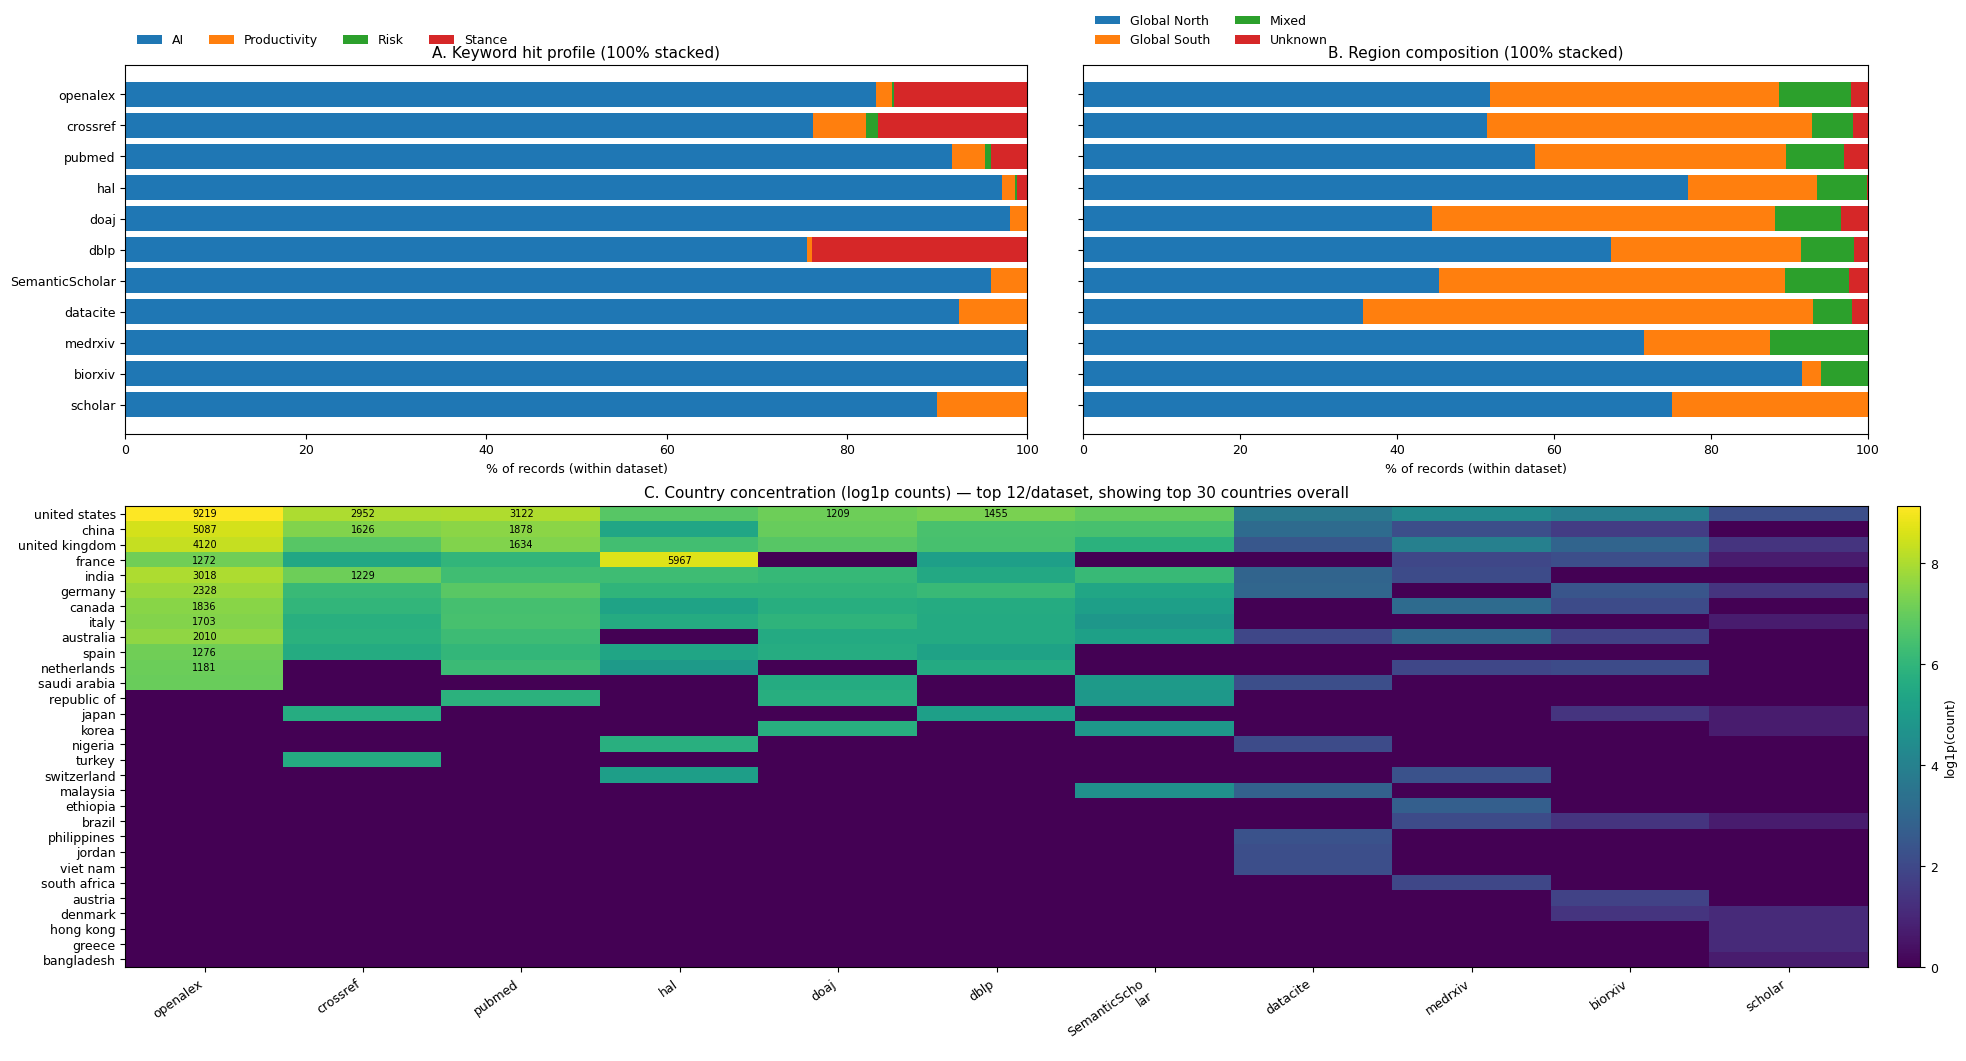

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ------------------ PATHS ------------------
KW_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_keyword_hit_counts.csv"
QC_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_qc_counts.csv"
CT_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_top_countries.csv"

# ------------------ LOAD ------------------
kw = pd.read_csv(KW_PATH)
qc = pd.read_csv(QC_PATH)
ct = pd.read_csv(CT_PATH)

# ------------------ CLEAN + ALIGN ------------------
def short_name(x: str) -> str:
    x = str(x)
    x = x.replace("_raw_openalex_format", "")
    x = x.replace("_raw_standard_format", "")
    x = x.replace("_raw", "")
    x = x.replace("_openalex_format", "")
    x = x.replace("_standard_format", "")
    x = x.replace("semantic_scholar", "SemanticScholar")
    x = x.replace("google", "Google")
    return x

kw["dataset"] = kw["dataset"].map(short_name)
qc["dataset"] = qc["dataset"].map(short_name)
ct["dataset"] = ct["dataset"].map(short_name)

# keep only datasets present in kw (master order)
dataset_order = kw["dataset"].tolist()

qc = qc.set_index("dataset").reindex(dataset_order).reset_index()
# ct stays long-form; filter to datasets we have
ct = ct[ct["dataset"].isin(dataset_order)].copy()

# ------------------ PANEL A: KEYWORD SIGNAL (100% STACKED) ------------------
kw_cols = ["AI_hit", "Productivity_hit", "Risk_hit", "Stance_hit"]
A = kw[["dataset", "rows_usable"] + kw_cols].copy()
for c in kw_cols:
    A[c] = pd.to_numeric(A[c], errors="coerce").fillna(0)

A_pct = A[kw_cols].div(A["rows_usable"].replace(0, np.nan), axis=0).fillna(0) * 100

# ------------------ PANEL B: GLOBAL NORTH/SOUTH (100% STACKED) ------------------
B = qc[["dataset", "Global_North", "Global_South", "Mixed", "Unknown_region"]].copy()
for c in ["Global_North", "Global_South", "Mixed", "Unknown_region"]:
    B[c] = pd.to_numeric(B[c], errors="coerce").fillna(0)

B_total = B[["Global_North", "Global_South", "Mixed", "Unknown_region"]].sum(axis=1).replace(0, np.nan)
B_pct = B[["Global_North", "Global_South", "Mixed", "Unknown_region"]].div(B_total, axis=0).fillna(0) * 100

# ------------------ PANEL C: TOP COUNTRIES HEATMAP (log1p counts) ------------------
TOP_K = 12  # top countries per dataset (controls height)
ct["count"] = pd.to_numeric(ct["count"], errors="coerce").fillna(0)
ct["country"] = ct["country"].astype(str).str.strip()

ct_top = (
    ct.groupby(["dataset", "country"], as_index=False)["count"].sum()
    .sort_values(["dataset", "count"], ascending=[True, False])
    .groupby("dataset", as_index=False)
    .head(TOP_K)
)

heat = ct_top.pivot(index="country", columns="dataset", values="count").fillna(0)

# reorder columns to match datasets
heat = heat.reindex(columns=dataset_order)

# keep most informative rows (countries) overall to avoid huge y-axis
MAX_COUNTRIES = 35
row_order = heat.sum(axis=1).sort_values(ascending=False).head(MAX_COUNTRIES).index
heat = heat.loc[row_order]

H = np.log1p(heat.values)

# ------------------ FIGURE: PERFECT WIDTH + NO OVERLAP ------------------
# dynamic figure size: wider if many datasets
W = max(14, 1.05 * len(dataset_order) + 8)
HFIG = 10.5

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 9,
})

fig = plt.figure(figsize=(W, HFIG), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 1.25], width_ratios=[1.15, 1])

# ---------- Panel A (top-left): 100% stacked horizontal bars ----------
ax1 = fig.add_subplot(gs[0, 0])
y = np.arange(len(dataset_order))
left = np.zeros(len(dataset_order))

labels_A = ["AI", "Productivity", "Risk", "Stance"]
for i, col in enumerate(kw_cols):
    ax1.barh(y, A_pct[col].values, left=left, label=labels_A[i])
    left += A_pct[col].values

ax1.set_yticks(y)
ax1.set_yticklabels(dataset_order)
ax1.invert_yaxis()
ax1.set_xlim(0, 100)
ax1.set_xlabel("% of records (within dataset)")
ax1.set_title("A. Keyword hit profile (100% stacked)")
ax1.legend(ncols=4, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", frameon=False)

# ---------- Panel B (top-right): GN/GS/Mixed/Unknown 100% stacked ----------
ax2 = fig.add_subplot(gs[0, 1])
left = np.zeros(len(dataset_order))
labels_B = ["Global North", "Global South", "Mixed", "Unknown"]
cols_B = ["Global_North", "Global_South", "Mixed", "Unknown_region"]

for i, col in enumerate(cols_B):
    ax2.barh(y, B_pct[col].values, left=left, label=labels_B[i])
    left += B_pct[col].values

ax2.set_yticks(y)
ax2.set_yticklabels([])  # avoid duplicate labels; Panel A already shows them
ax2.invert_yaxis()
ax2.set_xlim(0, 100)
ax2.set_xlabel("% of records (within dataset)")
ax2.set_title("B. Region composition (100% stacked)")
ax2.legend(ncols=2, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", frameon=False)

# ---------- Panel C (bottom full-width): Countries heatmap ----------
ax3 = fig.add_subplot(gs[1, :])
im = ax3.imshow(H, aspect="auto")

# x labels: wrap if needed, rotate to avoid overlap
xlabels = [textwrap.fill(x, width=12) for x in heat.columns.tolist()]
ax3.set_xticks(np.arange(len(xlabels)))
ax3.set_xticklabels(xlabels, rotation=35, ha="right")

ax3.set_yticks(np.arange(len(heat.index)))
ax3.set_yticklabels(heat.index.tolist())

ax3.set_title(f"C. Country concentration (log1p counts) — top {TOP_K}/dataset, showing top {len(heat.index)} countries overall")
cbar = fig.colorbar(im, ax=ax3, fraction=0.02, pad=0.01)
cbar.set_label("log1p(count)")

# annotate only relatively strong cells to keep clean
vals = heat.values
thr = np.quantile(vals[vals > 0], 0.85) if (vals > 0).any() else np.inf
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        v = vals[i, j]
        if v >= thr:
            ax3.text(j, i, str(int(v)), ha="center", va="center", fontsize=7)

# Optional: save (high-res, publication ready)
# fig.savefig("publication_figure.png", dpi=300, bbox_inches="tight")
# fig.savefig("publication_figure.pdf", dpi=300, bbox_inches="tight")

plt.show()


In [38]:
# One interactive, publication-style figure (single HTML) with:
# - Bubble plot (keyword intensity vs dataset)
# - Heatmap (Top countries x datasets)
# - Sunburst (Dataset -> Region -> Discipline)
# - Sankey (Dataset -> Region) and (Region -> Discipline)
#
# Requires: pip install plotly pandas numpy

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

KW_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_keyword_hit_counts.csv"
QC_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_qc_counts.csv"
CT_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_top_countries.csv"

kw = pd.read_csv(KW_PATH)
qc = pd.read_csv(QC_PATH)
ct = pd.read_csv(CT_PATH)

# ---------------- Helpers ----------------
def short_name(x: str) -> str:
    x = str(x)
    x = x.replace("_raw_openalex_format", "")
    x = x.replace("_raw_standard_format", "")
    x = x.replace("_raw", "")
    x = x.replace("_openalex_format", "")
    x = x.replace("_standard_format", "")
    x = x.replace("semantic_scholar", "SemanticScholar")
    x = x.replace("scholar", "GoogleScholar")
    return x

kw["dataset"] = kw["dataset"].map(short_name)
qc["dataset"] = qc["dataset"].map(short_name)
ct["dataset"] = ct["dataset"].map(short_name)

# Keep a consistent dataset order (largest first)
dataset_order = (
    kw.set_index("dataset")["rows_usable"]
      .sort_values(ascending=False)
      .index.tolist()
)

# ---------------- 1) Bubble plot data (keywords) ----------------
kw_cols = ["AI_hit", "Productivity_hit", "Risk_hit", "Stance_hit"]
kw2 = kw[["dataset", "rows_usable"] + kw_cols].copy()
for c in kw_cols:
    kw2[c] = pd.to_numeric(kw2[c], errors="coerce").fillna(0)

# Percent of rows usable
kw_pct = kw2.copy()
for c in kw_cols:
    kw_pct[c] = (kw_pct[c] / kw_pct["rows_usable"].replace(0, np.nan)) * 100
kw_pct = kw_pct.fillna(0)

bubble_long = kw_pct.melt(
    id_vars=["dataset", "rows_usable"],
    value_vars=kw_cols,
    var_name="metric",
    value_name="pct"
)

metric_order = ["AI_hit", "Stance_hit", "Productivity_hit", "Risk_hit"]
metric_labels = {
    "AI_hit": "AI",
    "Stance_hit": "Stance",
    "Productivity_hit": "Productivity",
    "Risk_hit": "Risk",
}

bubble_long["metric"] = pd.Categorical(bubble_long["metric"], categories=metric_order, ordered=True)
bubble_long["dataset"] = pd.Categorical(bubble_long["dataset"], categories=dataset_order, ordered=True)
bubble_long = bubble_long.sort_values(["metric", "dataset"])

# Bubble size: scale by percent but keep readable
# (sqrt makes extreme values less dominant)
bubble_long["size"] = np.sqrt(bubble_long["pct"].values.clip(min=0)) * 18 + 3

# ---------------- 2) Heatmap data (top countries) ----------------
ct["count"] = pd.to_numeric(ct["count"], errors="coerce").fillna(0)
ct["country"] = ct["country"].astype(str).str.strip()

TOP_K_PER_DATASET = 12
ct_top = (
    ct.groupby(["dataset", "country"], as_index=False)["count"].sum()
      .sort_values(["dataset", "count"], ascending=[True, False])
      .groupby("dataset", as_index=False)
      .head(TOP_K_PER_DATASET)
)

heat = ct_top.pivot_table(index="country", columns="dataset", values="count", aggfunc="sum", fill_value=0)
heat = heat.reindex(columns=dataset_order)

MAX_COUNTRIES = 30
heat = heat.loc[heat.sum(axis=1).sort_values(ascending=False).head(MAX_COUNTRIES).index]

# log scale for better contrast
heat_z = np.log1p(heat.values)

# ---------------- 3) Sunburst data (Dataset -> Region -> Discipline) ----------------
# QC columns available in your file:
# Regions: Global_North, Global_South, Mixed, Unknown_region
# Discipline: STEM, Non_STEM, Other, Unknown_discipline (often 0 in your sample)
qc2 = qc.copy()
qc2 = qc2[qc2["dataset"].isin(dataset_order)].copy()
qc2 = qc2.set_index("dataset").reindex(dataset_order).reset_index()

region_cols = ["Global_North", "Global_South", "Mixed", "Unknown_region"]
disc_cols = ["STEM", "Non_STEM", "Other", "Unknown_discipline"]

for c in region_cols + disc_cols:
    qc2[c] = pd.to_numeric(qc2[c], errors="coerce").fillna(0)

sun_rows = []
for _, r in qc2.iterrows():
    ds = r["dataset"]
    # Region split within dataset
    reg_total = r[region_cols].sum()
    for reg in region_cols:
        reg_val = float(r[reg])
        if reg_val <= 0:
            continue
        reg_share = reg_val / reg_total if reg_total > 0 else 0.0

        # Approximate Region->Discipline by distributing dataset discipline counts by region share
        # (still informative for visualization even if not exact joint counts)
        disc_total = r[disc_cols].sum()
        for dc in disc_cols:
            dc_val = float(r[dc])
            v = reg_share * dc_val
            if v > 0:
                sun_rows.append((ds, reg, dc, v))

sun_df = pd.DataFrame(sun_rows, columns=["dataset", "region", "discipline", "value"])

# ---------------- 4) Sankey data (Dataset -> Region) and (Region -> Discipline) ----------------
# Same caveat: Region->Discipline is an approximation using region share within dataset.
# Dataset -> Region links (true from qc2)
links_dr = []
for _, r in qc2.iterrows():
    ds = r["dataset"]
    for reg in region_cols:
        v = float(r[reg])
        if v > 0:
            links_dr.append(("Dataset: " + ds, "Region: " + reg, v))

links_dr = pd.DataFrame(links_dr, columns=["src", "tgt", "value"])

# Region -> Discipline (approx; sum across datasets)
links_rd = (
    sun_df.groupby(["region", "discipline"], as_index=False)["value"].sum()
)
links_rd["src"] = "Region: " + links_rd["region"]
links_rd["tgt"] = "Discipline: " + links_rd["discipline"]
links_rd = links_rd[["src", "tgt", "value"]]

links_all = pd.concat([links_dr, links_rd], ignore_index=True)

# Build node list
nodes = pd.Index(pd.concat([links_all["src"], links_all["tgt"]]).unique())
node_id = {n: i for i, n in enumerate(nodes)}

sankey_source = links_all["src"].map(node_id).tolist()
sankey_target = links_all["tgt"].map(node_id).tolist()
sankey_value = links_all["value"].tolist()

# ---------------- Build ONE FIGURE with 2x2 layout ----------------
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "scatter"}, {"type": "heatmap"}],
        [{"type": "domain"},  {"type": "domain"}],
    ],
    subplot_titles=(
        "Bubble plot: keyword intensity (% of usable rows)",
        f"Heatmap: country concentration (log1p counts; top {TOP_K_PER_DATASET}/dataset, showing top {MAX_COUNTRIES} overall)",
        "Sunburst: Dataset → Region → Discipline (approx joint via proportional split)",
        "Sankey: Dataset → Region → Discipline (approx Region→Discipline)",
    ),
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

# ---- Bubble plot traces (one trace per metric for legend clarity)
for m in metric_order:
    dd = bubble_long[bubble_long["metric"] == m]
    fig.add_trace(
        go.Scatter(
            x=dd["dataset"].astype(str),
            y=[metric_labels[m]] * len(dd),
            mode="markers",
            marker=dict(size=dd["size"], opacity=0.75),
            name=metric_labels[m],
            customdata=np.stack([dd["pct"].values, dd["rows_usable"].values], axis=1),
            hovertemplate=(
                "Dataset=%{x}<br>"
                "Metric=%{y}<br>"
                "Percent=%{customdata[0]:.2f}%<br>"
                "Rows usable=%{customdata[1]:.0f}<extra></extra>"
            ),
        ),
        row=1, col=1
    )

fig.update_xaxes(
    row=1, col=1,
    tickangle=-35,
    automargin=True
)
fig.update_yaxes(
    row=1, col=1,
    automargin=True
)

# ---- Heatmap
fig.add_trace(
    go.Heatmap(
        z=heat_z,
        x=heat.columns.tolist(),
        y=heat.index.tolist(),
        colorbar=dict(title="log1p(count)"),
        hovertemplate="Dataset=%{x}<br>Country=%{y}<br>log1p=%{z:.2f}<extra></extra>"
    ),
    row=1, col=2
)
fig.update_xaxes(row=1, col=2, tickangle=-35, automargin=True)
fig.update_yaxes(row=1, col=2, automargin=True)

# ---- Sunburst
if len(sun_df) == 0:
    # fallback minimal sunburst to avoid errors
    fig.add_trace(go.Sunburst(labels=["No data"], parents=[""], values=[1]), row=2, col=1)
else:
    fig.add_trace(
        go.Sunburst(
            labels=pd.concat([
                sun_df["dataset"],
                sun_df["region"],
                sun_df["discipline"]
            ]).unique(),
            parents=None,  # we'll construct via ids
        ),
        row=2, col=1
    )
    # Build proper sunburst (ids/parents/values)
    # Level 1: dataset
    ds_vals = sun_df.groupby("dataset")["value"].sum().reset_index()
    # Level 2: dataset->region
    dr_vals = sun_df.groupby(["dataset", "region"])["value"].sum().reset_index()
    # Level 3: dataset->region->discipline
    drd_vals = sun_df.groupby(["dataset", "region", "discipline"])["value"].sum().reset_index()

    ids = []
    labels = []
    parents = []
    values = []

    # dataset nodes
    for _, r in ds_vals.iterrows():
        i = f"DS|{r['dataset']}"
        ids.append(i); labels.append(r["dataset"]); parents.append(""); values.append(r["value"])

    # region nodes under dataset
    for _, r in dr_vals.iterrows():
        i = f"DS|{r['dataset']}|RG|{r['region']}"
        p = f"DS|{r['dataset']}"
        ids.append(i); labels.append(r["region"]); parents.append(p); values.append(r["value"])

    # discipline nodes under region
    for _, r in drd_vals.iterrows():
        i = f"DS|{r['dataset']}|RG|{r['region']}|DC|{r['discipline']}"
        p = f"DS|{r['dataset']}|RG|{r['region']}"
        ids.append(i); labels.append(r["discipline"]); parents.append(p); values.append(r["value"])

    # Replace the placeholder trace (last added in row2 col1)
    fig.data[-1].update(ids=ids, labels=labels, parents=parents, values=values, branchvalues="total")

# ---- Sankey
fig.add_trace(
    go.Sankey(
        arrangement="snap",
        node=dict(
            label=nodes.tolist(),
            pad=12,
            thickness=14
        ),
        link=dict(
            source=sankey_source,
            target=sankey_target,
            value=sankey_value
        )
    ),
    row=2, col=2
)

# ---- Final layout: "perfect width no overlaps"
fig.update_layout(
    template="plotly_white",
    height=950,
    width=1500,
    margin=dict(l=40, r=40, t=80, b=40),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    )
)

# Save as one shareable figure (interactive)
out_html = "publication_composite_figure.html"
fig.write_html(out_html, include_plotlyjs="cdn")
print(f"Saved: {out_html}")

# Optional: show in notebook/interactive environment
fig.show()


Saved: publication_composite_figure.html


In [41]:
# One interactive, publication-style figure (single HTML) with:
# - Bubble plot (adds numbers on bubbles)
# - Heatmap (title simplified; no extra headers)
# - Coverage plot (replaces sunburst): Any_hit vs No_hit (100% stacked)
# - Sankey (dataset labels cleaned; adds numbers in node labels + link hover)
#
# Requires: pip install plotly pandas numpy

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

KW_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_keyword_hit_counts.csv"
QC_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_qc_counts.csv"
CT_PATH = r"E:\sentiment_AI\ai_research_productivity\data_processed\step11_normalized_top_countries.csv"

kw = pd.read_csv(KW_PATH)
qc = pd.read_csv(QC_PATH)
ct = pd.read_csv(CT_PATH)

# ---------------- Helpers ----------------
def short_name(x: str) -> str:
    x = str(x)
    x = x.replace("_raw_openalex_format", "")
    x = x.replace("_raw_standard_format", "")
    x = x.replace("_raw", "")
    x = x.replace("_openalex_format", "")
    x = x.replace("_standard_format", "")
    x = x.replace("semantic_scholar", "SemanticScholar")
    x = x.replace("scholar_openalex_format", "GoogleScholar")
    return x

kw["dataset"] = kw["dataset"].map(short_name)
qc["dataset"] = qc["dataset"].map(short_name)
ct["dataset"] = ct["dataset"].map(short_name)

# Consistent dataset order (largest first)
dataset_order = (
    kw.set_index("dataset")["rows_usable"]
      .sort_values(ascending=False)
      .index.tolist()
)

# ---------------- 1) Bubble plot data (keywords) ----------------
kw_cols = ["AI_hit", "Productivity_hit", "Risk_hit", "Stance_hit"]
for c in ["rows_usable"] + kw_cols + ["Any_hit", "No_hit"]:
    if c in kw.columns:
        kw[c] = pd.to_numeric(kw[c], errors="coerce").fillna(0)

kw_pct = kw[["dataset", "rows_usable"] + kw_cols].copy()
for c in kw_cols:
    kw_pct[c] = (kw_pct[c] / kw_pct["rows_usable"].replace(0, np.nan)) * 100
kw_pct = kw_pct.fillna(0)

bubble_long = kw_pct.melt(
    id_vars=["dataset", "rows_usable"],
    value_vars=kw_cols,
    var_name="metric",
    value_name="pct"
)

metric_order = ["AI_hit", "Stance_hit", "Productivity_hit", "Risk_hit"]
metric_labels = {
    "AI_hit": "AI",
    "Stance_hit": "Stance",
    "Productivity_hit": "Productivity",
    "Risk_hit": "Risk",
}

bubble_long["metric"] = pd.Categorical(bubble_long["metric"], categories=metric_order, ordered=True)
bubble_long["dataset"] = pd.Categorical(bubble_long["dataset"], categories=dataset_order, ordered=True)
bubble_long = bubble_long.sort_values(["metric", "dataset"])

# Bubble size (sqrt to damp extremes)
bubble_long["size"] = np.sqrt(bubble_long["pct"].clip(lower=0)) * 18 + 4

# Bubble text (numbers on bubbles) — show only above threshold to avoid clutter
BUBBLE_TEXT_THRESHOLD = 2.0  # percent
bubble_long["text"] = np.where(bubble_long["pct"] >= BUBBLE_TEXT_THRESHOLD,
                               bubble_long["pct"].round(1).astype(str),
                               "")

# ---------------- 2) Heatmap data (top countries) ----------------
ct["count"] = pd.to_numeric(ct["count"], errors="coerce").fillna(0)
ct["country"] = ct["country"].astype(str).str.strip()

TOP_K_PER_DATASET = 12
ct_top = (
    ct.groupby(["dataset", "country"], as_index=False)["count"].sum()
      .sort_values(["dataset", "count"], ascending=[True, False])
      .groupby("dataset", as_index=False)
      .head(TOP_K_PER_DATASET)
)

heat = ct_top.pivot_table(index="country", columns="dataset", values="count", aggfunc="sum", fill_value=0)
heat = heat.reindex(columns=dataset_order)

MAX_COUNTRIES = 30
heat = heat.loc[heat.sum(axis=1).sort_values(ascending=False).head(MAX_COUNTRIES).index]

heat_z = np.log1p(heat.values)

# ---------------- 3) Coverage plot (Any_hit vs No_hit) ----------------
cov = kw[["dataset", "rows_usable", "Any_hit", "No_hit"]].copy()
cov = cov.set_index("dataset").reindex(dataset_order).reset_index()
cov["Any_pct"] = (cov["Any_hit"] / cov["rows_usable"].replace(0, np.nan) * 100).fillna(0)
cov["No_pct"] = (cov["No_hit"] / cov["rows_usable"].replace(0, np.nan) * 100).fillna(0)

# ---------------- 4) Sankey data (Dataset -> Region) and (Region -> Discipline) ----------------
qc2 = qc[qc["dataset"].isin(dataset_order)].copy()
qc2 = qc2.set_index("dataset").reindex(dataset_order).reset_index()

region_cols = ["Global_North", "Global_South", "Mixed", "Unknown_region"]
disc_cols = ["STEM", "Non_STEM", "Other", "Unknown_discipline"]

for c in region_cols + disc_cols:
    if c in qc2.columns:
        qc2[c] = pd.to_numeric(qc2[c], errors="coerce").fillna(0)
    else:
        qc2[c] = 0

# Dataset -> Region links (true)
links_dr = []
for _, r in qc2.iterrows():
    ds = r["dataset"]  # cleaned label (no "Dataset:")
    for reg in region_cols:
        v = float(r[reg])
        if v > 0:
            links_dr.append((ds, reg, v))
links_dr = pd.DataFrame(links_dr, columns=["src", "tgt", "value"])

# Region -> Discipline links (approx by proportional split; still informative)
sun_rows = []
for _, r in qc2.iterrows():
    reg_total = r[region_cols].sum()
    disc_total = r[disc_cols].sum()
    if reg_total <= 0 or disc_total <= 0:
        continue
    for reg in region_cols:
        reg_val = float(r[reg])
        if reg_val <= 0:
            continue
        reg_share = reg_val / reg_total
        for dc in disc_cols:
            dc_val = float(r[dc])
            v = reg_share * dc_val
            if v > 0:
                sun_rows.append((reg, dc, v))

links_rd = pd.DataFrame(sun_rows, columns=["src", "tgt", "value"])
links_rd = links_rd.groupby(["src", "tgt"], as_index=False)["value"].sum()

links_all = pd.concat([links_dr, links_rd], ignore_index=True)

# Build nodes (datasets + regions + disciplines)
nodes = pd.Index(pd.concat([links_all["src"], links_all["tgt"]]).unique())

# Add numbers to node labels (node total flow)
out_sum = links_all.groupby("src")["value"].sum()
in_sum = links_all.groupby("tgt")["value"].sum()

node_totals = {}
for n in nodes:
    node_totals[n] = float(out_sum.get(n, 0.0) + in_sum.get(n, 0.0))

node_labels = []
for n in nodes:
    # For datasets, show rows_usable; otherwise show flow total
    if n in set(dataset_order):
        rows = float(kw.set_index("dataset").loc[n, "rows_usable"])
        node_labels.append(f"{n} ({int(rows)})")
    else:
        node_labels.append(f"{n} ({int(round(node_totals[n]))})")

node_id = {n: i for i, n in enumerate(nodes)}
sankey_source = links_all["src"].map(node_id).tolist()
sankey_target = links_all["tgt"].map(node_id).tolist()
sankey_value = links_all["value"].tolist()

# Link labels (used in hover) — “add number in sankey plot”
link_label = [str(int(round(v))) for v in sankey_value]

# ---------------- Build ONE FIGURE with 2x2 layout ----------------
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "scatter"}, {"type": "heatmap"}],
        [{"type": "bar"},     {"type": "domain"}],
    ],
    subplot_titles=(
        "Bubble plot: keyword intensity (% of usable rows)",
        "Heatmap: Country concentration",
        "Coverage: Any-hit vs No-hit (% of usable rows)",
        "Sankey: Dataset → Region → Discipline",
    ),
    horizontal_spacing=0.08,
    vertical_spacing=0.14
)

# ---- Bubble plot traces (one trace per metric)
for m in metric_order:
    dd = bubble_long[bubble_long["metric"] == m]
    fig.add_trace(
        go.Scatter(
            x=dd["dataset"].astype(str),
            y=[metric_labels[m]] * len(dd),
            mode="markers+text",
            text=dd["text"],
            textposition="middle center",
            marker=dict(size=dd["size"], opacity=0.75),
            name=metric_labels[m],
            customdata=np.stack([dd["pct"].values, dd["rows_usable"].values], axis=1),
            hovertemplate=(
                "Dataset=%{x}<br>"
                "Metric=%{y}<br>"
                "Percent=%{customdata[0]:.2f}%<br>"
                "Rows usable=%{customdata[1]:.0f}<extra></extra>"
            ),
        ),
        row=1, col=1
    )

fig.update_xaxes(row=1, col=1, tickangle=-35, automargin=True, title_text="")
fig.update_yaxes(row=1, col=1, automargin=True, title_text="")

# ---- Heatmap (remove extra headers: no axis titles, simple title)
fig.add_trace(
    go.Heatmap(
        z=heat_z,
        x=heat.columns.tolist(),
        y=heat.index.tolist(),
        colorbar=dict(title="log1p"),
        hovertemplate="Dataset=%{x}<br>Country=%{y}<br>log1p=%{z:.2f}<extra></extra>"
    ),
    row=1, col=2
)
fig.update_xaxes(row=1, col=2, tickangle=-35, automargin=True, title_text="")
fig.update_yaxes(row=1, col=2, automargin=True, title_text="")

# ---- Coverage plot (100% stacked horizontal bars)
# Plotly needs two bar traces with base stacking via barmode='stack'
fig.add_trace(
    go.Bar(
        x=cov["Any_pct"],
        y=cov["dataset"],
        orientation="h",
        text=cov["Any_pct"].round(1).astype(str),
        textposition="inside",
        name="Any_hit",
        hovertemplate="Dataset=%{y}<br>Any_hit=%{x:.2f}%<extra></extra>",
    ),
    row=2, col=1
)
fig.add_trace(
    go.Bar(
        x=cov["No_pct"],
        y=cov["dataset"],
        orientation="h",
        text=cov["No_pct"].round(1).astype(str),
        textposition="inside",
        name="No_hit",
        hovertemplate="Dataset=%{y}<br>No_hit=%{x:.2f}%<extra></extra>",
    ),
    row=2, col=1
)
fig.update_xaxes(row=2, col=1, range=[0, 100], title_text="")
fig.update_yaxes(row=2, col=1, automargin=True, title_text="")

# ---- Sankey (dataset labels cleaned + numbers in node labels + link numbers in hover)
fig.add_trace(
    go.Sankey(
        arrangement="snap",
        node=dict(
            label=node_labels,
            pad=12,
            thickness=14,
            hovertemplate="%{label}<extra></extra>"
        ),
        link=dict(
            source=sankey_source,
            target=sankey_target,
            value=sankey_value,
            label=link_label,
            hovertemplate="Flow=%{label}<extra></extra>"
        )
    ),
    row=2, col=2
)

# ---- Final layout (wide, no overlaps)
fig.update_layout(
    template="plotly_white",
    height=980,
    width=1600,
    margin=dict(l=40, r=40, t=90, b=40),
    barmode="stack",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ),
)

out_html = "publication_composite_figure_v2.html"
fig.write_html(out_html, include_plotlyjs="cdn")
print(f"Saved: {out_html}")

fig.show()


Saved: publication_composite_figure_v2.html


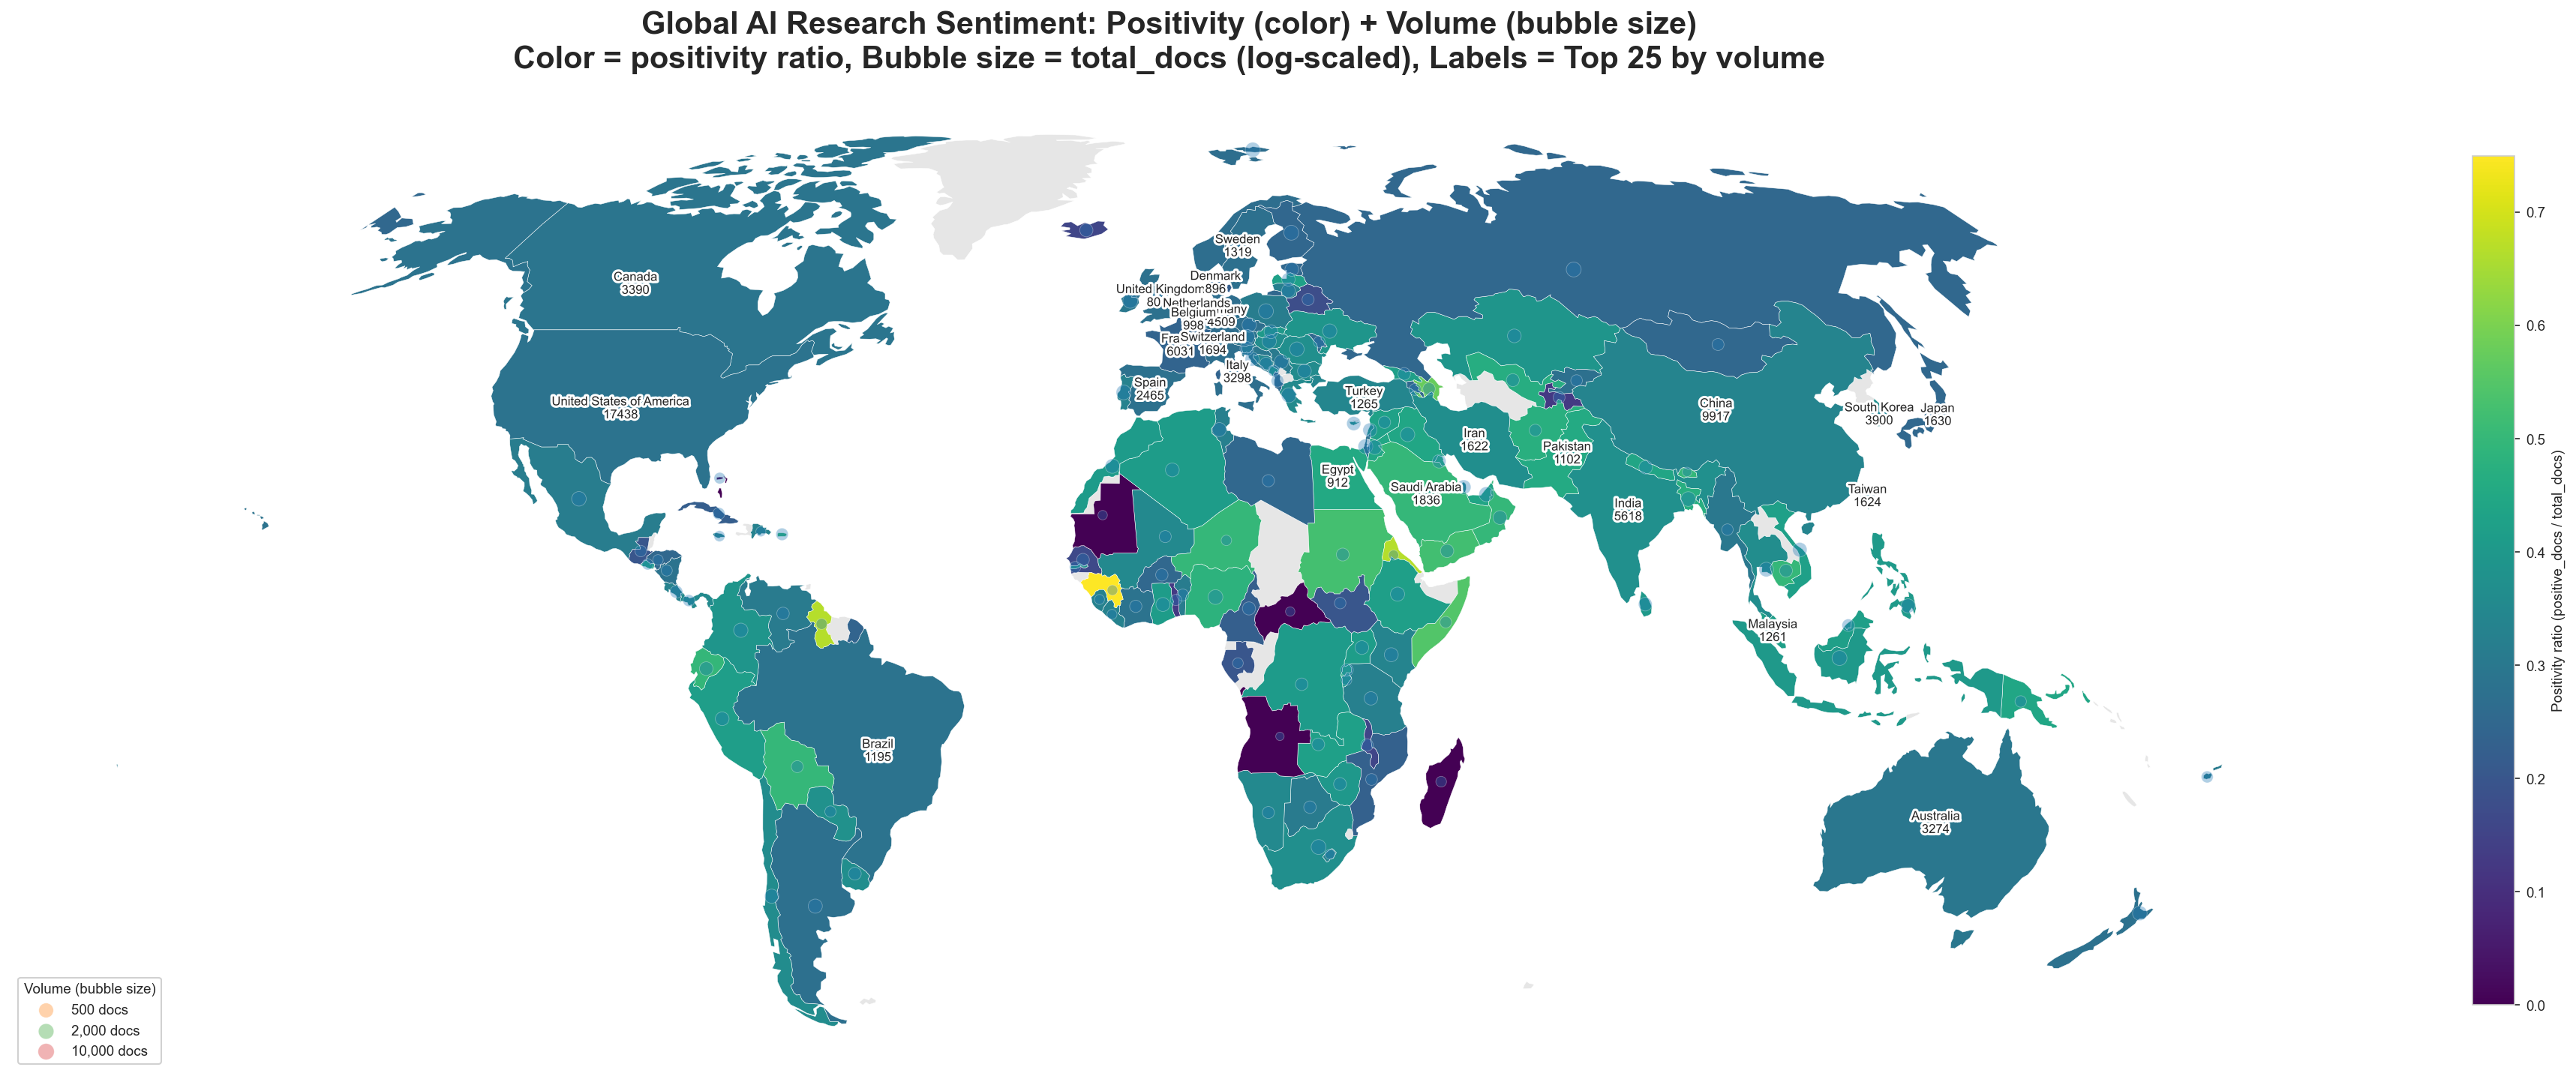

In [42]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib.patches import Patch
import matplotlib.patheffects as pe

# -----------------------------
# 1) Load Data
# -----------------------------
data = """country,total_docs,negative_docs,neutral_docs,positive_docs
united states,17438,3249,4229,4998
china,9917,1442,2014,3369
united kingdom,8016,1659,1928,2218
france,6031,1226,2651,1436
india,5618,831,972,2099
germany,4509,849,1217,1209
canada,3390,671,794,987
italy,3298,655,825,898
australia,3274,663,674,976
spain,2465,496,629,684
netherlands,2267,478,559,548
republic of,1956,312,453,727
korea,1944,309,447,724
saudi arabia,1836,297,269,917
switzerland,1694,336,480,452
japan,1630,241,435,410
sweden,1319,263,342,361
turkey,1265,190,295,437
malaysia,1261,198,216,530
brazil,1195,212,304,341
pakistan,1102,177,192,501
singapore,1096,195,243,348
hong kong,1065,167,213,371
belgium,998,200,262,254
egypt,912,125,174,412
denmark,896,209,246,199
norway,881,198,212,237
austria,866,163,210,252
greece,859,173,162,306
indonesia,845,125,273,341
poland,837,173,222,263
finland,836,148,195,207
taiwan,812,123,150,286
province of china,812,123,150,286
islamic republic of,811,122,127,298
iran,811,122,127,298
russian federation,800,194,224,201
ireland,775,164,186,232
south africa,767,153,153,284
united arab emirates,750,126,129,330
portugal,743,140,169,246
nigeria,652,126,112,314
israel,625,103,165,175
bangladesh,559,83,98,263
mexico,457,86,92,144
thailand,454,88,105,166
new zealand,449,90,114,126
romania,407,91,93,151
viet nam,400,64,75,169
czech republic,382,77,94,104
jordan,370,77,64,165
morocco,333,46,68,136
qatar,329,70,55,114
iraq,318,56,68,141
hungary,304,65,83,111
ukraine,297,68,67,116
colombia,271,47,61,106
chile,252,40,62,91
ethiopia,236,42,47,99
argentina,229,50,59,63
philippines,225,33,42,91
tunisia,201,39,41,65
slovenia,186,31,49,59
croatia,185,35,47,55
lebanon,185,37,39,69
serbia,180,33,56,55
cyprus,177,29,38,66
kenya,175,42,40,59
ghana,165,29,36,68
oman,150,18,17,75
slovakia,146,34,35,59
luxembourg,144,25,43,54
algeria,141,20,32,58
bulgaria,139,32,29,50
estonia,132,23,24,33
lithuania,128,22,29,41
peru,122,28,15,51
kazakhstan,120,22,29,47
uganda,118,32,17,49
ecuador,115,14,21,57
sri lanka,107,13,22,43
kuwait,105,17,16,49
nepal,100,19,20,44
tanzania,80,22,16,26
latvia,80,12,19,34
yemen,69,12,13,36
bahrain,67,7,8,38
iceland,64,17,15,10
cameroon,58,16,18,13
uzbekistan,45,5,10,21
north macedonia,45,8,9,16
cambodia,44,9,5,22
malta,41,9,8,16
zimbabwe,40,11,10,16
sudan,40,5,8,21
uruguay,38,7,7,14
senegal,36,10,15,6
costa rica,33,4,10,11
zambia,33,12,4,14
bosnia and herzegovina,32,7,6,11
rwanda,31,5,4,14
georgia,31,6,6,13
brunei darussalam,28,6,5,11
albania,28,8,3,7
congo,27,7,6,11
venezuela,26,6,8,8
malawi,26,9,11,4
botswana,26,2,9,8
azerbaijan,26,2,5,15
burkina faso,24,6,8,6
puerto rico,23,2,3,11
syrian arab republic,21,5,6,9
cote d'ivoire,21,5,6,6
libya,20,5,6,5
afghanistan,19,3,6,9
cuba,18,0,5,4
mali,17,3,5,6
namibia,17,4,2,6
belarus,17,5,6,3
armenia,16,3,6,4
mongolia,16,4,5,4
tajikistan,16,10,2,2
bolivia,16,3,1,8
benin,16,3,4,5
panama,14,3,5,5
mozambique,13,4,2,3
fiji,13,0,4,4
moldova,12,3,6,3
mauritius,12,3,3,3
kyrgyzstan,11,4,1,3
somalia,11,3,0,6
myanmar,10,5,0,3
guatemala,10,1,4,2
montenegro,10,3,1,4
south sudan,10,3,3,2
trinidad and tobago,9,1,2,3
papua new guinea,9,2,1,4
bahamas,9,1,0,0
togo,8,3,2,1
maldives,8,2,1,4
paraguay,8,2,1,3
gambia,8,1,1,3
nicaragua,7,1,2,2
el salvador,7,1,0,3
guyana,6,1,1,4
jamaica,6,4,0,2
madagascar,5,2,2,0
burundi,5,1,2,2
gabon,5,1,2,1
honduras,4,1,1,1
guinea,4,0,1,3
niger,4,1,1,2
sierra leone,3,1,0,1
eswatini,3,0,0,2
eritrea,3,1,0,2
lesotho,3,0,0,1
dominican republic,3,0,1,1
liberia,3,0,1,1
mauritania,2,0,1,0
bhutan,2,0,1,1
central african republic,2,0,1,0
angola,1,1,0,0
"""
df = pd.read_csv(StringIO(data))

# -----------------------------
# 2) Normalize country names (Natural Earth)
# -----------------------------
df["country"] = df["country"].astype(str).str.strip().str.lower()

name_map = {
    "united states": "United States of America",
    "united kingdom": "United Kingdom",
    "korea": "South Korea",
    "republic of": "South Korea",
    "russian federation": "Russia",
    "islamic republic of": "Iran",
    "iran": "Iran",
    "province of china": "Taiwan",
    "taiwan": "Taiwan",
    "viet nam": "Vietnam",
    "czech republic": "Czechia",
    "syrian arab republic": "Syria",
    "brunei darussalam": "Brunei",
    "congo": "Dem. Rep. Congo",
    "bosnia and herzegovina": "Bosnia and Herz.",
    "north macedonia": "Macedonia",
    "cote d'ivoire": "Côte d'Ivoire",
    "dominican republic": "Dominican Rep.",
    "central african republic": "Central African Rep.",
    "south sudan": "S. Sudan",
}

df["mapped_name"] = df["country"].map(name_map).fillna(df["country"].str.title())

df_agg = (
    df.groupby("mapped_name")[["total_docs", "positive_docs"]]
      .sum()
      .reset_index()
)
df_agg["positivity_ratio"] = df_agg["positive_docs"] / df_agg["total_docs"]

# -----------------------------
# 3) World map (Robinson) + merge
# -----------------------------
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world.columns = world.columns.str.lower()
world = world[world["name"] != "Antarctica"].copy()
world = world.to_crs("ESRI:54030")  # Robinson

world = world.merge(df_agg, left_on="name", right_on="mapped_name", how="left")

# -----------------------------
# 4) Build an “interesting” bivariate view:
#    - Fill color = positivity ratio (continuous)
#    - Bubble size = total_docs (log-scaled)
# -----------------------------
world["positivity_ratio"] = world["positivity_ratio"].fillna(np.nan)
world["total_docs"] = world["total_docs"].fillna(0)

# Bubble sizes (avoid massive bubbles)
world["bubble"] = np.sqrt(np.log1p(world["total_docs"])) * 35

# Centroids for bubbles (representative points inside polygons)
world["pt"] = world.geometry.representative_point()
world["x"] = world["pt"].x
world["y"] = world["pt"].y

# Choose top N countries by volume for labels
TOP_N_LABEL = 25
topN = world.dropna(subset=["mapped_name"]).sort_values("total_docs", ascending=False).head(TOP_N_LABEL)

# -----------------------------
# 5) Plot: Choropleth + bubbles + clean labels
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(26, 14), facecolor="white")
ax.set_facecolor("#d9f3ff")  # ocean

# Base layer: light grey for no-data
world.plot(ax=ax, color="#e6e6e6", edgecolor="white", linewidth=0.25, zorder=1)

# Choropleth only where data exists (positivity ratio)
data_mask = world["positivity_ratio"].notna()
world.loc[data_mask].plot(
    ax=ax,
    column="positivity_ratio",
    cmap="viridis",          # positivity gradient
    edgecolor="white",
    linewidth=0.25,
    legend=True,
    legend_kwds={"label": "Positivity ratio (positive_docs / total_docs)", "shrink": 0.55},
    zorder=2
)

# Bubbles: volume (total_docs)
bubble_mask = world["total_docs"] > 0
ax.scatter(
    world.loc[bubble_mask, "x"],
    world.loc[bubble_mask, "y"],
    s=world.loc[bubble_mask, "bubble"],
    alpha=0.35,
    linewidths=0.4,
    edgecolors="white",
    zorder=3
)

# Label only top-N (readable and “publication” style)
outline = [pe.withStroke(linewidth=3, foreground="white")]
for _, r in topN.iterrows():
    if pd.isna(r["x"]) or pd.isna(r["y"]):
        continue
    ax.text(
        r["x"], r["y"],
        f"{r['name']}\n{int(r['total_docs'])}",
        fontsize=8,
        ha="center", va="center",
        path_effects=outline,
        zorder=4
    )

# Title and minimal styling
ax.set_title(
    "Global AI Research Sentiment: Positivity (color) + Volume (bubble size)\n"
    "Color = positivity ratio, Bubble size = total_docs (log-scaled), Labels = Top 25 by volume",
    fontsize=20, fontweight="bold", pad=14
)
ax.axis("off")

# Bubble size legend (manual)
legend_sizes = [500, 2000, 10000]
handles = []
for v in legend_sizes:
    s = np.sqrt(np.log1p(v)) * 35
    handles.append(plt.scatter([], [], s=s, alpha=0.35, edgecolors="white", linewidths=0.4))
ax.legend(
    handles, [f"{v:,} docs" for v in legend_sizes],
    title="Volume (bubble size)",
    loc="lower left",
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

plt.tight_layout()
plt.show()


Saved PDF: global_north_south_sentiment_map.pdf


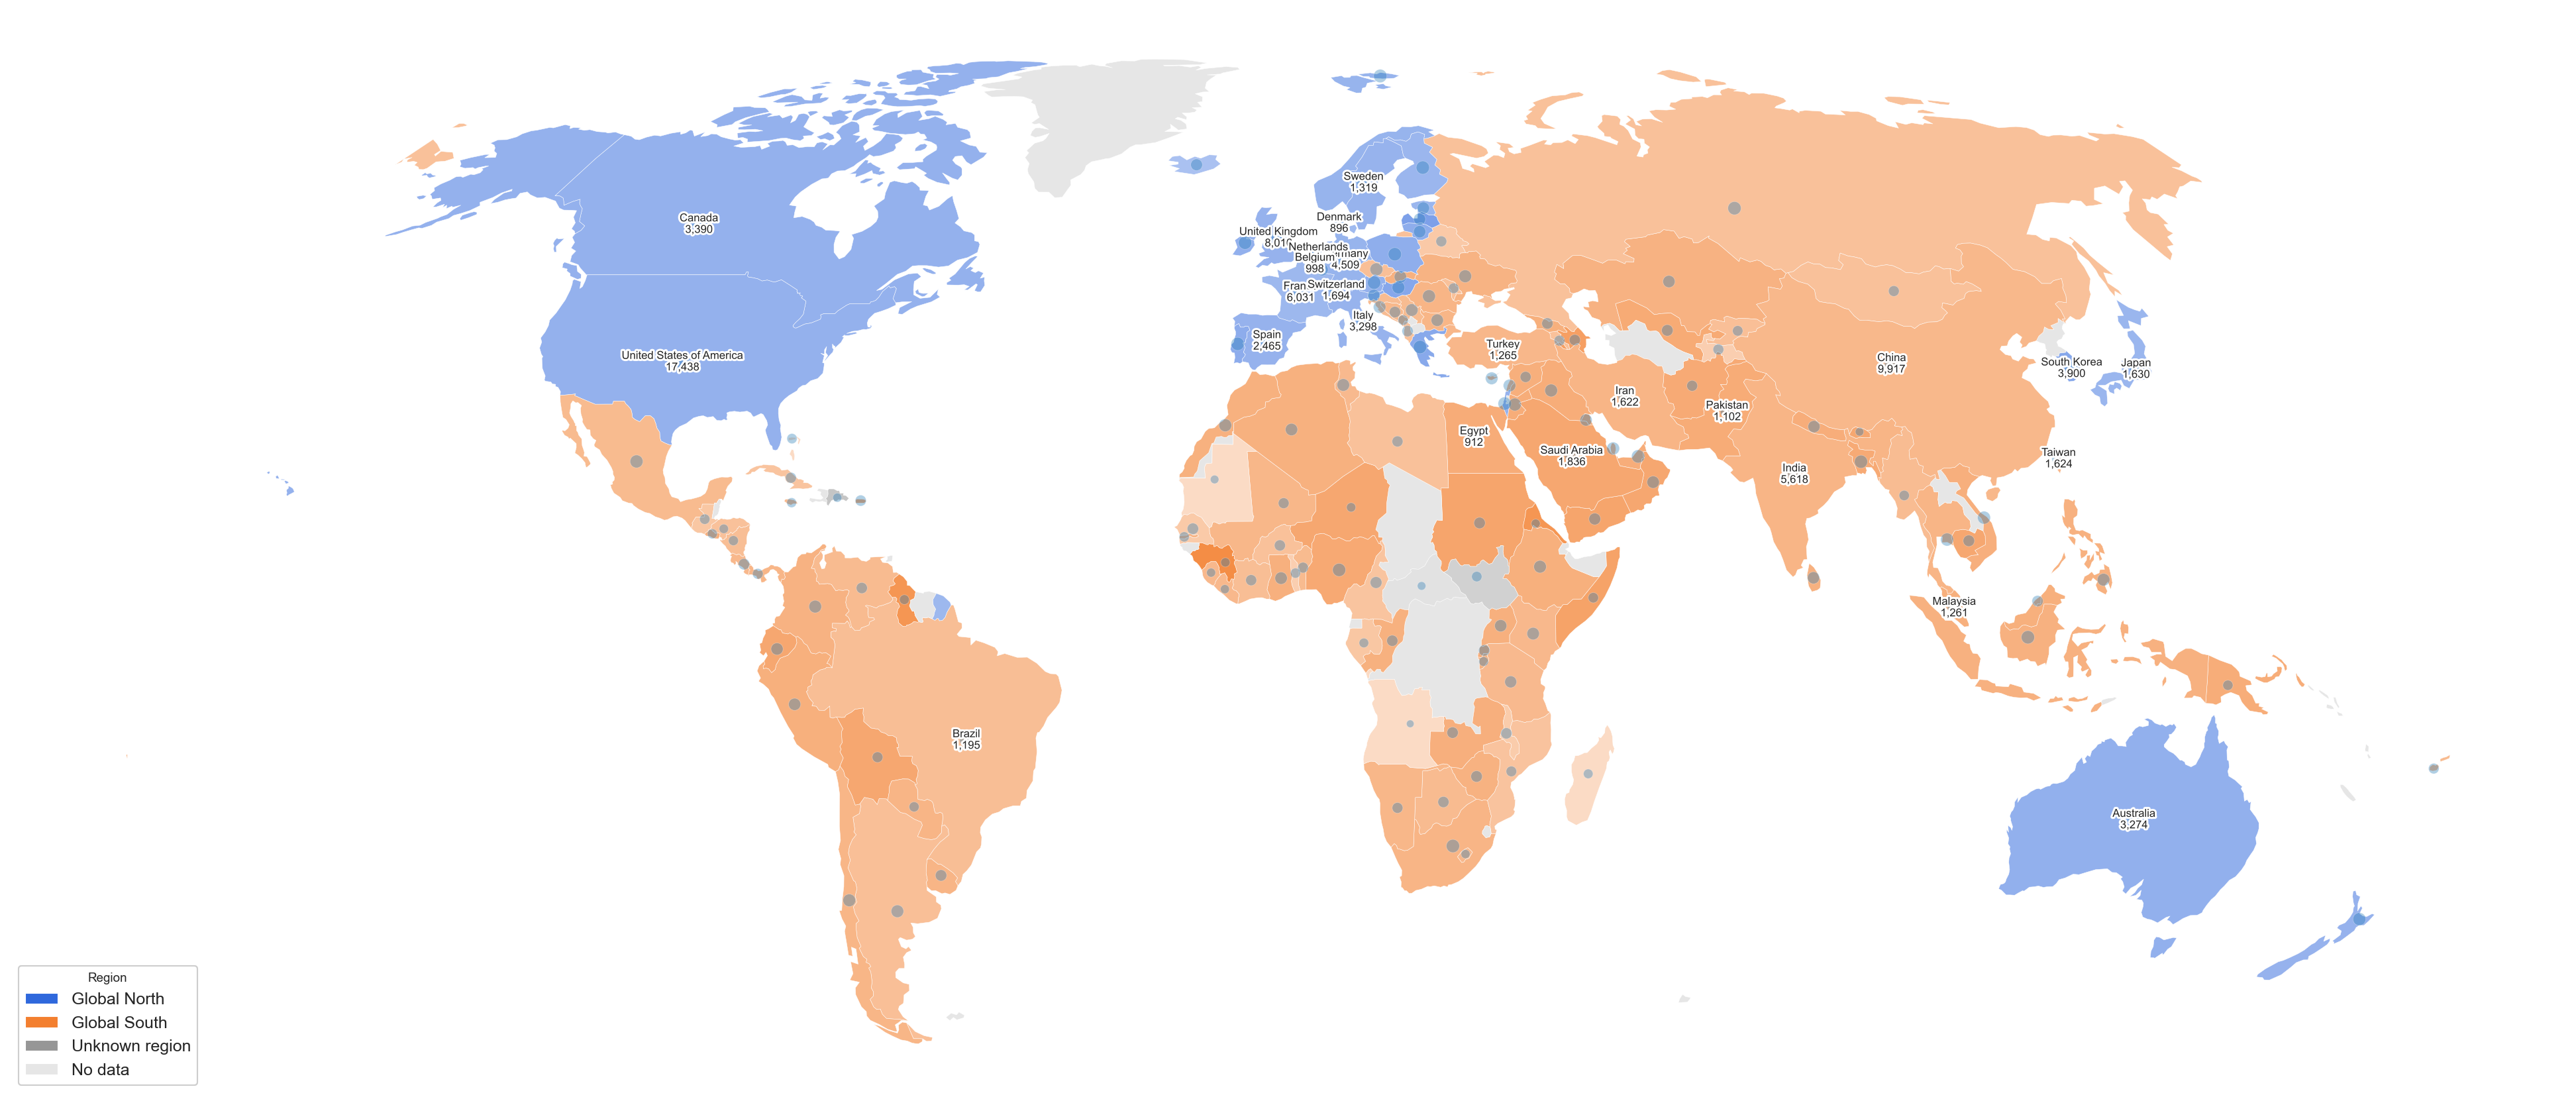

In [45]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib.patches import Patch
import matplotlib.patheffects as pe

# =========================================================
# 0) YOUR DATA
# =========================================================
data = """country,total_docs,negative_docs,neutral_docs,positive_docs
united states,17438,3249,4229,4998
china,9917,1442,2014,3369
united kingdom,8016,1659,1928,2218
france,6031,1226,2651,1436
india,5618,831,972,2099
germany,4509,849,1217,1209
canada,3390,671,794,987
italy,3298,655,825,898
australia,3274,663,674,976
spain,2465,496,629,684
netherlands,2267,478,559,548
republic of,1956,312,453,727
korea,1944,309,447,724
saudi arabia,1836,297,269,917
switzerland,1694,336,480,452
japan,1630,241,435,410
sweden,1319,263,342,361
turkey,1265,190,295,437
malaysia,1261,198,216,530
brazil,1195,212,304,341
pakistan,1102,177,192,501
singapore,1096,195,243,348
hong kong,1065,167,213,371
belgium,998,200,262,254
egypt,912,125,174,412
denmark,896,209,246,199
norway,881,198,212,237
austria,866,163,210,252
greece,859,173,162,306
indonesia,845,125,273,341
poland,837,173,222,263
finland,836,148,195,207
taiwan,812,123,150,286
province of china,812,123,150,286
islamic republic of,811,122,127,298
iran,811,122,127,298
russian federation,800,194,224,201
ireland,775,164,186,232
south africa,767,153,153,284
united arab emirates,750,126,129,330
portugal,743,140,169,246
nigeria,652,126,112,314
israel,625,103,165,175
bangladesh,559,83,98,263
mexico,457,86,92,144
thailand,454,88,105,166
new zealand,449,90,114,126
romania,407,91,93,151
viet nam,400,64,75,169
czech republic,382,77,94,104
jordan,370,77,64,165
morocco,333,46,68,136
qatar,329,70,55,114
iraq,318,56,68,141
hungary,304,65,83,111
ukraine,297,68,67,116
colombia,271,47,61,106
chile,252,40,62,91
ethiopia,236,42,47,99
argentina,229,50,59,63
philippines,225,33,42,91
tunisia,201,39,41,65
slovenia,186,31,49,59
croatia,185,35,47,55
lebanon,185,37,39,69
serbia,180,33,56,55
cyprus,177,29,38,66
kenya,175,42,40,59
ghana,165,29,36,68
oman,150,18,17,75
slovakia,146,34,35,59
luxembourg,144,25,43,54
algeria,141,20,32,58
bulgaria,139,32,29,50
estonia,132,23,24,33
lithuania,128,22,29,41
peru,122,28,15,51
kazakhstan,120,22,29,47
uganda,118,32,17,49
ecuador,115,14,21,57
sri lanka,107,13,22,43
kuwait,105,17,16,49
nepal,100,19,20,44
tanzania,80,22,16,26
latvia,80,12,19,34
yemen,69,12,13,36
bahrain,67,7,8,38
iceland,64,17,15,10
cameroon,58,16,18,13
uzbekistan,45,5,10,21
north macedonia,45,8,9,16
cambodia,44,9,5,22
malta,41,9,8,16
zimbabwe,40,11,10,16
sudan,40,5,8,21
uruguay,38,7,7,14
senegal,36,10,15,6
costa rica,33,4,10,11
zambia,33,12,4,14
bosnia and herzegovina,32,7,6,11
rwanda,31,5,4,14
georgia,31,6,6,13
brunei darussalam,28,6,5,11
albania,28,8,3,7
congo,27,7,6,11
venezuela,26,6,8,8
malawi,26,9,11,4
botswana,26,2,9,8
azerbaijan,26,2,5,15
burkina faso,24,6,8,6
puerto rico,23,2,3,11
syrian arab republic,21,5,6,9
cote d'ivoire,21,5,6,6
libya,20,5,6,5
afghanistan,19,3,6,9
cuba,18,0,5,4
mali,17,3,5,6
namibia,17,4,2,6
belarus,17,5,6,3
armenia,16,3,6,4
mongolia,16,4,5,4
tajikistan,16,10,2,2
bolivia,16,3,1,8
benin,16,3,4,5
panama,14,3,5,5
mozambique,13,4,2,3
fiji,13,0,4,4
moldova,12,3,6,3
mauritius,12,3,3,3
kyrgyzstan,11,4,1,3
somalia,11,3,0,6
myanmar,10,5,0,3
guatemala,10,1,4,2
montenegro,10,3,1,4
south sudan,10,3,3,2
trinidad and tobago,9,1,2,3
papua new guinea,9,2,1,4
bahamas,9,1,0,0
togo,8,3,2,1
maldives,8,2,1,4
paraguay,8,2,1,3
gambia,8,1,1,3
nicaragua,7,1,2,2
el salvador,7,1,0,3
guyana,6,1,1,4
jamaica,6,4,0,2
madagascar,5,2,2,0
burundi,5,1,2,2
gabon,5,1,2,1
honduras,4,1,1,1
guinea,4,0,1,3
niger,4,1,1,2
sierra leone,3,1,0,1
eswatini,3,0,0,2
eritrea,3,1,0,2
lesotho,3,0,0,1
dominican republic,3,0,1,1
liberia,3,0,1,1
mauritania,2,0,1,0
bhutan,2,0,1,1
central african republic,2,0,1,0
angola,1,1,0,0
"""
df = pd.read_csv(StringIO(data))

# =========================================================
# 1) YOUR GLOBAL NORTH / SOUTH LISTS
# =========================================================
GLOBAL_NORTH_NAMES = {
    "Australia","Austria","Belgium","Canada","Denmark","Estonia","Finland","France",
    "Germany","Greece","Hungary","Iceland","Ireland","Israel","Italy","Japan",
    "Korea, Republic of (South Korea)","Latvia","Liechtenstein","Lithuania",
    "Luxembourg","Monaco","Netherlands","New Zealand","Norway","Poland","Portugal",
    "San Marino","Slovenia","Spain","Sweden","Switzerland","United Kingdom",
    "United States",
}
GLOBAL_SOUTH_NAMES = {
    "Afghanistan","Albania","Algeria","Andorra","Angola","Anguilla",
    "Antigua and Barbuda","Argentina","Armenia","Aruba","Azerbaijan","Bahamas",
    "Bahrain","Bangladesh","Barbados","Belarus","Belize","Benin","Bhutan","Bolivia",
    "Bosnia and Herzegovina","Botswana","Brazil","Brunei Darussalam","Bulgaria",
    "Burkina Faso","Burundi","Cambodia","Cameroon","Cape Verde",
    "Central African Republic","Chad","Channel Islands","Chile","China",
    "China, Macao SAR","Colombia","Comoros","Congo","Congo, Democratic Republic of the",
    "Costa Rica","Côte d’Ivoire","Croatia","Cuba","Cyprus","Czech Republic","Djibouti",
    "Dominica","Dominican Republic","Ecuador","Egypt","El Salvador","Equatorial Guinea",
    "Eritrea","Ethiopia","Fiji","French Guiana","French Polynesia","Gabon","Gambia",
    "Georgia","Ghana","Grenada","Guadeloupe","Guam","Guatemala","Guinea",
    "Guinea-Bissau","Guyana","Haiti","Honduras","Hong Kong","India","Indonesia",
    "Iran (Islamic Republic of)","Iraq","Jamaica","Jordan","Kazakhstan","Kenya",
    "Kiribati","Korea, Democratic People’s Republic of (North Korea)","Kuwait",
    "Kyrgyzstan","Lao PDR","Lebanon","Lesotho","Liberia","Libya","Madagascar","Malawi",
    "Malaysia","Maldives","Mali","Malta","Marshall Islands","Martinique","Mauritania",
    "Mauritius","Mayotte","Mexico","Micronesia (Federated States of)","Mongolia",
    "Montenegro","Morocco","Mozambique","Myanmar","Namibia","Nauru","Nepal",
    "Netherlands Antilles","New Caledonia","Nicaragua","Niger","Nigeria","Oman",
    "Pakistan","Palau","Palestinian Territory, Occupied","Panama","Papua New Guinea",
    "Paraguay","Peru","Philippines","Puerto Rico","Qatar","Republic of Moldova",
    "Réunion","Romania","Russian Federation","Rwanda","Saint Kitts and Nevis",
    "Saint Lucia","Saint Vincent and the Grenadines","Samoa","Sao Tome and Principe",
    "Saudi Arabia","Senegal","Serbia","Seychelles","Sierra Leone","Singapore",
    "Slovakia","Solomon Islands","Somalia","South Africa","South Sudan","Sri Lanka",
    "Sudan","Suriname","Swaziland (Eswatini)","Syrian Arab Republic","Taiwan",
    "Tajikistan","Tanzania","Thailand",
    "The former Yugoslav Republic of Macedonia (North Macedonia)","Timor-Leste","Togo",
    "Tonga","Trinidad and Tobago","Tunisia","Turkey","Turkmenistan","Tuvalu","Uganda",
    "Ukraine","United Arab Emirates","Uruguay","Uzbekistan","Vanuatu","Venezuela",
    "Viet Nam","Virgin Islands","Western Sahara","Yemen","Zambia","Zimbabwe",
}

# =========================================================
# 2) NORMALIZE NAMES TO MATCH NATURAL EARTH "name"
# =========================================================
# Natural Earth uses specific country names; this maps your list names to NE names.
NE_NAME_FIX = {
    "United States": "United States of America",
    "Russian Federation": "Russia",
    "Viet Nam": "Vietnam",
    "Czech Republic": "Czechia",
    "Syrian Arab Republic": "Syria",
    "Iran (Islamic Republic of)": "Iran",
    "Korea, Republic of (South Korea)": "South Korea",
    "Korea, Democratic People’s Republic of (North Korea)": "North Korea",
    "Congo, Democratic Republic of the": "Dem. Rep. Congo",
    "Brunei Darussalam": "Brunei",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "The former Yugoslav Republic of Macedonia (North Macedonia)": "Macedonia",
    "Côte d’Ivoire": "Côte d'Ivoire",
    "Republic of Moldova": "Moldova",
    "Swaziland (Eswatini)": "Eswatini",
    "Palestinian Territory, Occupied": "Palestine",
    # If any of these don't exist in NE as countries, they will remain "Unknown":
    # "Channel Islands", "Netherlands Antilles", etc.
}
def to_ne_name(name: str) -> str:
    name = str(name).strip()
    return NE_NAME_FIX.get(name, name)

GN_NE = {to_ne_name(x) for x in GLOBAL_NORTH_NAMES}
GS_NE = {to_ne_name(x) for x in GLOBAL_SOUTH_NAMES}

# =========================================================
# 3) NORMALIZE YOUR INPUT COUNTRY NAMES (df) TO MATCH NATURAL EARTH
# =========================================================
df["country"] = df["country"].astype(str).str.strip().str.lower()

input_name_map = {
    "united states": "United States of America",
    "united kingdom": "United Kingdom",
    "korea": "South Korea",
    "republic of": "South Korea",
    "russian federation": "Russia",
    "islamic republic of": "Iran",
    "iran": "Iran",
    "province of china": "Taiwan",
    "taiwan": "Taiwan",
    "viet nam": "Vietnam",
    "czech republic": "Czechia",
    "syrian arab republic": "Syria",
    "brunei darussalam": "Brunei",
    "congo": "Congo",
    "bosnia and herzegovina": "Bosnia and Herz.",
    "north macedonia": "Macedonia",
    "cote d'ivoire": "Côte d'Ivoire",
    "dominican republic": "Dominican Rep.",
    "central african republic": "Central African Rep.",
    "south sudan": "S. Sudan",
}
df["mapped_name"] = df["country"].map(input_name_map).fillna(df["country"].str.title())

df_agg = (
    df.groupby("mapped_name")[["total_docs", "positive_docs", "negative_docs", "neutral_docs"]]
      .sum()
      .reset_index()
)
df_agg["positivity_ratio"] = df_agg["positive_docs"] / df_agg["total_docs"].replace(0, np.nan)
df_agg["positivity_ratio"] = df_agg["positivity_ratio"].fillna(0)

# =========================================================
# 4) LOAD WORLD MAP (NATURAL EARTH) + PROJECTION
# =========================================================
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world.columns = world.columns.str.lower()
world = world[world["name"] != "Antarctica"].copy()

# Robinson-like projection for publication look
world = world.to_crs("ESRI:54030")

# Merge data
world = world.merge(df_agg, left_on="name", right_on="mapped_name", how="left")

# =========================================================
# 5) CLASSIFY GLOBAL NORTH / SOUTH USING YOUR LISTS
# =========================================================
def classify_region(ne_country_name: str) -> str:
    if ne_country_name in GN_NE:
        return "Global North"
    if ne_country_name in GS_NE:
        return "Global South"
    return "Unknown"

world["region"] = world["name"].apply(classify_region)

# =========================================================
# 6) MAKE AN "INTERESTING" MAP:
#    - Fill color family by region (North vs South vs Unknown)
#    - Fill intensity by positivity_ratio
#    - Bubble size by total_docs (log-scaled)
#    - Label top N countries by total_docs
# =========================================================
world["total_docs"] = world["total_docs"].fillna(0)
world["positivity_ratio"] = world["positivity_ratio"].fillna(0)

# Bubble sizes: stable for huge ranges
world["bubble_size"] = np.sqrt(np.log1p(world["total_docs"])) * 35

# Representative points for bubbles + labels
world["pt"] = world.geometry.representative_point()
world["x"] = world["pt"].x
world["y"] = world["pt"].y

# Color encoding: region hue + positivity alpha/intensity
# (Matplotlib RGBA tuples are accepted by GeoPandas plot)
def rgba_for_row(region: str, ratio: float, has_data: bool):
    if not has_data:
        return "#e6e6e6"  # no data
    # intensity: 0.25..1.0
    a = 0.25 + (float(ratio) * 0.75)
    a = min(max(a, 0.25), 1.0)

    if region == "Global North":
        return (0.10, 0.35, 0.85, a)  # blue family
    if region == "Global South":
        return (0.95, 0.45, 0.10, a)  # orange family
    return (0.55, 0.55, 0.55, a)      # unknown region

has_data = ~world["mapped_name"].isna()
world["fill"] = [
    rgba_for_row(r, pr, hd)
    for r, pr, hd in zip(world["region"], world["positivity_ratio"], has_data)
]

# Top labels by volume (readable)
TOP_N_LABEL = 25
topN = world.sort_values("total_docs", ascending=False).head(TOP_N_LABEL).copy()

# =========================================================
# 7) PLOT + SAVE PDF
# =========================================================
PDF_OUT = "global_north_south_sentiment_map.pdf"

fig, ax = plt.subplots(1, 1, figsize=(26, 14), facecolor="white")
ax.set_facecolor("#d9f3ff")  # ocean

# Base map with region+intensity fills
world.plot(ax=ax, color=world["fill"], edgecolor="white", linewidth=0.25, zorder=1)

# Bubbles for volume (only where total_docs > 0)
bubble_mask = world["total_docs"] > 0
ax.scatter(
    world.loc[bubble_mask, "x"],
    world.loc[bubble_mask, "y"],
    s=world.loc[bubble_mask, "bubble_size"],
    alpha=0.35,
    linewidths=0.35,
    edgecolors="white",
    zorder=2
)

# Labels for top countries
outline = [pe.withStroke(linewidth=3, foreground="white")]
for _, r in topN.iterrows():
    if pd.isna(r["x"]) or pd.isna(r["y"]) or r["total_docs"] <= 0:
        continue
    ax.text(
        r["x"], r["y"],
        f"{r['name']}\n{int(r['total_docs']):,}",
        fontsize=8,
        ha="center", va="center",
        path_effects=outline,
        zorder=3
    )

# Title
#ax.set_title(
 #   "Global AI Research Sentiment Map (Global North vs Global South)\n"
 #   "Fill hue: region | Fill intensity: positivity ratio | Bubble size: total documents (log-scaled)",
  ##)
ax.axis("off")

# Legends
legend_elements = [
    Patch(facecolor=(0.10, 0.35, 0.85, 0.9), edgecolor="white", label="Global North"),
    Patch(facecolor=(0.95, 0.45, 0.10, 0.9), edgecolor="white", label="Global South"),
    Patch(facecolor=(0.55, 0.55, 0.55, 0.9), edgecolor="white", label="Unknown region"),
    Patch(facecolor="#e6e6e6", edgecolor="white", label="No data"),
]
ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=12,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    title="Region"
)

# Bubble size legend (manual)
legend_sizes = [500, 2000, 10000]
handles = []
labels = []
for v in legend_sizes:
    s = np.sqrt(np.log1p(v)) * 35
    handles.append(plt.scatter([], [], s=s, alpha=0.35, edgecolors="white", linewidths=0.35))
    labels.append(f"{v:,} docs")
ax.legend(
    handles, labels,
    title="Volume (bubble size)",
    loc="lower right",
    frameon=True,
    facecolor="white",
    framealpha=0.9
)
# Re-add first legend (matplotlib overwrites when adding second)
ax.add_artist(ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=12,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    title="Region"
))

plt.tight_layout()

# Save PDF (publication)
fig.savefig(PDF_OUT, dpi=300, bbox_inches="tight")
print(f"Saved PDF: {PDF_OUT}")

plt.show()


Fetching flags for Top 50 (this may take a moment)...
Done! Saved as 'global_north_south_flags.pdf'


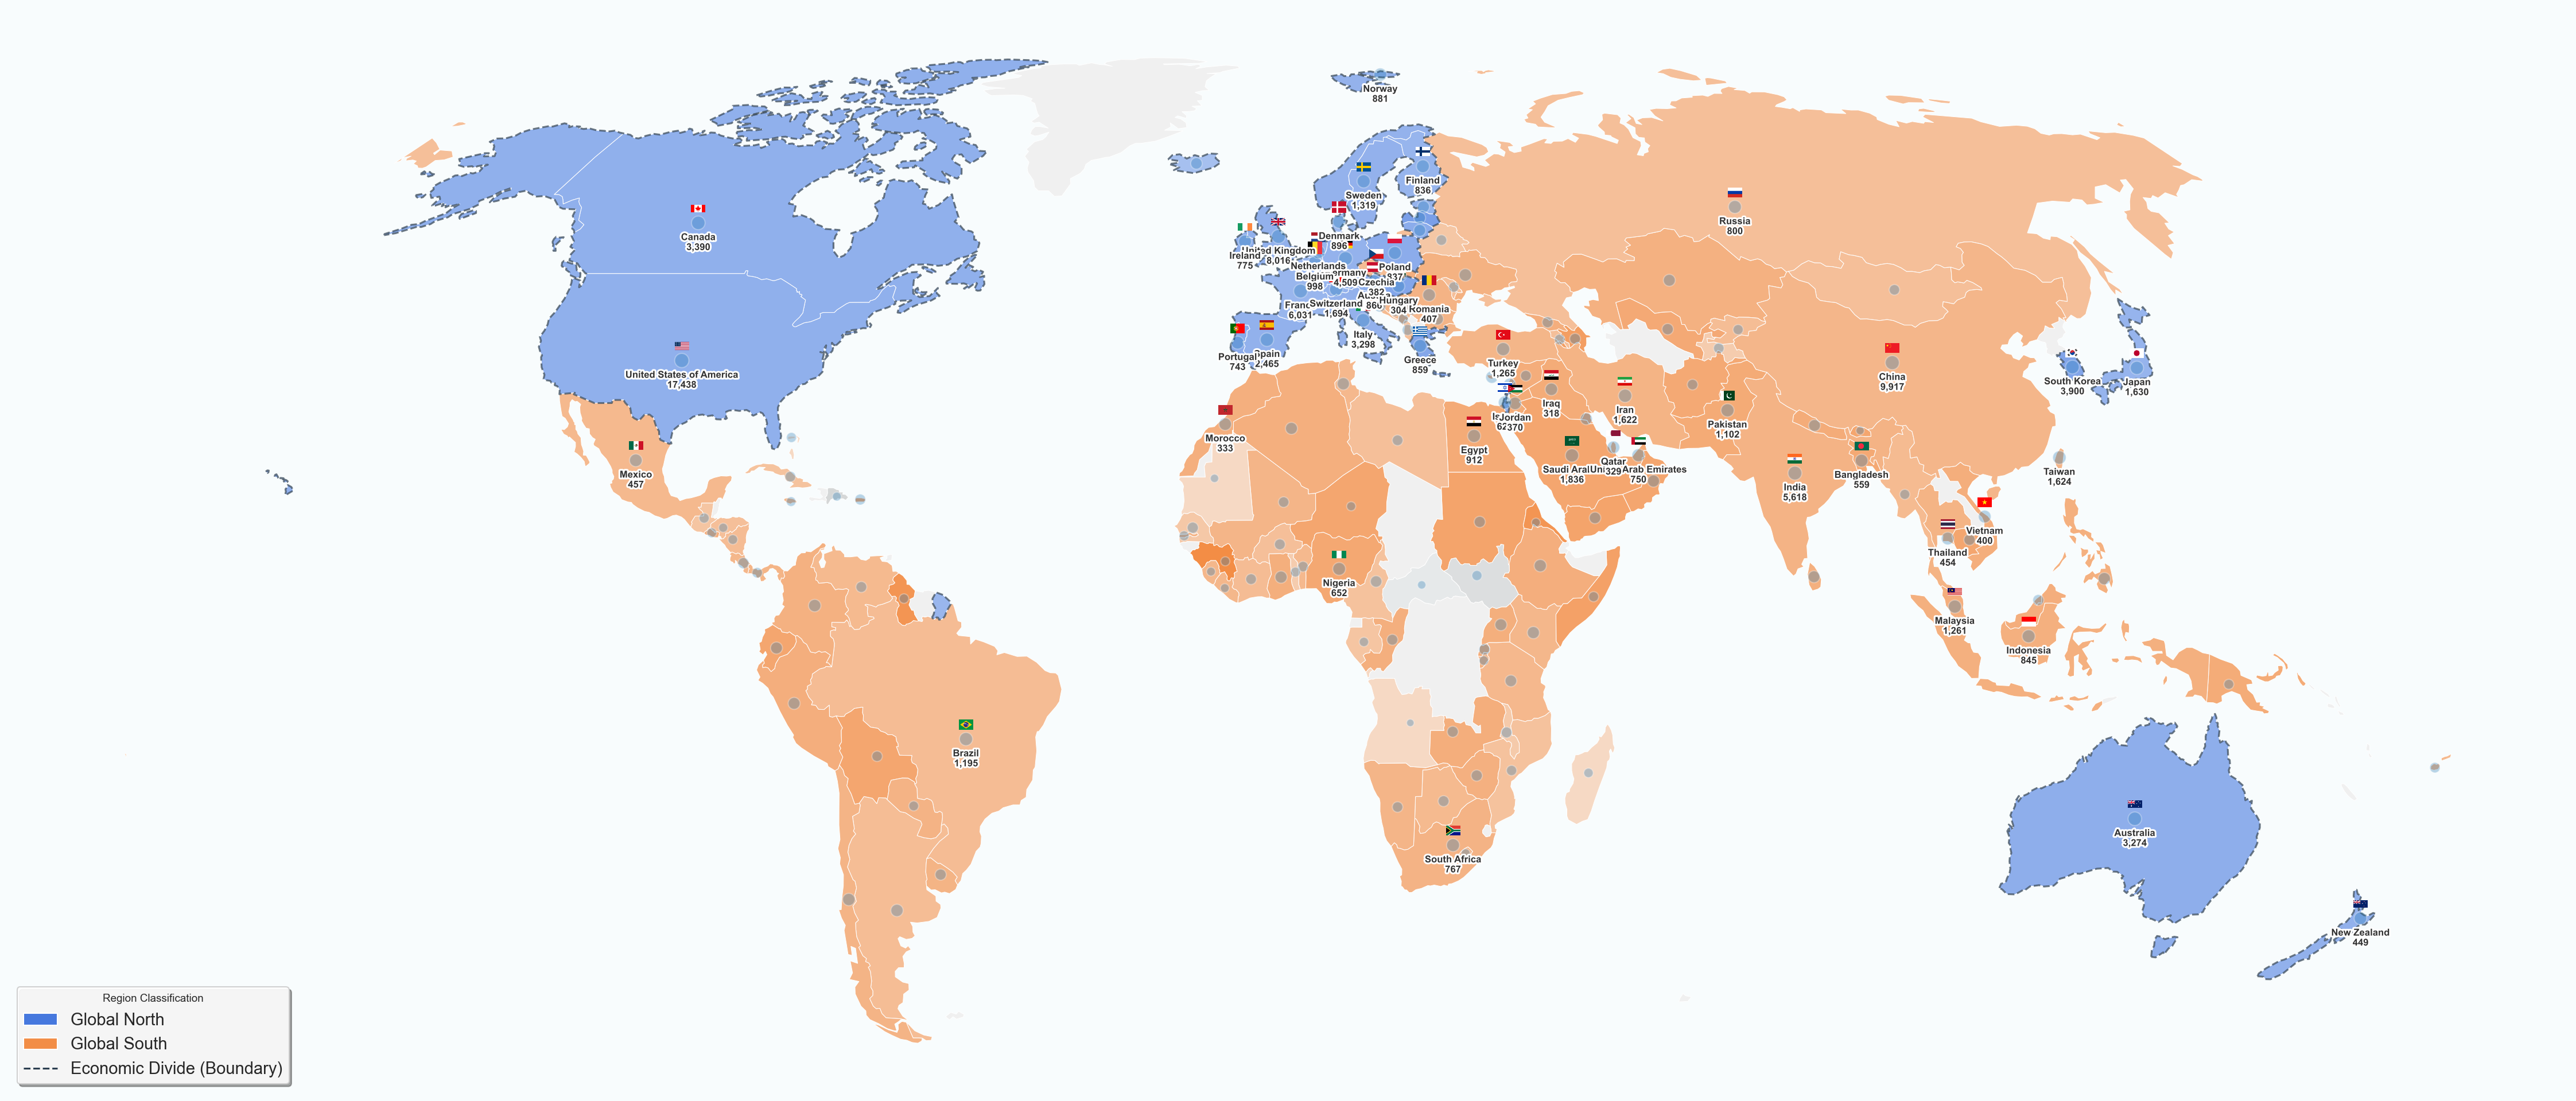

In [50]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from io import StringIO, BytesIO
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
from PIL import Image

# =========================================================
# 1) DATA LOADING
# =========================================================
data = """country,total_docs,negative_docs,neutral_docs,positive_docs
united states,17438,3249,4229,4998
china,9917,1442,2014,3369
united kingdom,8016,1659,1928,2218
france,6031,1226,2651,1436
india,5618,831,972,2099
germany,4509,849,1217,1209
canada,3390,671,794,987
italy,3298,655,825,898
australia,3274,663,674,976
spain,2465,496,629,684
netherlands,2267,478,559,548
republic of,1956,312,453,727
korea,1944,309,447,724
saudi arabia,1836,297,269,917
switzerland,1694,336,480,452
japan,1630,241,435,410
sweden,1319,263,342,361
turkey,1265,190,295,437
malaysia,1261,198,216,530
brazil,1195,212,304,341
pakistan,1102,177,192,501
singapore,1096,195,243,348
hong kong,1065,167,213,371
belgium,998,200,262,254
egypt,912,125,174,412
denmark,896,209,246,199
norway,881,198,212,237
austria,866,163,210,252
greece,859,173,162,306
indonesia,845,125,273,341
poland,837,173,222,263
finland,836,148,195,207
taiwan,812,123,150,286
province of china,812,123,150,286
islamic republic of,811,122,127,298
iran,811,122,127,298
russian federation,800,194,224,201
ireland,775,164,186,232
south africa,767,153,153,284
united arab emirates,750,126,129,330
portugal,743,140,169,246
nigeria,652,126,112,314
israel,625,103,165,175
bangladesh,559,83,98,263
mexico,457,86,92,144
thailand,454,88,105,166
new zealand,449,90,114,126
romania,407,91,93,151
viet nam,400,64,75,169
czech republic,382,77,94,104
jordan,370,77,64,165
morocco,333,46,68,136
qatar,329,70,55,114
iraq,318,56,68,141
hungary,304,65,83,111
ukraine,297,68,67,116
colombia,271,47,61,106
chile,252,40,62,91
ethiopia,236,42,47,99
argentina,229,50,59,63
philippines,225,33,42,91
tunisia,201,39,41,65
slovenia,186,31,49,59
croatia,185,35,47,55
lebanon,185,37,39,69
serbia,180,33,56,55
cyprus,177,29,38,66
kenya,175,42,40,59
ghana,165,29,36,68
oman,150,18,17,75
slovakia,146,34,35,59
luxembourg,144,25,43,54
algeria,141,20,32,58
bulgaria,139,32,29,50
estonia,132,23,24,33
lithuania,128,22,29,41
peru,122,28,15,51
kazakhstan,120,22,29,47
uganda,118,32,17,49
ecuador,115,14,21,57
sri lanka,107,13,22,43
kuwait,105,17,16,49
nepal,100,19,20,44
tanzania,80,22,16,26
latvia,80,12,19,34
yemen,69,12,13,36
bahrain,67,7,8,38
iceland,64,17,15,10
cameroon,58,16,18,13
uzbekistan,45,5,10,21
north macedonia,45,8,9,16
cambodia,44,9,5,22
malta,41,9,8,16
zimbabwe,40,11,10,16
sudan,40,5,8,21
uruguay,38,7,7,14
senegal,36,10,15,6
costa rica,33,4,10,11
zambia,33,12,4,14
bosnia and herzegovina,32,7,6,11
rwanda,31,5,4,14
georgia,31,6,6,13
brunei darussalam,28,6,5,11
albania,28,8,3,7
congo,27,7,6,11
venezuela,26,6,8,8
malawi,26,9,11,4
botswana,26,2,9,8
azerbaijan,26,2,5,15
burkina faso,24,6,8,6
puerto rico,23,2,3,11
syrian arab republic,21,5,6,9
cote d'ivoire,21,5,6,6
libya,20,5,6,5
afghanistan,19,3,6,9
cuba,18,0,5,4
mali,17,3,5,6
namibia,17,4,2,6
belarus,17,5,6,3
armenia,16,3,6,4
mongolia,16,4,5,4
tajikistan,16,10,2,2
bolivia,16,3,1,8
benin,16,3,4,5
panama,14,3,5,5
mozambique,13,4,2,3
fiji,13,0,4,4
moldova,12,3,6,3
mauritius,12,3,3,3
kyrgyzstan,11,4,1,3
somalia,11,3,0,6
myanmar,10,5,0,3
guatemala,10,1,4,2
montenegro,10,3,1,4
south sudan,10,3,3,2
trinidad and tobago,9,1,2,3
papua new guinea,9,2,1,4
bahamas,9,1,0,0
togo,8,3,2,1
maldives,8,2,1,4
paraguay,8,2,1,3
gambia,8,1,1,3
nicaragua,7,1,2,2
el salvador,7,1,0,3
guyana,6,1,1,4
jamaica,6,4,0,2
madagascar,5,2,2,0
burundi,5,1,2,2
gabon,5,1,2,1
honduras,4,1,1,1
guinea,4,0,1,3
niger,4,1,1,2
sierra leone,3,1,0,1
eswatini,3,0,0,2
eritrea,3,1,0,2
lesotho,3,0,0,1
dominican republic,3,0,1,1
liberia,3,0,1,1
mauritania,2,0,1,0
bhutan,2,0,1,1
central african republic,2,0,1,0
angola,1,1,0,0
"""
df = pd.read_csv(StringIO(data))

# =========================================================
# 2) LISTS (NORTH / SOUTH)
# =========================================================
GLOBAL_NORTH_NAMES = {
    "Australia","Austria","Belgium","Canada","Denmark","Estonia","Finland","France",
    "Germany","Greece","Hungary","Iceland","Ireland","Israel","Italy","Japan",
    "Korea, Republic of (South Korea)","Latvia","Liechtenstein","Lithuania",
    "Luxembourg","Monaco","Netherlands","New Zealand","Norway","Poland","Portugal",
    "San Marino","Slovenia","Spain","Sweden","Switzerland","United Kingdom",
    "United States",
}
GLOBAL_SOUTH_NAMES = {
    "Afghanistan","Albania","Algeria","Andorra","Angola","Anguilla",
    "Antigua and Barbuda","Argentina","Armenia","Aruba","Azerbaijan","Bahamas",
    "Bahrain","Bangladesh","Barbados","Belarus","Belize","Benin","Bhutan","Bolivia",
    "Bosnia and Herzegovina","Botswana","Brazil","Brunei Darussalam","Bulgaria",
    "Burkina Faso","Burundi","Cambodia","Cameroon","Cape Verde",
    "Central African Republic","Chad","Channel Islands","Chile","China",
    "China, Macao SAR","Colombia","Comoros","Congo","Congo, Democratic Republic of the",
    "Costa Rica","Côte d’Ivoire","Croatia","Cuba","Cyprus","Czech Republic","Djibouti",
    "Dominica","Dominican Republic","Ecuador","Egypt","El Salvador","Equatorial Guinea",
    "Eritrea","Ethiopia","Fiji","French Guiana","French Polynesia","Gabon","Gambia",
    "Georgia","Ghana","Grenada","Guadeloupe","Guam","Guatemala","Guinea",
    "Guinea-Bissau","Guyana","Haiti","Honduras","Hong Kong","India","Indonesia",
    "Iran (Islamic Republic of)","Iraq","Jamaica","Jordan","Kazakhstan","Kenya",
    "Kiribati","Korea, Democratic People’s Republic of (North Korea)","Kuwait",
    "Kyrgyzstan","Lao PDR","Lebanon","Lesotho","Liberia","Libya","Madagascar","Malawi",
    "Malaysia","Maldives","Mali","Malta","Marshall Islands","Martinique","Mauritania",
    "Mauritius","Mayotte","Mexico","Micronesia (Federated States of)","Mongolia",
    "Montenegro","Morocco","Mozambique","Myanmar","Namibia","Nauru","Nepal",
    "Netherlands Antilles","New Caledonia","Nicaragua","Niger","Nigeria","Oman",
    "Pakistan","Palau","Palestinian Territory, Occupied","Panama","Papua New Guinea",
    "Paraguay","Peru","Philippines","Puerto Rico","Qatar","Republic of Moldova",
    "Réunion","Romania","Russian Federation","Rwanda","Saint Kitts and Nevis",
    "Saint Lucia","Saint Vincent and the Grenadines","Samoa","Sao Tome and Principe",
    "Saudi Arabia","Senegal","Serbia","Seychelles","Sierra Leone","Singapore",
    "Slovakia","Solomon Islands","Somalia","South Africa","South Sudan","Sri Lanka",
    "Sudan","Suriname","Swaziland (Eswatini)","Syrian Arab Republic","Taiwan",
    "Tajikistan","Tanzania","Thailand",
    "The former Yugoslav Republic of Macedonia (North Macedonia)","Timor-Leste","Togo",
    "Tonga","Trinidad and Tobago","Tunisia","Turkey","Turkmenistan","Tuvalu","Uganda",
    "Ukraine","United Arab Emirates","Uruguay","Uzbekistan","Vanuatu","Venezuela",
    "Viet Nam","Virgin Islands","Western Sahara","Yemen","Zambia","Zimbabwe",
}

# =========================================================
# 3) NORMALIZE NAMES
# =========================================================
NE_NAME_FIX = {
    "United States": "United States of America",
    "Russian Federation": "Russia",
    "Viet Nam": "Vietnam",
    "Czech Republic": "Czechia",
    "Syrian Arab Republic": "Syria",
    "Iran (Islamic Republic of)": "Iran",
    "Korea, Republic of (South Korea)": "South Korea",
    "Korea, Democratic People’s Republic of (North Korea)": "North Korea",
    "Congo, Democratic Republic of the": "Dem. Rep. Congo",
    "Brunei Darussalam": "Brunei",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "The former Yugoslav Republic of Macedonia (North Macedonia)": "Macedonia",
    "Côte d’Ivoire": "Côte d'Ivoire",
    "Republic of Moldova": "Moldova",
    "Swaziland (Eswatini)": "Eswatini",
    "Palestinian Territory, Occupied": "Palestine",
}
def to_ne_name(name: str) -> str:
    name = str(name).strip()
    return NE_NAME_FIX.get(name, name)

GN_NE = {to_ne_name(x) for x in GLOBAL_NORTH_NAMES}
GS_NE = {to_ne_name(x) for x in GLOBAL_SOUTH_NAMES}

df["country"] = df["country"].astype(str).str.strip().str.lower()
input_name_map = {
    "united states": "United States of America",
    "united kingdom": "United Kingdom",
    "korea": "South Korea",
    "republic of": "South Korea",
    "russian federation": "Russia",
    "islamic republic of": "Iran",
    "iran": "Iran",
    "province of china": "Taiwan",
    "taiwan": "Taiwan",
    "viet nam": "Vietnam",
    "czech republic": "Czechia",
    "syrian arab republic": "Syria",
    "brunei darussalam": "Brunei",
    "congo": "Congo",
    "bosnia and herzegovina": "Bosnia and Herz.",
    "north macedonia": "Macedonia",
    "cote d'ivoire": "Côte d'Ivoire",
    "dominican republic": "Dominican Rep.",
    "central african republic": "Central African Rep.",
    "south sudan": "S. Sudan",
}
df["mapped_name"] = df["country"].map(input_name_map).fillna(df["country"].str.title())

# Aggregate stats
df_agg = (
    df.groupby("mapped_name")[["total_docs", "positive_docs", "negative_docs", "neutral_docs"]]
      .sum()
      .reset_index()
)
df_agg["positivity_ratio"] = df_agg["positive_docs"] / df_agg["total_docs"].replace(0, np.nan)
df_agg["positivity_ratio"] = df_agg["positivity_ratio"].fillna(0)

# =========================================================
# 4) GEOPROCESSING
# =========================================================
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world.columns = world.columns.str.lower()
# Ensure we keep ISO codes for flags
world = world[["name", "geometry", "iso_a2"]].copy()
world = world[world["name"] != "Antarctica"].copy()

# Merge Data
world = world.merge(df_agg, left_on="name", right_on="mapped_name", how="left")

def classify_region(ne_country_name: str) -> str:
    if ne_country_name in GN_NE: return "Global North"
    if ne_country_name in GS_NE: return "Global South"
    return "Unknown"

world["region"] = world["name"].apply(classify_region)
world["total_docs"] = world["total_docs"].fillna(0)
world["positivity_ratio"] = world["positivity_ratio"].fillna(0)

# Projection
world = world.to_crs("ESRI:54030")

# =========================================================
# 5) SETUP PLOT DATA
# =========================================================
# Bubble size
world["bubble_size"] = np.sqrt(np.log1p(world["total_docs"])) * 45

# Centroids for plotting
world["pt"] = world.geometry.representative_point()
world["x"] = world["pt"].x
world["y"] = world["pt"].y

# Colors
def rgba_for_row(region: str, ratio: float, has_data: bool):
    if not has_data: return "#f0f0f0"
    a = 0.25 + (float(ratio) * 0.75)
    a = min(max(a, 0.25), 1.0)
    if region == "Global North": return (0.10, 0.35, 0.85, a) # Deep Blue
    if region == "Global South": return (0.95, 0.45, 0.10, a) # Deep Orange
    return (0.7, 0.7, 0.7, a)

has_data = ~world["mapped_name"].isna()
world["fill"] = [rgba_for_row(r, pr, hd) for r, pr, hd in zip(world["region"], world["positivity_ratio"], has_data)]

# Top 50
topN = world.sort_values("total_docs", ascending=False).head(50).copy()

# =========================================================
# 6) HELPER: FETCH FLAGS
# =========================================================
flag_cache = {}

def get_flag_img(iso_code, zoom=0.07):
    """Downloads flag from flagcdn and returns an OffsetImage."""
    if not iso_code or pd.isna(iso_code):
        return None
    
    code = str(iso_code).lower()
    if code in flag_cache:
        return OffsetImage(flag_cache[code], zoom=zoom)
    
    url = f"https://flagcdn.com/w80/{code}.png"
    try:
        with urllib.request.urlopen(url) as response:
            data = response.read()
            img = plt.imread(BytesIO(data), format="png")
            flag_cache[code] = img
            return OffsetImage(img, zoom=zoom)
    except Exception as e:
        # Fallback if flag fails
        return None

# =========================================================
# 7) PLOT
# =========================================================
fig, ax = plt.subplots(1, 1, figsize=(30, 18), facecolor="#f8fcfd")
ax.set_facecolor("#eef9ff") # Light ocean

# A) DRAW THE REGIONS
world.plot(ax=ax, color=world["fill"], edgecolor="white", linewidth=0.5, zorder=1)

# B) SEPARATION LINE (The "Interesting Way")
# We dissolve the geometries of the Global North to find the precise boundary
try:
    # Simplify geometries slightly to smooth the line
    north_geom = world[world['region'] == 'Global North'].dissolve().geometry.simplify(5000)
    # Plot the boundary of the North
    north_geom.boundary.plot(
        ax=ax, 
        edgecolor="#2c3e50", 
        linewidth=1.5, 
        linestyle="--", 
        alpha=0.7, 
        zorder=2
    )
    # Add a phantom line for the legend
    ax.plot([], [], color="#2c3e50", linestyle="--", linewidth=1.5, label="North-South Divide")
except Exception as e:
    print("Could not compute separation line automatically:", e)

# C) BUBBLES
bubble_mask = world["total_docs"] > 0
ax.scatter(
    world.loc[bubble_mask, "x"],
    world.loc[bubble_mask, "y"],
    s=world.loc[bubble_mask, "bubble_size"],
    alpha=0.3,
    linewidths=1,
    edgecolors="white",
    zorder=3
)

# D) FLAGS & LABELS (TOP 50)
print("Fetching flags for Top 50 (this may take a moment)...")

texts = []
outline = [pe.withStroke(linewidth=3, foreground="white")]

for i, r in topN.iterrows():
    if pd.isna(r["x"]) or pd.isna(r["y"]):
        continue
        
    # 1. Place Flag (if available)
    if r["iso_a2"] != "-99": # Natural earth nan code
        img_box = get_flag_img(r["iso_a2"], zoom=0.15) # Zoom adjusts flag size
        if img_box:
            # Shift flag slightly up from centroid
            ab = AnnotationBbox(
                img_box, 
                (r["x"], r["y"]),
                xybox=(0, 12), # offset 12 points up
                xycoords='data',
                boxcoords="offset points",
                frameon=False,
                zorder=5
            )
            ax.add_artist(ab)
    
    # 2. Place Text (Name + count)
    # Shift text slightly down so it doesn't overlap flag
    t = ax.text(
        r["x"], r["y"],
        f"{r['name']}\n{int(r['total_docs']):,}",
        fontsize=8,
        fontweight="bold",
        color="#333333",
        ha="center", va="top",
        path_effects=outline,
        zorder=6
    )
    
    # Adjust position slightly down based on bubble size to clear the flag
    # (Simple heuristic adjustment)
    t.set_position((r["x"], r["y"] - 150000)) 

# E) TITLES & LEGEND
#ax.set_title(
  #  "Global AI Research Landscape: The North-South Divide\n"
   # "Top 50 Countries by Output volume with Sentiment Analysis",
   # fontsize=24, fontweight="bold", pad=20, color="#2c3e50"
#)

# Custom Legend
legend_elements = [
    Patch(facecolor=(0.10, 0.35, 0.85, 0.8), edgecolor="white", label="Global North"),
    Patch(facecolor=(0.95, 0.45, 0.10, 0.8), edgecolor="white", label="Global South"),
    plt.Line2D([0], [0], color='#2c3e50', lw=1.5, linestyle='--', label='Economic Divide (Boundary)'),
]
ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=14,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    shadow=True,
    title="Region Classification"
)

ax.axis("off")
plt.tight_layout()

# Save
plt.savefig("global_north_south_flags.pdf", dpi=300, bbox_inches="tight")
print("Done! Saved as 'global_north_south_flags.pdf'")
plt.show()

Fetching flags for Top 50 (this may take a moment)...
Done! Saved as 'global_north_south_flags.png'


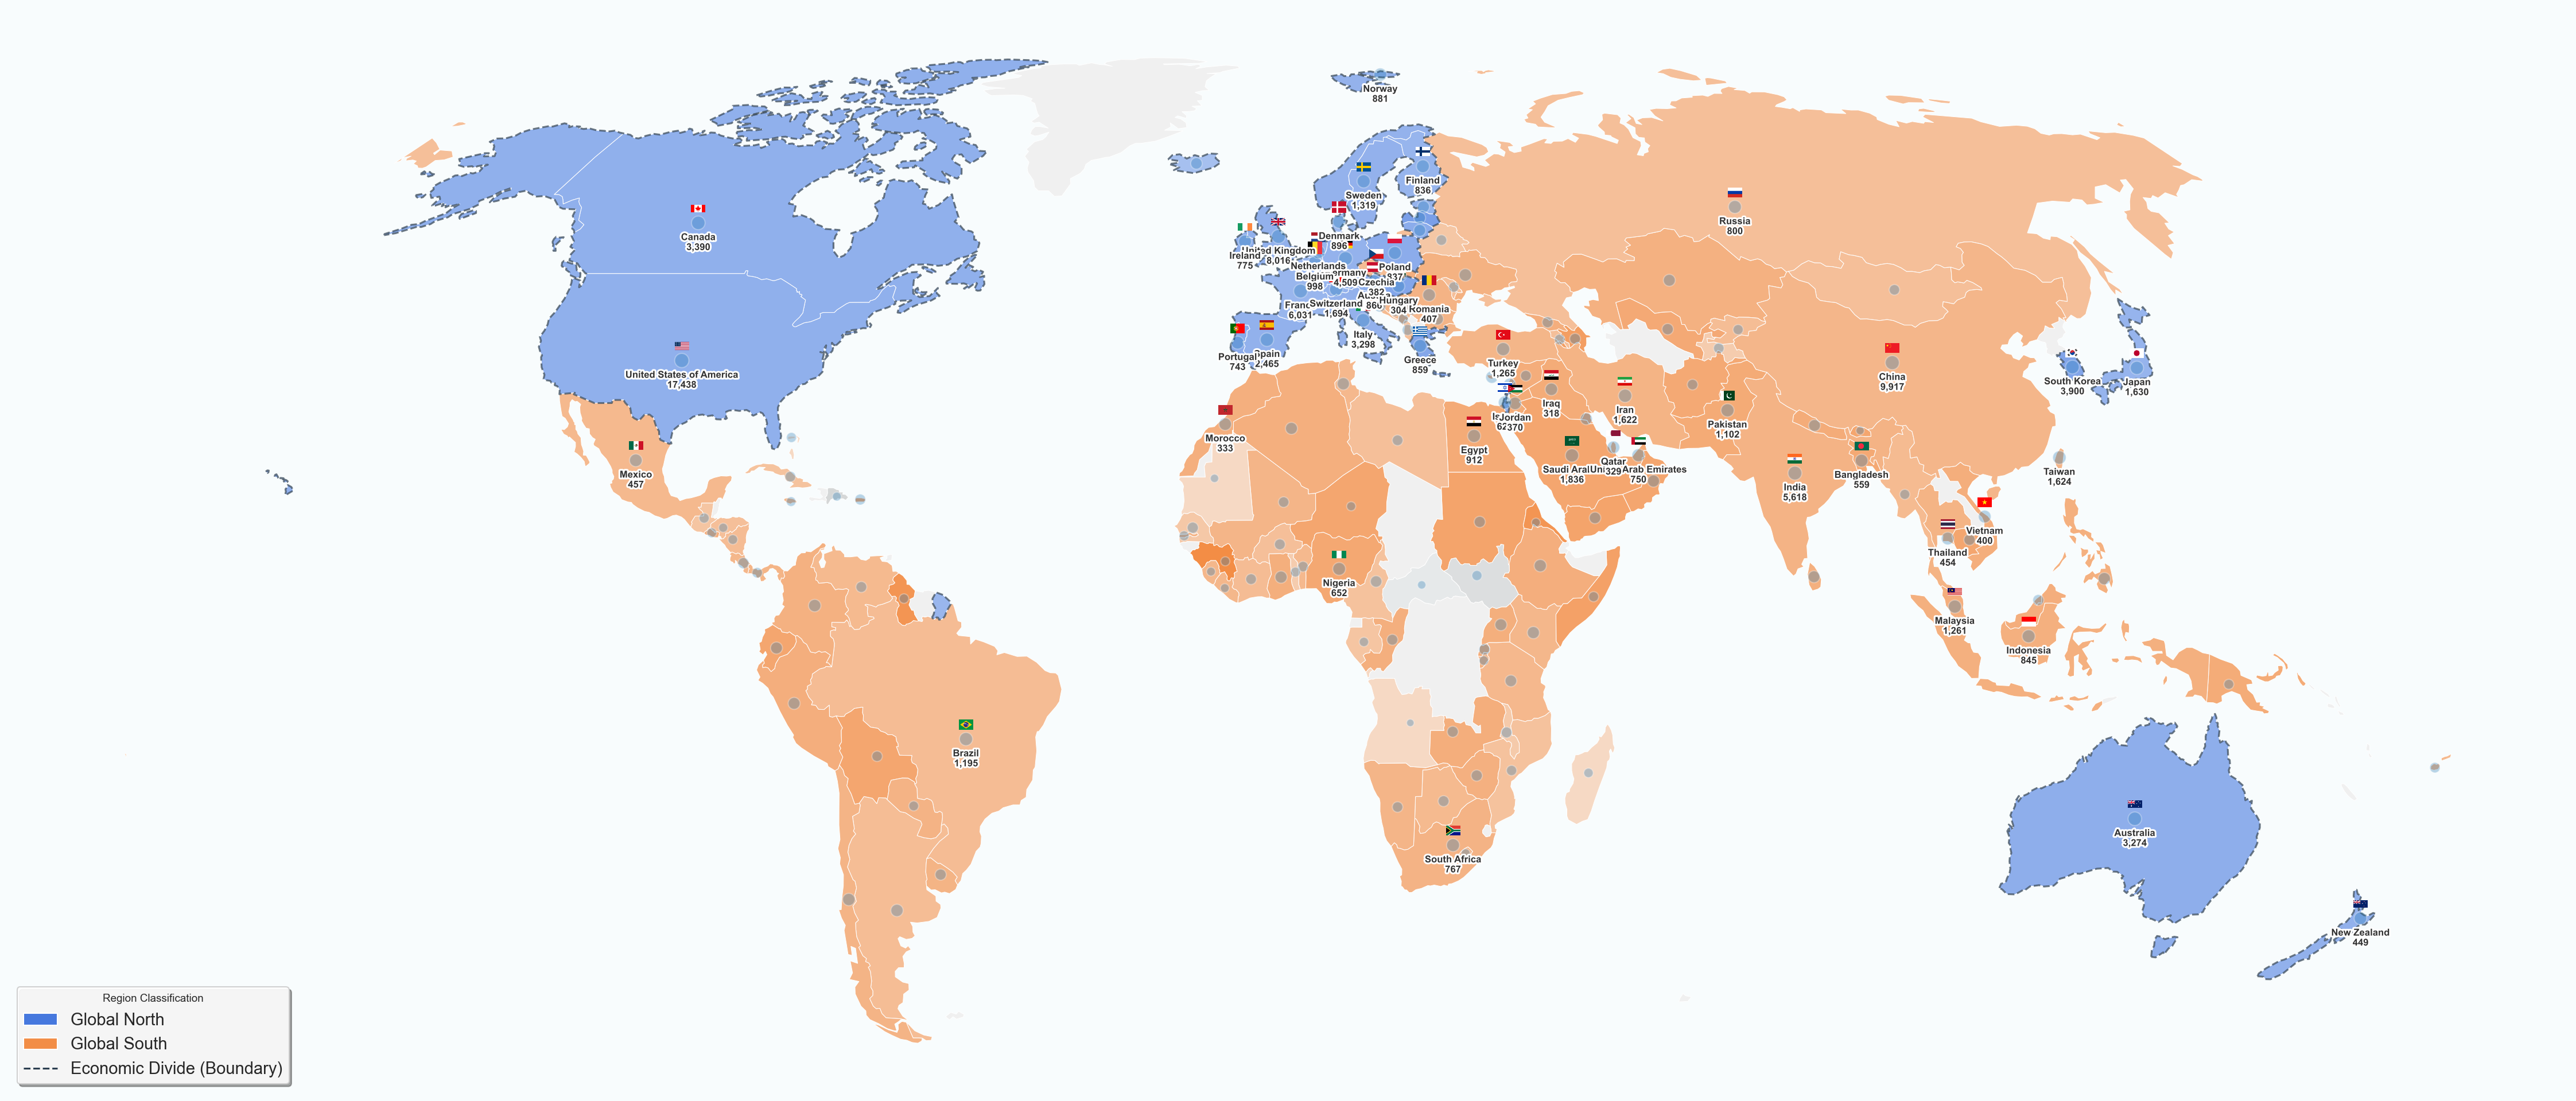

In [52]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from io import StringIO, BytesIO
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
from PIL import Image

# =========================================================
# 1) DATA LOADING
# =========================================================
data = """country,total_docs,negative_docs,neutral_docs,positive_docs
united states,17438,3249,4229,4998
china,9917,1442,2014,3369
united kingdom,8016,1659,1928,2218
france,6031,1226,2651,1436
india,5618,831,972,2099
germany,4509,849,1217,1209
canada,3390,671,794,987
italy,3298,655,825,898
australia,3274,663,674,976
spain,2465,496,629,684
netherlands,2267,478,559,548
republic of,1956,312,453,727
korea,1944,309,447,724
saudi arabia,1836,297,269,917
switzerland,1694,336,480,452
japan,1630,241,435,410
sweden,1319,263,342,361
turkey,1265,190,295,437
malaysia,1261,198,216,530
brazil,1195,212,304,341
pakistan,1102,177,192,501
singapore,1096,195,243,348
hong kong,1065,167,213,371
belgium,998,200,262,254
egypt,912,125,174,412
denmark,896,209,246,199
norway,881,198,212,237
austria,866,163,210,252
greece,859,173,162,306
indonesia,845,125,273,341
poland,837,173,222,263
finland,836,148,195,207
taiwan,812,123,150,286
province of china,812,123,150,286
islamic republic of,811,122,127,298
iran,811,122,127,298
russian federation,800,194,224,201
ireland,775,164,186,232
south africa,767,153,153,284
united arab emirates,750,126,129,330
portugal,743,140,169,246
nigeria,652,126,112,314
israel,625,103,165,175
bangladesh,559,83,98,263
mexico,457,86,92,144
thailand,454,88,105,166
new zealand,449,90,114,126
romania,407,91,93,151
viet nam,400,64,75,169
czech republic,382,77,94,104
jordan,370,77,64,165
morocco,333,46,68,136
qatar,329,70,55,114
iraq,318,56,68,141
hungary,304,65,83,111
ukraine,297,68,67,116
colombia,271,47,61,106
chile,252,40,62,91
ethiopia,236,42,47,99
argentina,229,50,59,63
philippines,225,33,42,91
tunisia,201,39,41,65
slovenia,186,31,49,59
croatia,185,35,47,55
lebanon,185,37,39,69
serbia,180,33,56,55
cyprus,177,29,38,66
kenya,175,42,40,59
ghana,165,29,36,68
oman,150,18,17,75
slovakia,146,34,35,59
luxembourg,144,25,43,54
algeria,141,20,32,58
bulgaria,139,32,29,50
estonia,132,23,24,33
lithuania,128,22,29,41
peru,122,28,15,51
kazakhstan,120,22,29,47
uganda,118,32,17,49
ecuador,115,14,21,57
sri lanka,107,13,22,43
kuwait,105,17,16,49
nepal,100,19,20,44
tanzania,80,22,16,26
latvia,80,12,19,34
yemen,69,12,13,36
bahrain,67,7,8,38
iceland,64,17,15,10
cameroon,58,16,18,13
uzbekistan,45,5,10,21
north macedonia,45,8,9,16
cambodia,44,9,5,22
malta,41,9,8,16
zimbabwe,40,11,10,16
sudan,40,5,8,21
uruguay,38,7,7,14
senegal,36,10,15,6
costa rica,33,4,10,11
zambia,33,12,4,14
bosnia and herzegovina,32,7,6,11
rwanda,31,5,4,14
georgia,31,6,6,13
brunei darussalam,28,6,5,11
albania,28,8,3,7
congo,27,7,6,11
venezuela,26,6,8,8
malawi,26,9,11,4
botswana,26,2,9,8
azerbaijan,26,2,5,15
burkina faso,24,6,8,6
puerto rico,23,2,3,11
syrian arab republic,21,5,6,9
cote d'ivoire,21,5,6,6
libya,20,5,6,5
afghanistan,19,3,6,9
cuba,18,0,5,4
mali,17,3,5,6
namibia,17,4,2,6
belarus,17,5,6,3
armenia,16,3,6,4
mongolia,16,4,5,4
tajikistan,16,10,2,2
bolivia,16,3,1,8
benin,16,3,4,5
panama,14,3,5,5
mozambique,13,4,2,3
fiji,13,0,4,4
moldova,12,3,6,3
mauritius,12,3,3,3
kyrgyzstan,11,4,1,3
somalia,11,3,0,6
myanmar,10,5,0,3
guatemala,10,1,4,2
montenegro,10,3,1,4
south sudan,10,3,3,2
trinidad and tobago,9,1,2,3
papua new guinea,9,2,1,4
bahamas,9,1,0,0
togo,8,3,2,1
maldives,8,2,1,4
paraguay,8,2,1,3
gambia,8,1,1,3
nicaragua,7,1,2,2
el salvador,7,1,0,3
guyana,6,1,1,4
jamaica,6,4,0,2
madagascar,5,2,2,0
burundi,5,1,2,2
gabon,5,1,2,1
honduras,4,1,1,1
guinea,4,0,1,3
niger,4,1,1,2
sierra leone,3,1,0,1
eswatini,3,0,0,2
eritrea,3,1,0,2
lesotho,3,0,0,1
dominican republic,3,0,1,1
liberia,3,0,1,1
mauritania,2,0,1,0
bhutan,2,0,1,1
central african republic,2,0,1,0
angola,1,1,0,0
"""
df = pd.read_csv(StringIO(data))

# =========================================================
# 2) LISTS (NORTH / SOUTH)
# =========================================================
GLOBAL_NORTH_NAMES = {
    "Australia","Austria","Belgium","Canada","Denmark","Estonia","Finland","France",
    "Germany","Greece","Hungary","Iceland","Ireland","Israel","Italy","Japan",
    "Korea, Republic of (South Korea)","Latvia","Liechtenstein","Lithuania",
    "Luxembourg","Monaco","Netherlands","New Zealand","Norway","Poland","Portugal",
    "San Marino","Slovenia","Spain","Sweden","Switzerland","United Kingdom",
    "United States",
}
GLOBAL_SOUTH_NAMES = {
    "Afghanistan","Albania","Algeria","Andorra","Angola","Anguilla",
    "Antigua and Barbuda","Argentina","Armenia","Aruba","Azerbaijan","Bahamas",
    "Bahrain","Bangladesh","Barbados","Belarus","Belize","Benin","Bhutan","Bolivia",
    "Bosnia and Herzegovina","Botswana","Brazil","Brunei Darussalam","Bulgaria",
    "Burkina Faso","Burundi","Cambodia","Cameroon","Cape Verde",
    "Central African Republic","Chad","Channel Islands","Chile","China",
    "China, Macao SAR","Colombia","Comoros","Congo","Congo, Democratic Republic of the",
    "Costa Rica","Côte d’Ivoire","Croatia","Cuba","Cyprus","Czech Republic","Djibouti",
    "Dominica","Dominican Republic","Ecuador","Egypt","El Salvador","Equatorial Guinea",
    "Eritrea","Ethiopia","Fiji","French Guiana","French Polynesia","Gabon","Gambia",
    "Georgia","Ghana","Grenada","Guadeloupe","Guam","Guatemala","Guinea",
    "Guinea-Bissau","Guyana","Haiti","Honduras","Hong Kong","India","Indonesia",
    "Iran (Islamic Republic of)","Iraq","Jamaica","Jordan","Kazakhstan","Kenya",
    "Kiribati","Korea, Democratic People’s Republic of (North Korea)","Kuwait",
    "Kyrgyzstan","Lao PDR","Lebanon","Lesotho","Liberia","Libya","Madagascar","Malawi",
    "Malaysia","Maldives","Mali","Malta","Marshall Islands","Martinique","Mauritania",
    "Mauritius","Mayotte","Mexico","Micronesia (Federated States of)","Mongolia",
    "Montenegro","Morocco","Mozambique","Myanmar","Namibia","Nauru","Nepal",
    "Netherlands Antilles","New Caledonia","Nicaragua","Niger","Nigeria","Oman",
    "Pakistan","Palau","Palestinian Territory, Occupied","Panama","Papua New Guinea",
    "Paraguay","Peru","Philippines","Puerto Rico","Qatar","Republic of Moldova",
    "Réunion","Romania","Russian Federation","Rwanda","Saint Kitts and Nevis",
    "Saint Lucia","Saint Vincent and the Grenadines","Samoa","Sao Tome and Principe",
    "Saudi Arabia","Senegal","Serbia","Seychelles","Sierra Leone","Singapore",
    "Slovakia","Solomon Islands","Somalia","South Africa","South Sudan","Sri Lanka",
    "Sudan","Suriname","Swaziland (Eswatini)","Syrian Arab Republic","Taiwan",
    "Tajikistan","Tanzania","Thailand",
    "The former Yugoslav Republic of Macedonia (North Macedonia)","Timor-Leste","Togo",
    "Tonga","Trinidad and Tobago","Tunisia","Turkey","Turkmenistan","Tuvalu","Uganda",
    "Ukraine","United Arab Emirates","Uruguay","Uzbekistan","Vanuatu","Venezuela",
    "Viet Nam","Virgin Islands","Western Sahara","Yemen","Zambia","Zimbabwe",
}

# =========================================================
# 3) NORMALIZE NAMES
# =========================================================
NE_NAME_FIX = {
    "United States": "United States of America",
    "Russian Federation": "Russia",
    "Viet Nam": "Vietnam",
    "Czech Republic": "Czechia",
    "Syrian Arab Republic": "Syria",
    "Iran (Islamic Republic of)": "Iran",
    "Korea, Republic of (South Korea)": "South Korea",
    "Korea, Democratic People’s Republic of (North Korea)": "North Korea",
    "Congo, Democratic Republic of the": "Dem. Rep. Congo",
    "Brunei Darussalam": "Brunei",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "The former Yugoslav Republic of Macedonia (North Macedonia)": "Macedonia",
    "Côte d’Ivoire": "Côte d'Ivoire",
    "Republic of Moldova": "Moldova",
    "Swaziland (Eswatini)": "Eswatini",
    "Palestinian Territory, Occupied": "Palestine",
}
def to_ne_name(name: str) -> str:
    name = str(name).strip()
    return NE_NAME_FIX.get(name, name)

GN_NE = {to_ne_name(x) for x in GLOBAL_NORTH_NAMES}
GS_NE = {to_ne_name(x) for x in GLOBAL_SOUTH_NAMES}

df["country"] = df["country"].astype(str).str.strip().str.lower()
input_name_map = {
    "united states": "United States of America",
    "united kingdom": "United Kingdom",
    "korea": "South Korea",
    "republic of": "South Korea",
    "russian federation": "Russia",
    "islamic republic of": "Iran",
    "iran": "Iran",
    "province of china": "Taiwan",
    "taiwan": "Taiwan",
    "viet nam": "Vietnam",
    "czech republic": "Czechia",
    "syrian arab republic": "Syria",
    "brunei darussalam": "Brunei",
    "congo": "Congo",
    "bosnia and herzegovina": "Bosnia and Herz.",
    "north macedonia": "Macedonia",
    "cote d'ivoire": "Côte d'Ivoire",
    "dominican republic": "Dominican Rep.",
    "central african republic": "Central African Rep.",
    "south sudan": "S. Sudan",
}
df["mapped_name"] = df["country"].map(input_name_map).fillna(df["country"].str.title())

# Aggregate stats
df_agg = (
    df.groupby("mapped_name")[["total_docs", "positive_docs", "negative_docs", "neutral_docs"]]
      .sum()
      .reset_index()
)
df_agg["positivity_ratio"] = df_agg["positive_docs"] / df_agg["total_docs"].replace(0, np.nan)
df_agg["positivity_ratio"] = df_agg["positivity_ratio"].fillna(0)

# =========================================================
# 4) GEOPROCESSING
# =========================================================
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world.columns = world.columns.str.lower()
# Ensure we keep ISO codes for flags
world = world[["name", "geometry", "iso_a2"]].copy()
world = world[world["name"] != "Antarctica"].copy()

# Merge Data
world = world.merge(df_agg, left_on="name", right_on="mapped_name", how="left")

def classify_region(ne_country_name: str) -> str:
    if ne_country_name in GN_NE: return "Global North"
    if ne_country_name in GS_NE: return "Global South"
    return "Unknown"

world["region"] = world["name"].apply(classify_region)
world["total_docs"] = world["total_docs"].fillna(0)
world["positivity_ratio"] = world["positivity_ratio"].fillna(0)

# Projection
world = world.to_crs("ESRI:54030")

# =========================================================
# 5) SETUP PLOT DATA
# =========================================================
# Bubble size
world["bubble_size"] = np.sqrt(np.log1p(world["total_docs"])) * 45

# Centroids for plotting
world["pt"] = world.geometry.representative_point()
world["x"] = world["pt"].x
world["y"] = world["pt"].y

# Colors
def rgba_for_row(region: str, ratio: float, has_data: bool):
    if not has_data: return "#f0f0f0"
    a = 0.25 + (float(ratio) * 0.75)
    a = min(max(a, 0.25), 1.0)
    if region == "Global North": return (0.10, 0.35, 0.85, a) # Deep Blue
    if region == "Global South": return (0.95, 0.45, 0.10, a) # Deep Orange
    return (0.7, 0.7, 0.7, a)

has_data = ~world["mapped_name"].isna()
world["fill"] = [rgba_for_row(r, pr, hd) for r, pr, hd in zip(world["region"], world["positivity_ratio"], has_data)]

# Top 50
topN = world.sort_values("total_docs", ascending=False).head(50).copy()

# =========================================================
# 6) HELPER: FETCH FLAGS
# =========================================================
flag_cache = {}

def get_flag_img(iso_code, zoom=0.07):
    """Downloads flag from flagcdn and returns an OffsetImage."""
    if not iso_code or pd.isna(iso_code):
        return None
    
    code = str(iso_code).lower()
    if code in flag_cache:
        return OffsetImage(flag_cache[code], zoom=zoom)
    
    url = f"https://flagcdn.com/w80/{code}.png"
    try:
        with urllib.request.urlopen(url) as response:
            data = response.read()
            img = plt.imread(BytesIO(data), format="png")
            flag_cache[code] = img
            return OffsetImage(img, zoom=zoom)
    except Exception as e:
        # Fallback if flag fails
        return None

# =========================================================
# 7) PLOT
# =========================================================
fig, ax = plt.subplots(1, 1, figsize=(30, 18), facecolor="#f8fcfd")
ax.set_facecolor("#eef9ff") # Light ocean

# A) DRAW THE REGIONS
world.plot(ax=ax, color=world["fill"], edgecolor="white", linewidth=0.5, zorder=1)

# B) SEPARATION LINE (The "Interesting Way")
# We dissolve the geometries of the Global North to find the precise boundary
try:
    # Simplify geometries slightly to smooth the line
    north_geom = world[world['region'] == 'Global North'].dissolve().geometry.simplify(5000)
    # Plot the boundary of the North
    north_geom.boundary.plot(
        ax=ax, 
        edgecolor="#2c3e50", 
        linewidth=1.5, 
        linestyle="--", 
        alpha=0.7, 
        zorder=2
    )
    # Add a phantom line for the legend
    ax.plot([], [], color="#2c3e50", linestyle="--", linewidth=1.5, label="North-South Divide")
except Exception as e:
    print("Could not compute separation line automatically:", e)

# C) BUBBLES
bubble_mask = world["total_docs"] > 0
ax.scatter(
    world.loc[bubble_mask, "x"],
    world.loc[bubble_mask, "y"],
    s=world.loc[bubble_mask, "bubble_size"],
    alpha=0.3,
    linewidths=1,
    edgecolors="white",
    zorder=3
)

# D) FLAGS & LABELS (TOP 50)
print("Fetching flags for Top 50 (this may take a moment)...")

texts = []
outline = [pe.withStroke(linewidth=3, foreground="white")]

for i, r in topN.iterrows():
    if pd.isna(r["x"]) or pd.isna(r["y"]):
        continue
        
    # 1. Place Flag (if available)
    if r["iso_a2"] != "-99": # Natural earth nan code
        img_box = get_flag_img(r["iso_a2"], zoom=0.15) # Zoom adjusts flag size
        if img_box:
            # Shift flag slightly up from centroid
            ab = AnnotationBbox(
                img_box, 
                (r["x"], r["y"]),
                xybox=(0, 12), # offset 12 points up
                xycoords='data',
                boxcoords="offset points",
                frameon=False,
                zorder=5
            )
            ax.add_artist(ab)
    
    # 2. Place Text (Name + count)
    # Shift text slightly down so it doesn't overlap flag
    t = ax.text(
        r["x"], r["y"],
        f"{r['name']}\n{int(r['total_docs']):,}",
        fontsize=8,
        fontweight="bold",
        color="#333333",
        ha="center", va="top",
        path_effects=outline,
        zorder=6
    )
    
    # Adjust position slightly down based on bubble size to clear the flag
    # (Simple heuristic adjustment)
    t.set_position((r["x"], r["y"] - 150000)) 

# E) TITLES & LEGEND
#ax.set_title(
  #  "Global AI Research Landscape: The North-South Divide\n"
   # "Top 50 Countries by Output volume with Sentiment Analysis",
   # fontsize=24, fontweight="bold", pad=20, color="#2c3e50"
#)

# Custom Legend
legend_elements = [
    Patch(facecolor=(0.10, 0.35, 0.85, 0.8), edgecolor="white", label="Global North"),
    Patch(facecolor=(0.95, 0.45, 0.10, 0.8), edgecolor="white", label="Global South"),
    plt.Line2D([0], [0], color='#2c3e50', lw=1.5, linestyle='--', label='Economic Divide (Boundary)'),
]
ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=14,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    shadow=True,
    title="Region Classification"
)

ax.axis("off")
plt.tight_layout()

# Save
plt.savefig("global_north_south_flags.png", dpi=300, bbox_inches="tight")
print("Done! Saved as 'global_north_south_flags.png'")
plt.show()

# Sentiment Analysis


##### Sentiment text preparation

In [8]:
# =========================================================
# STEP 12: Prepare sentiment text (title + abstract)
# Output: sentiment_ready.csv per dataset
# =========================================================

import pandas as pd
import numpy as np
import re
from pathlib import Path

ROOT = Path(r"E:\sentiment_AI\ai_research_productivity")
DATA_PROCESSED = ROOT / "data_processed"
NORM_DIR = DATA_PROCESSED / "usable_normalized"
OUT_DIR = DATA_PROCESSED / "sentiment_ready"

OUT_DIR.mkdir(exist_ok=True)

STANDARD_COLS = [
    "source","_id","doi","title","abstract","publication_year","publication_date",
    "type","venue","is_open_access","cited_by_count","countries","global_region",
    "discipline_group","query_ai_term","query_other_term","lang"
]

def clean_text(s: str) -> str:
    s = str(s or "")
    s = s.replace("\u0000", " ")
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def build_sentiment_text(row):
    t = clean_text(row["title"])
    a = clean_text(row["abstract"])
    if t and a:
        return f"{t}. {a}"
    return t or a

dataset_dirs = sorted([p for p in NORM_DIR.iterdir() if p.is_dir()])

summary = []

for ddir in dataset_dirs:
    ds = ddir.name
    inp = ddir / "usable_normalized.csv"
    if not inp.exists():
        continue

    df = pd.read_csv(inp, low_memory=False).replace({np.nan:""})

    for c in STANDARD_COLS:
        if c not in df.columns:
            df[c] = ""

    df = df[STANDARD_COLS]

    df["sentiment_text"] = df.apply(build_sentiment_text, axis=1)
    df["sentiment_text_len"] = df["sentiment_text"].str.len()

    # Remove empty sentiment rows
    before = len(df)
    df = df[df["sentiment_text_len"] >= 20].copy()
    after = len(df)

    out_ds = OUT_DIR / ds
    out_ds.mkdir(parents=True, exist_ok=True)

    out_path = out_ds / "sentiment_ready.csv"
    df.to_csv(out_path, index=False, encoding="utf-8")

    summary.append({
        "dataset": ds,
        "rows_before": before,
        "rows_after_nonempty": after,
        "output": str(out_path)
    })

summary_df = pd.DataFrame(summary)
summary_path = DATA_PROCESSED / "step12_sentiment_prep_summary.csv"
summary_df.to_csv(summary_path, index=False, encoding="utf-8")

print("Saved sentiment-ready files.")
print("Summary:", summary_path)
summary_df


Saved sentiment-ready files.
Summary: E:\sentiment_AI\ai_research_productivity\data_processed\step12_sentiment_prep_summary.csv


dataset  rows_before  rows_after_nonempty  \
0            biorxiv_raw_standard_format           84                   84   
1           crossref_raw_openalex_format        11217                11023   
2                           datacite_raw          199                  199   
3               dblp_raw_standard_format         5638                 5622   
4               doaj_raw_openalex_format         6856                 6856   
5                hal_raw_standard_format         8487                 8487   
6            medrxiv_raw_standard_format          193                  193   
7                           openalex_raw        31899                31878   
8             pubmed_raw_openalex_format         9679                 9673   
9                scholar_openalex_format           20                   20   
10  semantic_scholar_raw_openalex_format         3937                 3935   

                                               output  
0   E:\sentiment_AI\ai_research_productivity\data_...  
1   E:\sentiment_AI\ai_research_productivity\data_...  
2   E:\sentiment_AI\ai_research_productivity\data_...  
3   E:\sentiment_AI\ai_research_productivity\data_...  
4   E:\sentiment_AI\ai_research_productivity\data_...  
5   E:\sentiment_AI\ai_research_productivity\data_...  
6   E:\sentiment_AI\ai_research_productivity\data_...  
7   E:\sentiment_AI\ai_research_productivity\data_...  
8   E:\sentiment_AI\ai_research_productivity\data_...  
9   E:\sentiment_AI\ai_research_productivity\data_...  
10  E:\sentiment_AI\ai_research_productivity\data_...

In [9]:
# =========================================================
# STEP 13: Sentiment scoring with VADER (no PyTorch)
# Install once:
#   pip install vaderSentiment
# =========================================================

import pandas as pd
import numpy as np
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ROOT = Path(r"E:\sentiment_AI\ai_research_productivity")
DATA_PROCESSED = ROOT / "data_processed"

IN_DIR = DATA_PROCESSED / "sentiment_ready"
OUT_DIR = DATA_PROCESSED / "sentiment_scored"
OUT_DIR.mkdir(exist_ok=True)

analyzer = SentimentIntensityAnalyzer()

STANDARD_COLS = [
    "source","_id","doi","title","abstract","publication_year","publication_date",
    "type","venue","is_open_access","cited_by_count","countries","global_region",
    "discipline_group","query_ai_term","query_other_term","lang"
]

SENT_COLS = [
    "sent_compound","sent_pos","sent_neu","sent_neg","sent_label"
]

def label_from_compound(c: float) -> str:
    # Standard VADER thresholds
    if c >= 0.05:
        return "positive"
    if c <= -0.05:
        return "negative"
    return "neutral"

def score_one(text: str):
    vs = analyzer.polarity_scores(str(text or ""))
    c = float(vs.get("compound", 0.0))
    return (
        c,
        float(vs.get("pos", 0.0)),
        float(vs.get("neu", 0.0)),
        float(vs.get("neg", 0.0)),
        label_from_compound(c),
    )

def ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    for c in STANDARD_COLS:
        if c not in df.columns:
            df[c] = ""
    if "sentiment_text" not in df.columns:
        df["sentiment_text"] = (df["title"].astype(str) + ". " + df["abstract"].astype(str)).fillna("")
    return df

dataset_dirs = sorted([p for p in IN_DIR.iterdir() if p.is_dir()])
summary = []

for ddir in dataset_dirs:
    ds = ddir.name
    inp = ddir / "sentiment_ready.csv"
    if not inp.exists():
        continue

    df = pd.read_csv(inp, low_memory=False).replace({np.nan:""})
    df = ensure_cols(df)

    # Score
    scores = df["sentiment_text"].astype(str).apply(score_one)
    scores_df = pd.DataFrame(scores.tolist(), columns=SENT_COLS)

    out = pd.concat([df, scores_df], axis=1)

    # Save
    out_ds = OUT_DIR / ds
    out_ds.mkdir(parents=True, exist_ok=True)
    out_path = out_ds / "sentiment_scored.csv"
    out.to_csv(out_path, index=False, encoding="utf-8")

    # Summary counts (no interpretation, just counts)
    vc = out["sent_label"].value_counts(dropna=False).to_dict()
    summary.append({
        "dataset": ds,
        "rows_scored": len(out),
        "positive": int(vc.get("positive", 0)),
        "neutral": int(vc.get("neutral", 0)),
        "negative": int(vc.get("negative", 0)),
        "output": str(out_path)
    })

summary_df = pd.DataFrame(summary).sort_values("rows_scored", ascending=False)
summary_path = DATA_PROCESSED / "step13_sentiment_score_summary.csv"
summary_df.to_csv(summary_path, index=False, encoding="utf-8")

print("Saved sentiment-scored files under:", OUT_DIR)
print("Saved summary:", summary_path)

summary_df


Saved sentiment-scored files under: E:\sentiment_AI\ai_research_productivity\data_processed\sentiment_scored
Saved summary: E:\sentiment_AI\ai_research_productivity\data_processed\step13_sentiment_score_summary.csv


dataset  rows_scored  positive  neutral  \
7                           openalex_raw        31878     24212     3745   
1           crossref_raw_openalex_format        11023      6447     2987   
8             pubmed_raw_openalex_format         9673      7568      429   
5                hal_raw_standard_format         8487      6996      378   
4               doaj_raw_openalex_format         6856      5769       74   
3               dblp_raw_standard_format         5622      3287     1899   
10  semantic_scholar_raw_openalex_format         3935      3311      232   
2                           datacite_raw          199       178        4   
6            medrxiv_raw_standard_format          193       143        2   
0            biorxiv_raw_standard_format           84        65        4   
9                scholar_openalex_format           20        18        2   

    negative                                             output  
7       3921  E:\sentiment_AI\ai_research_productivity\data_...  
1       1589  E:\sentiment_AI\ai_research_productivity\data_...  
8       1676  E:\sentiment_AI\ai_research_productivity\data_...  
5       1113  E:\sentiment_AI\ai_research_productivity\data_...  
4       1013  E:\sentiment_AI\ai_research_productivity\data_...  
3        436  E:\sentiment_AI\ai_research_productivity\data_...  
10       392  E:\sentiment_AI\ai_research_productivity\data_...  
2         17  E:\sentiment_AI\ai_research_productivity\data_...  
6         48  E:\sentiment_AI\ai_research_productivity\data_...  
0         15  E:\sentiment_AI\ai_research_productivity\data_...  
9          0  E:\sentiment_AI\ai_research_productivity\data_...

In [16]:
# =========================================================
# STEP 14 (FIXED): Aggregate sentiment results for visualization
# Guarantees ALL datasets appear (even if 0 rows) with zero-filled counts
# (no analysis/interpretation; just produce plot-ready tables)
# =========================================================

import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path(r"E:\sentiment_AI\ai_research_productivity")
DATA_PROCESSED = ROOT / "data_processed"
IN_DIR = DATA_PROCESSED / "sentiment_scored"

OUT1 = DATA_PROCESSED / "step14_sentiment_by_dataset.csv"
OUT2 = DATA_PROCESSED / "step14_sentiment_by_dataset_region.csv"
OUT3 = DATA_PROCESSED / "step14_sentiment_by_dataset_discipline.csv"
OUT4 = DATA_PROCESSED / "step14_sentiment_by_region_overall.csv"
OUT5 = DATA_PROCESSED / "step14_sentiment_by_discipline_overall.csv"

# ---- AUTHORITATIVE dataset list (must match your expected names) ----
ALL_DATASETS = [
    "SemanticScholar",
    "biorxiv",
    "crossref",
    "datacite",
    "dblp",
    "doaj",
    "hal",
    "medrxiv",
    "openalex",
    "pubmed",
    "scholar",
]

def short_name(x: str) -> str:
    x = str(x)
    x = x.replace("_raw_openalex_format", "")
    x = x.replace("_raw_standard_format", "")
    x = x.replace("_raw", "")
    x = x.replace("_openalex_format", "")
    x = x.replace("_standard_format", "")
    x = x.replace("semantic_scholar", "SemanticScholar")
    x = x.replace("scholar_openalex_format", "scholar")  # <-- FIX: keep as 'scholar'
    x = x.replace("GoogleScholar", "scholar")            # safety
    return x

def safe_cat(s: pd.Series, default="Unknown") -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.replace({"": default})
    return s

def pct_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in ["positive", "neutral", "negative"]:
        out[f"{c}_pct"] = (out[c] / out["total"].replace(0, np.nan) * 100).fillna(0)
    return out

def ensure_sent_cols(wide: pd.DataFrame, idx_cols):
    # Make sure label columns exist
    for col in ["positive", "neutral", "negative"]:
        if col not in wide.columns:
            wide[col] = 0
    wide["total"] = wide["positive"] + wide["neutral"] + wide["negative"]
    wide = pct_cols(wide)
    # enforce column order (index cols + counts + pcts)
    ordered = idx_cols + ["negative","neutral","positive","total",
                          "negative_pct","neutral_pct","positive_pct"]
    # some users prefer positive/neutral/negative; keeping your original wide output style is OK.
    # We'll keep above ordering for stable output.
    for c in ordered:
        if c not in wide.columns:
            wide[c] = 0
    return wide[ordered]

# Load scored data
rows = []
dataset_dirs = sorted([p for p in IN_DIR.iterdir() if p.is_dir()])

for ddir in dataset_dirs:
    ds = short_name(ddir.name)
    p = ddir / "sentiment_scored.csv"
    if not p.exists():
        continue
    df = pd.read_csv(p, low_memory=False).replace({np.nan:""})
    keep = ["sent_label", "global_region", "discipline_group"]
    for c in keep:
        if c not in df.columns:
            df[c] = ""
    df["dataset"] = ds
    df["sent_label"] = safe_cat(df["sent_label"], default="Unknown")
    df["global_region"] = safe_cat(df["global_region"], default="Unknown")
    df["discipline_group"] = safe_cat(df["discipline_group"], default="Unknown")
    rows.append(df[["dataset","sent_label","global_region","discipline_group"]])

all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
    columns=["dataset","sent_label","global_region","discipline_group"]
)

# Helper: enforce all datasets for any table that has dataset column
def enforce_all_datasets_on_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    present = set(df["dataset"].astype(str).unique())
    missing = [d for d in ALL_DATASETS if d not in present]
    if missing:
        # create minimal zero rows (dataset-level). For multi-index tables we won't use this.
        zeros = []
        for ds in missing:
            zeros.append({"dataset": ds, "positive": 0, "neutral": 0, "negative": 0, "total": 0,
                          "positive_pct": 0.0, "neutral_pct": 0.0, "negative_pct": 0.0})
        df = pd.concat([df, pd.DataFrame(zeros)], ignore_index=True)
    # dataset ordering
    df["dataset"] = pd.Categorical(df["dataset"], categories=ALL_DATASETS, ordered=True)
    return df.sort_values("dataset").reset_index(drop=True)

# =========================================================
# A) By dataset  (force all datasets)
# =========================================================
by_ds = (
    all_df.groupby(["dataset","sent_label"], as_index=False)
          .size()
          .rename(columns={"size":"n"})
)
wide_ds = by_ds.pivot_table(index="dataset", columns="sent_label", values="n", fill_value=0).reset_index()

# standardize sentiment columns
wide_ds = ensure_sent_cols(wide_ds, ["dataset"])

# force all datasets (even missing)
wide_ds = enforce_all_datasets_on_table(wide_ds)

wide_ds.to_csv(OUT1, index=False, encoding="utf-8")

# =========================================================
# B) By dataset x region
# We include zero rows for missing datasets by adding an "Unknown" region row.
# =========================================================
by_ds_reg = (
    all_df.groupby(["dataset","global_region","sent_label"], as_index=False)
          .size()
          .rename(columns={"size":"n"})
)

wide_ds_reg = (
    by_ds_reg.pivot_table(index=["dataset","global_region"], columns="sent_label", values="n", fill_value=0)
             .reset_index()
)
wide_ds_reg = ensure_sent_cols(wide_ds_reg, ["dataset","global_region"])

# add missing datasets with global_region="Unknown"
present_ds = set(wide_ds_reg["dataset"].astype(str).unique())
missing_ds = [d for d in ALL_DATASETS if d not in present_ds]
if missing_ds:
    add = pd.DataFrame([{
        "dataset": d, "global_region": "Unknown",
        "negative": 0, "neutral": 0, "positive": 0, "total": 0,
        "negative_pct": 0.0, "neutral_pct": 0.0, "positive_pct": 0.0
    } for d in missing_ds])
    wide_ds_reg = pd.concat([wide_ds_reg, add], ignore_index=True)

wide_ds_reg["dataset"] = pd.Categorical(wide_ds_reg["dataset"], categories=ALL_DATASETS, ordered=True)
wide_ds_reg = wide_ds_reg.sort_values(["dataset","global_region"]).reset_index(drop=True)
wide_ds_reg.to_csv(OUT2, index=False, encoding="utf-8")

# =========================================================
# C) By dataset x discipline
# Add missing datasets with discipline_group="Unknown"
# =========================================================
by_ds_disc = (
    all_df.groupby(["dataset","discipline_group","sent_label"], as_index=False)
          .size()
          .rename(columns={"size":"n"})
)

wide_ds_disc = (
    by_ds_disc.pivot_table(index=["dataset","discipline_group"], columns="sent_label", values="n", fill_value=0)
              .reset_index()
)
wide_ds_disc = ensure_sent_cols(wide_ds_disc, ["dataset","discipline_group"])

present_ds = set(wide_ds_disc["dataset"].astype(str).unique())
missing_ds = [d for d in ALL_DATASETS if d not in present_ds]
if missing_ds:
    add = pd.DataFrame([{
        "dataset": d, "discipline_group": "Unknown",
        "negative": 0, "neutral": 0, "positive": 0, "total": 0,
        "negative_pct": 0.0, "neutral_pct": 0.0, "positive_pct": 0.0
    } for d in missing_ds])
    wide_ds_disc = pd.concat([wide_ds_disc, add], ignore_index=True)

wide_ds_disc["dataset"] = pd.Categorical(wide_ds_disc["dataset"], categories=ALL_DATASETS, ordered=True)
wide_ds_disc = wide_ds_disc.sort_values(["dataset","discipline_group"]).reset_index(drop=True)
wide_ds_disc.to_csv(OUT3, index=False, encoding="utf-8")

# =========================================================
# D) Overall by region (no dataset dimension)
# =========================================================
by_reg = (
    all_df.groupby(["global_region","sent_label"], as_index=False)
          .size()
          .rename(columns={"size":"n"})
)
wide_reg = by_reg.pivot_table(index="global_region", columns="sent_label", values="n", fill_value=0).reset_index()
wide_reg = ensure_sent_cols(wide_reg, ["global_region"])
wide_reg.to_csv(OUT4, index=False, encoding="utf-8")

# =========================================================
# E) Overall by discipline (no dataset dimension)
# =========================================================
by_disc = (
    all_df.groupby(["discipline_group","sent_label"], as_index=False)
          .size()
          .rename(columns={"size":"n"})
)
wide_disc = by_disc.pivot_table(index="discipline_group", columns="sent_label", values="n", fill_value=0).reset_index()
wide_disc = ensure_sent_cols(wide_disc, ["discipline_group"])
wide_disc.to_csv(OUT5, index=False, encoding="utf-8")

print("Saved:")
print(" -", OUT1)
print(" -", OUT2)
print(" -", OUT3)
print(" -", OUT4)
print(" -", OUT5)

wide_ds


Saved:
 - E:\sentiment_AI\ai_research_productivity\data_processed\step14_sentiment_by_dataset.csv
 - E:\sentiment_AI\ai_research_productivity\data_processed\step14_sentiment_by_dataset_region.csv
 - E:\sentiment_AI\ai_research_productivity\data_processed\step14_sentiment_by_dataset_discipline.csv
 - E:\sentiment_AI\ai_research_productivity\data_processed\step14_sentiment_by_region_overall.csv
 - E:\sentiment_AI\ai_research_productivity\data_processed\step14_sentiment_by_discipline_overall.csv


sent_label          dataset  negative  neutral  positive    total  \
0           SemanticScholar     392.0    232.0    3311.0   3935.0   
1                   biorxiv      15.0      4.0      65.0     84.0   
2                  crossref    1589.0   2987.0    6447.0  11023.0   
3                  datacite      17.0      4.0     178.0    199.0   
4                      dblp     436.0   1899.0    3287.0   5622.0   
5                      doaj    1013.0     74.0    5769.0   6856.0   
6                       hal    1113.0    378.0    6996.0   8487.0   
7                   medrxiv      48.0      2.0     143.0    193.0   
8                  openalex    3921.0   3745.0   24212.0  31878.0   
9                    pubmed    1676.0    429.0    7568.0   9673.0   
10                  scholar       0.0      2.0      18.0     20.0   

sent_label  negative_pct  neutral_pct  positive_pct  
0               9.961881     5.895807     84.142313  
1              17.857143     4.761905     77.380952  
2              14.415313    27.097886     58.486800  
3               8.542714     2.010050     89.447236  
4               7.755247    33.778015     58.466738  
5              14.775379     1.079347     84.145274  
6              13.114175     4.453871     82.431955  
7              24.870466     1.036269     74.093264  
8              12.300019    11.747914     75.952067  
9              17.326579     4.435025     78.238396  
10              0.000000    10.000000     90.000000

In [17]:
# =========================================================
# STEP 15: Publication-ready sentiment figures
# =========================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

ROOT = Path(r"E:\sentiment_AI\ai_research_productivity")
DATA = ROOT / "data_processed"
FIGS = DATA / "figures_sentiment"
FIGS.mkdir(exist_ok=True)

# Load Step-14 tables
ds = pd.read_csv(DATA / "step14_sentiment_by_dataset.csv")
ds_reg = pd.read_csv(DATA / "step14_sentiment_by_dataset_region.csv")
ds_disc = pd.read_csv(DATA / "step14_sentiment_by_dataset_discipline.csv")
reg_all = pd.read_csv(DATA / "step14_sentiment_by_region_overall.csv")
disc_all = pd.read_csv(DATA / "step14_sentiment_by_discipline_overall.csv")

# Consistent style
sns.set_theme(style="whitegrid", font_scale=1.1)
COLORS = {
    "positive": "#2ca02c",
    "neutral":  "#ff7f0e",
    "negative": "#d62728"
}


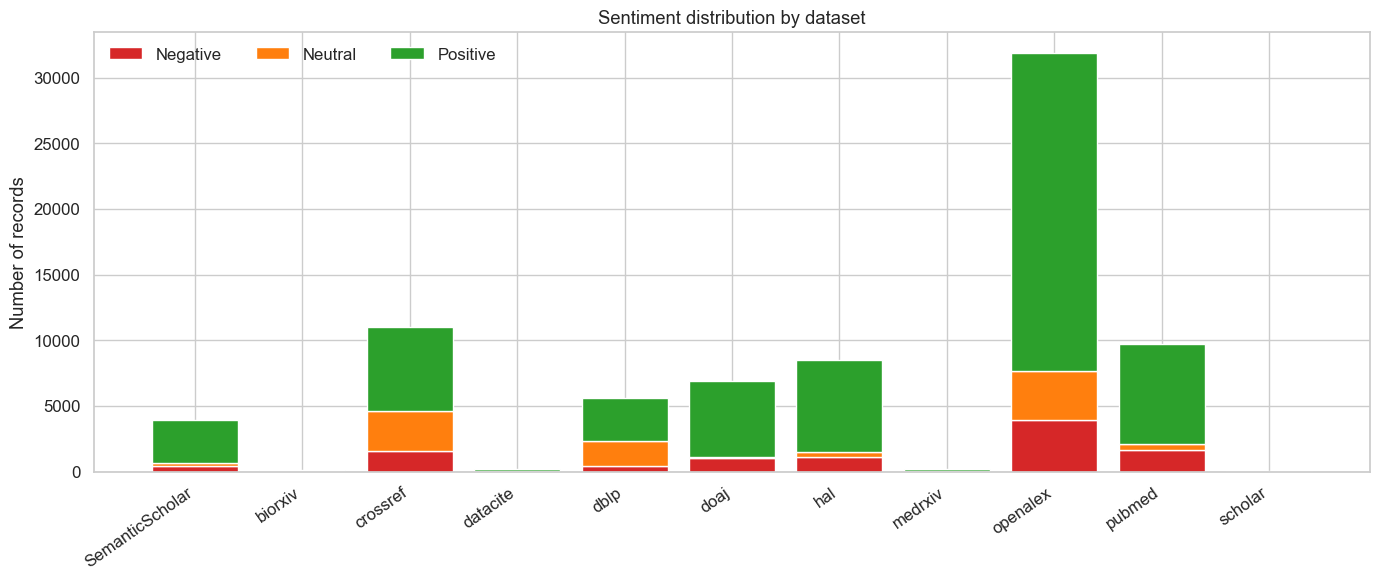

In [18]:
fig, ax = plt.subplots(figsize=(14,6))

bottom = np.zeros(len(ds))
for lab in ["negative","neutral","positive"]:
    ax.bar(
        ds["dataset"], ds[lab],
        bottom=bottom,
        label=lab.capitalize(),
        color=COLORS[lab]
    )
    bottom += ds[lab].values

ax.set_ylabel("Number of records")
ax.set_xlabel("")
ax.set_title("Sentiment distribution by dataset")
ax.legend(ncol=3, frameon=False)
plt.xticks(rotation=35, ha="right")
plt.tight_layout()

plt.savefig(FIGS / "fig1_sentiment_by_dataset_counts.png", dpi=300)
plt.savefig(FIGS / "fig1_sentiment_by_dataset_counts.svg")
plt.show()


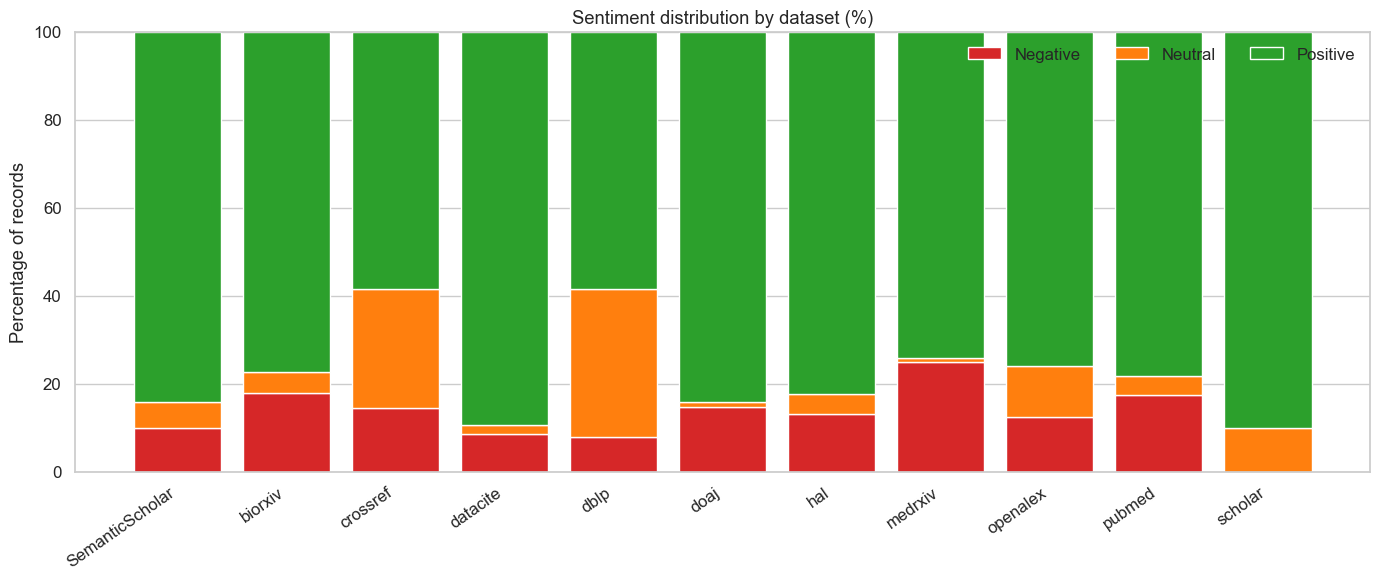

In [19]:
fig, ax = plt.subplots(figsize=(14,6))

bottom = np.zeros(len(ds))
for lab in ["negative","neutral","positive"]:
    ax.bar(
        ds["dataset"], ds[f"{lab}_pct"],
        bottom=bottom,
        label=lab.capitalize(),
        color=COLORS[lab]
    )
    bottom += ds[f"{lab}_pct"].values

ax.set_ylabel("Percentage of records")
ax.set_ylim(0,100)
ax.set_title("Sentiment distribution by dataset (%)")
ax.legend(ncol=3, frameon=False)
plt.xticks(rotation=35, ha="right")
plt.tight_layout()

plt.savefig(FIGS / "fig2_sentiment_by_dataset_percent.png", dpi=300)
plt.savefig(FIGS / "fig2_sentiment_by_dataset_percent.svg")
plt.show()


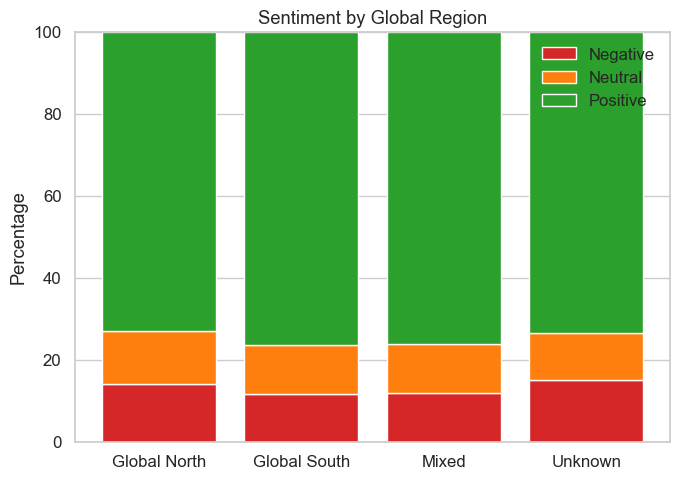

In [20]:
fig, ax = plt.subplots(figsize=(7,5))

bottom = np.zeros(len(reg_all))
for lab in ["negative","neutral","positive"]:
    ax.bar(
        reg_all["global_region"], reg_all[f"{lab}_pct"],
        bottom=bottom,
        label=lab.capitalize(),
        color=COLORS[lab]
    )
    bottom += reg_all[f"{lab}_pct"].values

ax.set_ylabel("Percentage")
ax.set_ylim(0,100)
ax.set_title("Sentiment by Global Region")
ax.legend(frameon=False)
plt.tight_layout()

plt.savefig(FIGS / "fig3_sentiment_by_region.png", dpi=300)
plt.savefig(FIGS / "fig3_sentiment_by_region.svg")
plt.show()


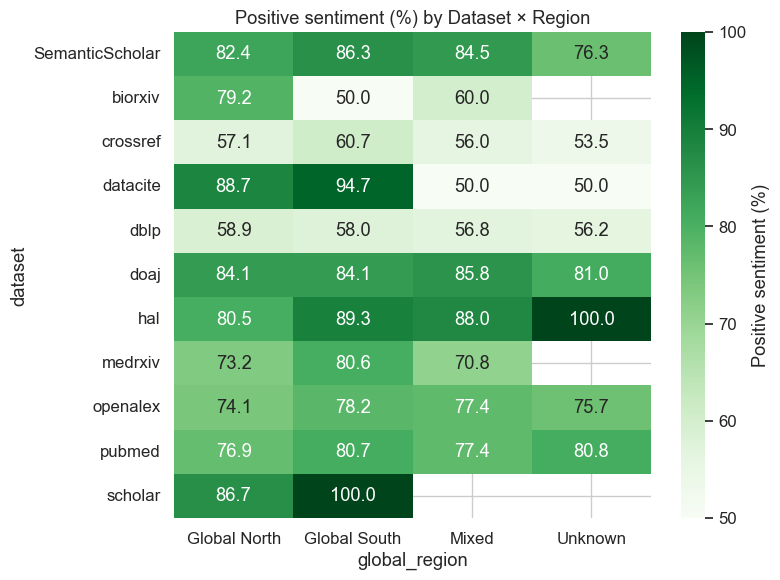

In [22]:
heat_reg = ds_reg.pivot(
    index="dataset",
    columns="global_region",
    values="positive_pct"
)

plt.figure(figsize=(8,6))
sns.heatmap(
    heat_reg,
    annot=True, fmt=".1f",
    cmap="Greens",
    cbar_kws={"label": "Positive sentiment (%)"}
)
plt.title("Positive sentiment (%) by Dataset × Region")
plt.tight_layout()

plt.savefig(FIGS / "fig5_heatmap_dataset_region.png", dpi=300)
plt.savefig(FIGS / "fig5_heatmap_dataset_region.svg")
plt.show()


In [24]:
tot = ds[["positive","neutral","negative"]].sum()

fig = go.Figure(
    go.Pie(
        labels=["Positive","Neutral","Negative"],
        values=tot.values,
        hole=0.5,
        marker_colors=[COLORS["positive"], COLORS["neutral"], COLORS["negative"]]
    )
)
fig.update_layout(
    title="Overall sentiment composition",
    showlegend=True
)

fig.write_html(FIGS / "fig7_overall_sentiment_donut.html")
fig.write_image(FIGS / "fig7_overall_sentiment_donut.svg")
fig.write_image(FIGS / "fig7_overall_sentiment_donut.png", scale=3)
fig.show()


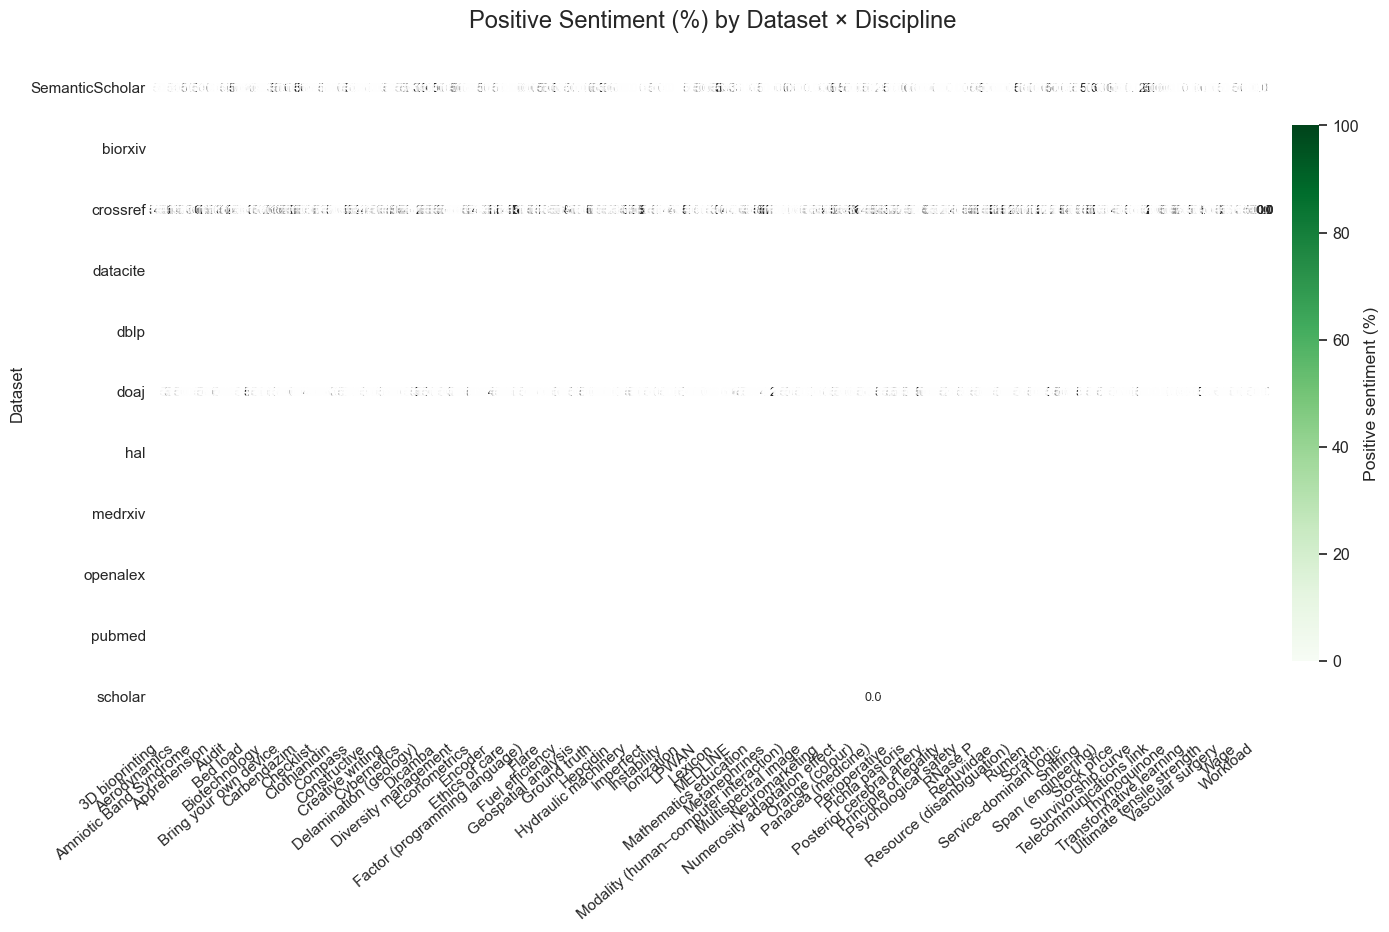

In [31]:
# ==============================
# FIXED Heatmap: Dataset × Discipline (no overlap)
# ==============================

heat_disc = ds_disc.pivot(
    index="dataset",
    columns="discipline_group",
    values="positive_pct"
)

plt.figure(figsize=(16, 10))  # wider & taller

ax = sns.heatmap(
    heat_disc,
    annot=True,
    fmt=".1f",
    cmap="Greens",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={
        "label": "Positive sentiment (%)",
        "shrink": 0.8,
        "pad": 0.02
    },
    annot_kws={"size": 9},   # ↓ smaller numbers
    square=False             # ✅ CRITICAL FIX
)

ax.set_title(
    "Positive Sentiment (%) by Dataset × Discipline",
    fontsize=17,
    pad=22
)

ax.set_xlabel("")
ax.set_ylabel("Dataset", fontsize=12)

plt.xticks(
    rotation=40,
    ha="right",
    fontsize=11
)
plt.yticks(fontsize=11)

# Extra margin so labels never touch edges
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

plt.savefig(FIGS / "fig6_heatmap_dataset_discipline.png", dpi=300)
plt.savefig(FIGS / "fig6_heatmap_dataset_discipline.svg")
plt.show()


# Tranasformer based model v2

# GStudio

In [13]:
import os
import glob
import json
import random
from typing import Optional, List, Dict

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import LinearSVC, SVR

# VADER
try:
    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
    _VADER_OK = True
except Exception:
    _VADER_OK = False

# Transformers
try:
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    _HF_OK = True
except Exception:
    _HF_OK = False


# =========================
# CONFIG
# =========================
CLEAN_DIR = r"E:\sentiment_AI\ai_research_productivity\data_processed\cleaned"
OUT_DIR = os.path.join(CLEAN_DIR, "_sentiment_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

LABELED_PATH = os.path.join(OUT_DIR, "labeling_sample.csv")  # will be created if missing

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

LABELS = ["NEG", "NEU", "POS"]
LABEL_TO_SCORE = {"NEG": -1.0, "NEU": 0.0, "POS": 1.0}

TEXT_CANDIDATES = ["clean_text", "text", "abstract", "title_abstract", "title", "summary", "description"]


def save_fig(path: str):
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()


def find_text_column(df: pd.DataFrame) -> Optional[str]:
    cols_l = [c.lower() for c in df.columns]
    for cand in TEXT_CANDIDATES:
        if cand in cols_l:
            return df.columns[cols_l.index(cand)]
    # fallback: longest average string column
    best_col, best_score = None, -1
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].astype(str).fillna("")
            score = s.str.len().mean()
            if score > best_score:
                best_score = score
                best_col = c
    return best_col


def load_all_cleaned(clean_dir: str) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(clean_dir, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {clean_dir}")

    all_parts = []
    for fp in files:
        try:
            df = pd.read_csv(fp, low_memory=False)
        except UnicodeDecodeError:
            df = pd.read_csv(fp, low_memory=False, encoding="utf-8", errors="ignore")

        ds_name = os.path.splitext(os.path.basename(fp))[0]
        tcol = find_text_column(df)
        if tcol is None:
            continue

        part = pd.DataFrame({
            "dataset": ds_name,
            "text_for_sentiment": df[tcol].astype(str).fillna("").str.strip()
        })
        part = part[part["text_for_sentiment"].str.len() > 0].copy()
        all_parts.append(part)

    if not all_parts:
        raise ValueError("No usable text found. None of the CSVs had a valid text column.")

    return pd.concat(all_parts, ignore_index=True)


def make_labeling_sample(df_all: pd.DataFrame, n_per_dataset: int = 250) -> str:
    samples = []
    for ds, sub in df_all.groupby("dataset"):
        sub_s = sub.sample(min(n_per_dataset, len(sub)), random_state=RANDOM_SEED)
        samples.append(sub_s)
    lab = pd.concat(samples, ignore_index=True)

    lab["label"] = ""   # user fills NEG/NEU/POS
    lab["notes"] = ""
    out_path = os.path.join(OUT_DIR, "labeling_sample.csv")
    lab.to_csv(out_path, index=False)
    return out_path


def load_labeled_if_exists(path: str) -> Optional[pd.DataFrame]:
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    if "label" not in df.columns or "text_for_sentiment" not in df.columns:
        return None
    df["label"] = df["label"].astype(str).str.strip().str.upper()
    df = df[df["label"].isin(LABELS)].copy()
    if len(df) < 200:
        return None
    df["score"] = df["label"].map(LABEL_TO_SCORE).astype(float)
    df["text_for_sentiment"] = df["text_for_sentiment"].astype(str).fillna("").str.strip()
    df = df[df["text_for_sentiment"].str.len() > 0].copy()
    return df


# =========================
# Baseline A: VADER (no labels needed)
# =========================
def vader_predict(df: pd.DataFrame) -> pd.DataFrame:
    if not _VADER_OK:
        raise RuntimeError("VADER not available. Install nltk and download vader_lexicon.")

    sia = SentimentIntensityAnalyzer()

    def to_label(compound: float) -> str:
        if compound >= 0.05:
            return "POS"
        if compound <= -0.05:
            return "NEG"
        return "NEU"

    preds = []
    scores = []
    for t in tqdm(df["text_for_sentiment"].tolist(), desc="VADER"):
        c = sia.polarity_scores(t)["compound"]
        preds.append(to_label(c))
        scores.append(c)

    out = df.copy()
    out["vader_label"] = preds
    out["vader_compound"] = scores
    return out


# =========================
# Baseline B: HF Transformers (no labels needed)
# =========================
HF_MODELS = [
    ("roberta_cardiffnlp", "cardiffnlp/twitter-roberta-base-sentiment-latest",
     {"LABEL_0": "NEG", "LABEL_1": "NEU", "LABEL_2": "POS"}),
    ("distilbert_sst2", "distilbert-base-uncased-finetuned-sst-2-english",
     {"NEGATIVE": "NEG", "POSITIVE": "POS", "LABEL_0": "NEG", "LABEL_1": "POS"}),
]


def hf_predict(df: pd.DataFrame, model_id: str, label_map: Dict[str, str],
               batch_size: int = 32, max_length: int = 256) -> List[str]:
    if not _HF_OK:
        raise RuntimeError("Transformers not available. Install torch + transformers.")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    tok = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
    model.eval()

    texts = df["text_for_sentiment"].tolist()
    preds = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc=f"HF:{model_id}"):
            batch = texts[i:i+batch_size]
            enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1)
            idx = probs.argmax(dim=-1).cpu().numpy()

            for j in idx:
                raw = model.config.id2label[int(j)]
                preds.append(label_map.get(raw, raw))

    # For 2-class models, keep NEU unused (fine)
    preds = [p if p in LABELS else ("NEU" if p not in ["NEG", "POS"] else p) for p in preds]
    return preds


# =========================
# Supervised ML (labels required)
# =========================
def train_supervised_models(lab: pd.DataFrame) -> Dict[str, Dict]:
    X = lab["text_for_sentiment"].tolist()
    y = lab["label"].tolist()
    ys = lab["score"].tolist()

    X_train, X_test, y_train, y_test, ys_train, ys_test = train_test_split(
        X, y, ys, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )

    vec = TfidfVectorizer(max_features=120000, ngram_range=(1, 2), min_df=2)
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)

    results = {}

    # Classification
    cls_models = {
        "tfidf_logreg": LogisticRegression(max_iter=4000, n_jobs=-1, class_weight="balanced"),
        "tfidf_linearSVC": LinearSVC(class_weight="balanced"),
    }

    for name, clf in cls_models.items():
        clf.fit(Xtr, y_train)
        pred = clf.predict(Xte)
        results[name] = {
            "accuracy": float(accuracy_score(y_test, pred)),
            "macro_f1": float(f1_score(y_test, pred, average="macro")),
            "cm": confusion_matrix(y_test, pred, labels=LABELS).tolist(),
            "report": classification_report(y_test, pred, digits=4),
        }

    # Regression -> classes
    reg_models = {
        "tfidf_ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
        "tfidf_svr_linear": SVR(C=2.0, epsilon=0.1, kernel="linear"),
    }

    ys_train = np.array(ys_train)
    for name, reg in reg_models.items():
        reg.fit(Xtr, ys_train)
        score_pred = reg.predict(Xte)
        pred = np.where(score_pred > 0.25, "POS", np.where(score_pred < -0.25, "NEG", "NEU"))
        results[name] = {
            "accuracy": float(accuracy_score(y_test, pred)),
            "macro_f1": float(f1_score(y_test, pred, average="macro")),
            "cm": confusion_matrix(y_test, pred, labels=LABELS).tolist(),
            "report": classification_report(y_test, pred, digits=4),
        }

    return results


def plot_distribution(df: pd.DataFrame, label_col: str, out_prefix: str):
    tab = df.groupby(["dataset", label_col]).size().unstack(fill_value=0)
    tab = tab.reindex(columns=[c for c in LABELS if c in tab.columns], fill_value=0)
    pct = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100
    pct = pct.sort_index()

    plt.figure(figsize=(10, max(4, 0.45 * len(pct))))
    y = np.arange(len(pct.index))
    left = np.zeros(len(pct.index))
    for lab in pct.columns:
        plt.barh(y, pct[lab].values, left=left, label=lab)
        left += pct[lab].values

    plt.yticks(y, pct.index)
    plt.xlim(0, 100)
    plt.xlabel("% of records")
    plt.title(f"Sentiment distribution by dataset ({label_col})")
    plt.legend(ncols=3, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", frameon=False)
    save_fig(os.path.join(OUT_DIR, f"{out_prefix}_sentiment_by_dataset.png"))


def main():
    print("Loading cleaned datasets...")
    df_all = load_all_cleaned(CLEAN_DIR)
    print(f"Usable rows: {len(df_all):,} | Datasets: {df_all['dataset'].nunique()}")

    # Ensure labeling sample exists
    if not os.path.exists(LABELED_PATH):
        p = make_labeling_sample(df_all, n_per_dataset=250)
        print(f"\nCreated labeling file (label NEG/NEU/POS then rerun for supervised results):\n{p}\n")
    else:
        print(f"Found labeling file: {LABELED_PATH}")

    # Unsupervised baselines (immediate)
    if _VADER_OK:
        df_v = vader_predict(df_all)
        df_v.to_csv(os.path.join(OUT_DIR, "pred_vader.csv"), index=False)
        plot_distribution(df_v, "vader_label", "vader")
        print("Saved VADER predictions + plots.")
    else:
        print("VADER skipped (install nltk + vader_lexicon).")

    if _HF_OK:
        for name, mid, lmap in HF_MODELS:
            preds = hf_predict(df_all, mid, lmap, batch_size=32, max_length=256)
            df_p = df_all.copy()
            df_p[f"{name}_label"] = preds
            df_p.to_csv(os.path.join(OUT_DIR, f"pred_{name}.csv"), index=False)
            plot_distribution(df_p, f"{name}_label", name)
            print(f"Saved {name} predictions + plots.")
    else:
        print("Transformers skipped (install torch + transformers).")

    # Supervised models (only if you labeled enough rows)
    lab = load_labeled_if_exists(LABELED_PATH)
    if lab is None:
        print("\nSupervised ML/DL skipped: labeling_sample.csv missing labels or has <200 labeled rows.")
        print("Label the file (NEG/NEU/POS) and rerun to get accuracy/macro-F1 comparisons.")
        return

    res = train_supervised_models(lab)
    out_json = os.path.join(OUT_DIR, "supervised_results.json")
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(res, f, indent=2)

    print(f"\nSaved supervised results: {out_json}")
    for k, v in res.items():
        print("\n" + "=" * 80)
        print(k)
        print(f"Accuracy: {v['accuracy']:.4f} | Macro-F1: {v['macro_f1']:.4f}")
        print(v["report"])

    print(f"\nAll outputs: {OUT_DIR}")


if __name__ == "__main__":
    main()


Loading cleaned datasets...
Usable rows: 78,317 | Datasets: 11

Created labeling file (label NEG/NEU/POS then rerun for supervised results):
E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs\labeling_sample.csv



VADER: 100%|██████████| 78317/78317 [01:02<00:00, 1262.53it/s] 


Saved VADER predictions + plots.


ModuleNotFoundError: Could not import module 'RobertaForSequenceClassification'. Are this object's requirements defined correctly?

In [18]:
CLEAN_DIR = r"E:\sentiment_AI\ai_research_productivity\data_processed\cleaned"
OUT_DIR = r"E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs"


In [19]:
import os
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)


OUT_DIR: E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs


In [20]:
import glob, os
files = sorted(glob.glob(os.path.join(CLEAN_DIR, "*.csv")))
print("CSV files:", len(files))
for f in files[:20]:
    print(os.path.basename(f))


CSV files: 11
biorxiv_raw_standard_format_clean.csv
crossref_raw_openalex_format_clean.csv
datacite_raw_clean.csv
dblp_raw_standard_format_clean.csv
doaj_raw_openalex_format_clean.csv
hal_raw_standard_format_clean.csv
medrxiv_raw_standard_format_clean.csv
openalex_raw_clean.csv
pubmed_raw_openalex_format_clean.csv
scholar_openalex_format_clean.csv
semantic_scholar_raw_openalex_format_clean.csv


In [21]:
import pandas as pd
import numpy as np

TEXT_CANDIDATES = ["clean_text", "text", "abstract", "title_abstract", "title", "summary", "description"]

def find_text_column(df: pd.DataFrame):
    cols_l = [c.lower() for c in df.columns]
    for cand in TEXT_CANDIDATES:
        if cand in cols_l:
            return df.columns[cols_l.index(cand)]
    # fallback: longest average string column
    best_col, best_score = None, -1
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].astype(str).fillna("")
            score = s.str.len().mean()
            if score > best_score:
                best_score = score
                best_col = c
    return best_col

def load_all_cleaned(clean_dir: str) -> pd.DataFrame:
    import glob, os
    files = sorted(glob.glob(os.path.join(clean_dir, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files in: {clean_dir}")

    parts = []
    for fp in files:
        try:
            df = pd.read_csv(fp, low_memory=False)
        except UnicodeDecodeError:
            df = pd.read_csv(fp, low_memory=False, encoding="utf-8", errors="ignore")

        tcol = find_text_column(df)
        if tcol is None:
            print("Skip (no text col):", os.path.basename(fp))
            continue

        ds = os.path.splitext(os.path.basename(fp))[0]
        part = pd.DataFrame({
            "dataset": ds,
            "text": df[tcol].astype(str).fillna("").str.strip()
        })
        part = part[part["text"].str.len() > 0].copy()
        parts.append(part)

    if not parts:
        raise ValueError("No usable text found in any file.")
    return pd.concat(parts, ignore_index=True)

df_all = load_all_cleaned(CLEAN_DIR)
print(df_all.shape)
df_all.head()


(78317, 2)


dataset  \
0  biorxiv_raw_standard_format_clean   
1  biorxiv_raw_standard_format_clean   
2  biorxiv_raw_standard_format_clean   
3  biorxiv_raw_standard_format_clean   
4  biorxiv_raw_standard_format_clean   

                                                text  
0  The U.S. National Toxicology Program (NTP) has...  
1  LONG ABSTRACTHuman perceptual decisions are of...  
2  Perceptual experience results from a complex i...  
3  Perception can be characterized as an inferenc...  
4  Cortical entrainment of the auditory cortex to...

In [23]:
unified_path = os.path.join(OUT_DIR, "unified_text.csv")
df_all.to_csv(unified_path, index=False)
print("Saved:", unified_path)


Saved: E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs\unified_text.csv


In [24]:
import pandas as pd
import numpy as np

def make_labeling_sample(df_all: pd.DataFrame, n_per_dataset=250):
    samples = []
    for ds, sub in df_all.groupby("dataset"):
        sub_s = sub.sample(min(n_per_dataset, len(sub)), random_state=42)
        samples.append(sub_s)
    lab = pd.concat(samples, ignore_index=True)
    lab["label"] = ""   # fill NEG / NEU / POS
    lab["notes"] = ""
    out_path = os.path.join(OUT_DIR, "labeling_sample.csv")
    lab.to_csv(out_path, index=False)
    return out_path

label_path = make_labeling_sample(df_all, n_per_dataset=250)
print("Label this file then continue:", label_path)


Label this file then continue: E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs\labeling_sample.csv


In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

def vader_label(compound: float):
    if compound >= 0.05:
        return "POS"
    if compound <= -0.05:
        return "NEG"
    return "NEU"

vader_scores = []
vader_preds = []

for t in tqdm(df_all["text"].tolist(), desc="VADER"):
    c = sia.polarity_scores(t)["compound"]
    vader_scores.append(c)
    vader_preds.append(vader_label(c))

df_vader = df_all.copy()
df_vader["vader_compound"] = vader_scores
df_vader["vader_label"] = vader_preds

out_csv = os.path.join(OUT_DIR, "pred_vader.csv")
df_vader.to_csv(out_csv, index=False)
print("Saved:", out_csv)


VADER: 100%|██████████| 78317/78317 [00:52<00:00, 1487.52it/s] 


Saved: E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs\pred_vader.csv


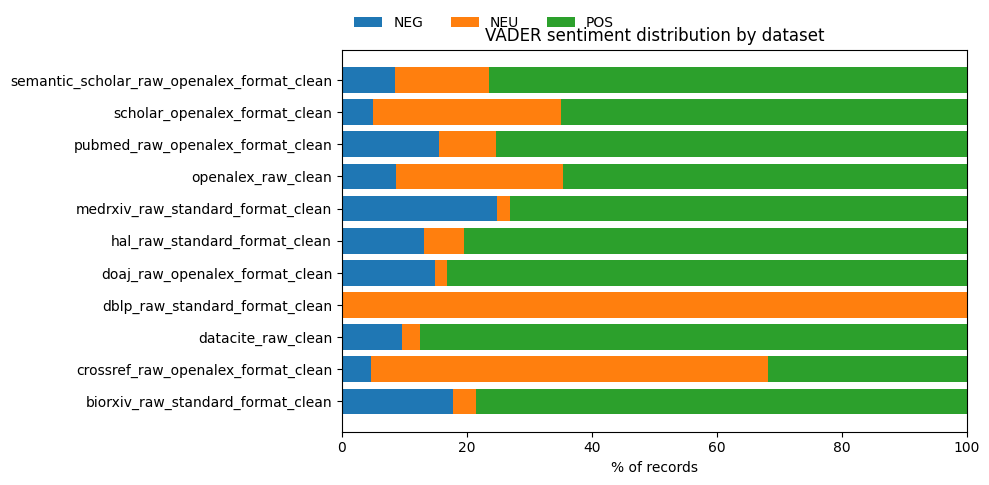

In [30]:
import matplotlib.pyplot as plt
import numpy as np

tab = df_vader.groupby(["dataset", "vader_label"]).size().unstack(fill_value=0)
tab = tab.reindex(columns=["NEG","NEU","POS"], fill_value=0)
pct = tab.div(tab.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, max(4, 0.45*len(pct))))
y = np.arange(len(pct.index))
left = np.zeros(len(pct.index))
for lab in ["NEG","NEU","POS"]:
    plt.barh(y, pct[lab].values, left=left, label=lab)
    left += pct[lab].values
plt.yticks(y, pct.index)
plt.xlim(0, 100)
plt.xlabel("% of records")
plt.title("VADER sentiment distribution by dataset")
plt.legend(ncols=3, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "vader_sentiment_by_dataset.png"), dpi=300, bbox_inches="tight")
plt.show()


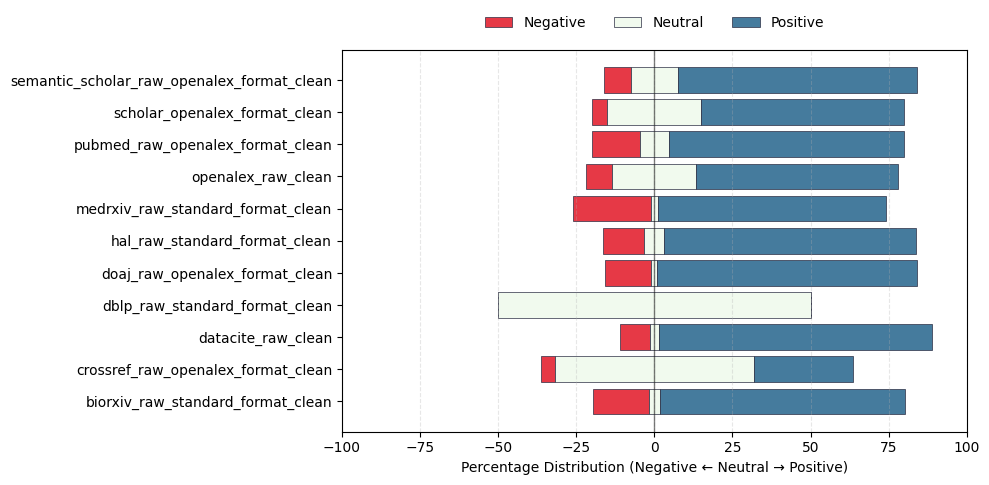

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare the data (assuming pct is already calculated as in your snippet)
# We calculate the starting point for the bars so they "diverge" from the center of NEU
starts = -(pct['NEG'] + (pct['NEU'] / 2))

plt.figure(figsize=(10, max(4, 0.45 * len(pct))))
y = np.arange(len(pct.index))

# 2. Define colors for a professional look
colors = {"NEG": "#e63946", "NEU": "#f1faee", "POS": "#457b9d"}
edge_color = "#2b2d42"

# 3. Plot each segment
# Negative segment
plt.barh(y, pct['NEG'], left=starts, color=colors['NEG'], 
         label='Negative', edgecolor=edge_color, linewidth=0.5)

# Neutral segment (centered on 0)
plt.barh(y, pct['NEU'], left=starts + pct['NEG'], color=colors['NEU'], 
         label='Neutral', edgecolor=edge_color, linewidth=0.5)

# Positive segment
plt.barh(y, pct['POS'], left=starts + pct['NEG'] + pct['NEU'], color=colors['POS'], 
         label='Positive', edgecolor=edge_color, linewidth=0.5)

# 4. Aesthetic refinements
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5) # Zero line
plt.yticks(y, pct.index)
plt.xlabel("Percentage Distribution (Negative ← Neutral → Positive)")
#plt.title("Diverging VADER Sentiment Analysis", pad=20, fontsize=14)

# Set x-limits to be symmetrical
max_range = np.max(np.abs(starts)) + 100 # Ensure all bars fit
plt.xlim(-100, 100) 

plt.legend(ncols=3, bbox_to_anchor=(0.5, 1.02), loc="lower center", frameon=False)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save and show
# plt.savefig(os.path.join(OUT_DIR, "diverging_vader_sentiment.png"), dpi=300, bbox_inches="tight")
plt.show()

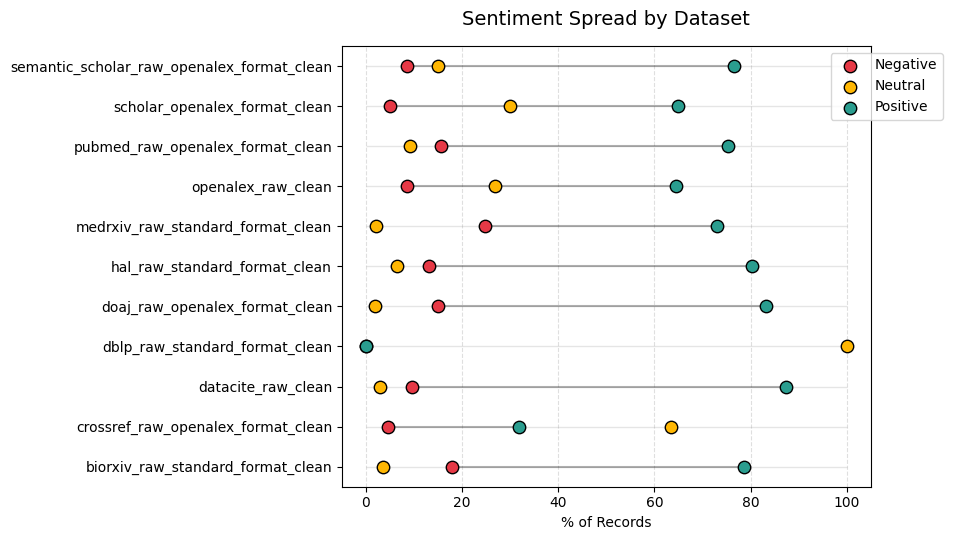

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pct' is your DataFrame from the previous step
plt.figure(figsize=(10, max(4, 0.5 * len(pct))))
y = np.arange(len(pct.index))

# 1. Draw the background lines (the "stalks")
plt.hlines(y, xmin=0, xmax=100, color='grey', alpha=0.2, linewidth=1)

# 2. Plot the individual sentiment points
# We use different markers and colors to distinguish the sentiments
plt.scatter(pct['NEG'], y, color='#e63946', label='Negative', s=80, edgecolors='black', zorder=3)
plt.scatter(pct['NEU'], y, color='#ffb703', label='Neutral', s=80, edgecolors='black', zorder=3)
plt.scatter(pct['POS'], y, color='#2a9d8f', label='Positive', s=80, edgecolors='black', zorder=3)

# 3. Add connecting lines between NEG and POS to show the "span"
plt.hlines(y, xmin=pct['NEG'], xmax=pct['POS'], color='black', alpha=0.3, zorder=2)

# 4. Final touches
plt.yticks(y, pct.index)
plt.xlim(-5, 105) # Padding for the dots
plt.xlabel("% of Records")
plt.title("Sentiment Spread by Dataset", fontsize=14, pad=15)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

In [51]:
# Install once:
# pip install nltk tqdm
# python -c "import nltk; nltk.download('vader_lexicon')"

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

def vader_to_label(comp):
    if comp >= 0.05: return "POS"
    if comp <= -0.05: return "NEG"
    return "NEU"

scores, labels = [], []
for t in tqdm(df_all["text"].tolist(), desc="VADER pseudo-labels"):
    c = sia.polarity_scores(t)["compound"]
    scores.append(c)
    labels.append(vader_to_label(c))

df_pseudo = df_all.copy()
df_pseudo["pseudo_score"] = scores
df_pseudo["pseudo_label"] = labels

pseudo_path = os.path.join(OUT_DIR, "pseudo_labels_vader.csv")
df_pseudo.to_csv(pseudo_path, index=False)
print("Saved:", pseudo_path)
df_pseudo["pseudo_label"].value_counts()


VADER pseudo-labels: 100%|██████████| 78317/78317 [01:02<00:00, 1256.91it/s] 


Saved: E:\sentiment_AI\ai_research_productivity\data_processed\cleaned\_sentiment_outputs\pseudo_labels_vader.csv


pseudo_label
POS    47477
NEU    23492
NEG     7348
Name: count, dtype: int64

In [52]:
# pip install torch

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

LABELS = ["NEG","NEU","POS"]
lab2id = {l:i for i,l in enumerate(LABELS)}
id2lab = {i:l for l,i in lab2id.items()}

# sample down if huge (optional)
df_train = df_pseudo.sample(min(200000, len(df_pseudo)), random_state=42).copy()

train_df, val_df = train_test_split(
    df_train, test_size=0.1, random_state=42, stratify=df_train["pseudo_label"]
)

# simple word tokenizer
import re
def tokenize(s):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", s.lower())

# build vocab from train
from collections import Counter
cnt = Counter()
for t in tqdm(train_df["text"].tolist(), desc="Build vocab"):
    cnt.update(tokenize(t))

MAX_VOCAB = 50000
vocab = {"<pad>":0, "<unk>":1}
for w,_ in cnt.most_common(MAX_VOCAB-2):
    vocab[w] = len(vocab)

def encode(text, max_len=200):
    toks = tokenize(text)[:max_len]
    ids = [vocab.get(w, vocab["<unk>"]) for w in toks]
    if len(ids) < max_len:
        ids += [vocab["<pad>"]] * (max_len - len(ids))
    return ids

MAX_LEN = 200

class TextDS(Dataset):
    def __init__(self, df):
        self.texts = df["text"].astype(str).tolist()
        self.y = [lab2id[x] for x in df["pseudo_label"].tolist()]
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        x = torch.tensor(encode(self.texts[i], MAX_LEN), dtype=torch.long)
        y = torch.tensor(self.y[i], dtype=torch.long)
        return x, y

train_loader = DataLoader(TextDS(train_df), batch_size=256, shuffle=True, num_workers=0)
val_loader   = DataLoader(TextDS(val_df), batch_size=256, shuffle=False, num_workers=0)

print("Train:", len(train_df), "Val:", len(val_df), "Vocab:", len(vocab))


Build vocab: 100%|██████████| 70485/70485 [00:02<00:00, 28984.86it/s]

Train: 70485 Val: 7832 Vocab: 50000


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid=128, nclass=3, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hid, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hid*2, nclass)
        self.drop = nn.Dropout(0.3)
    def forward(self, x):
        e = self.drop(self.emb(x))
        out, _ = self.lstm(e)
        pooled = out.mean(dim=1)
        return self.fc(self.drop(pooled))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BiLSTMClassifier(len(vocab)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(device), y.to(device)
        if train:
            opt.zero_grad()
        logits = model(x)
        loss = crit(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total_loss += float(loss.item()) * len(y)
        pred = logits.argmax(dim=1)
        correct += int((pred == y).sum().item())
        total += len(y)
    return total_loss/total, correct/total

best_acc = 0
for epoch in range(1, 6):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch}: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"model": model.state_dict(), "vocab": vocab}, os.path.join(OUT_DIR, "bilstm_pseudo_best.pt"))
        print("Saved best model.")


 72%|███████▏  | 198/276 [00:53<00:20,  3.84it/s]

In [ ]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nclass=3, pad_idx=0, kernels=(3,4,5), channels=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv1d(emb_dim, channels, k) for k in kernels
        ])
        self.fc = nn.Linear(channels*len(kernels), nclass)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        e = self.emb(x).transpose(1,2)  # [B, E, T]
        feats = []
        for conv in self.convs:
            h = F.relu(conv(e))
            feats.append(F.max_pool1d(h, kernel_size=h.size(2)).squeeze(2))
        z = torch.cat(feats, dim=1)
        z = self.drop(z)
        return self.fc(z)

cnn = CNNTextClassifier(len(vocab)).to(device)
opt = torch.optim.AdamW(cnn.parameters(), lr=2e-3)
crit = nn.CrossEntropyLoss()

def run_epoch_cnn(loader, train=True):
    cnn.train(train)
    total_loss, correct, total = 0.0, 0, 0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(device), y.to(device)
        if train:
            opt.zero_grad()
        logits = cnn(x)
        loss = crit(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(cnn.parameters(), 1.0)
            opt.step()
        total_loss += float(loss.item()) * len(y)
        pred = logits.argmax(dim=1)
        correct += int((pred == y).sum().item())
        total += len(y)
    return total_loss/total, correct/total

best_acc = 0
for epoch in range(1, 6):
    tr_loss, tr_acc = run_epoch_cnn(train_loader, train=True)
    va_loss, va_acc = run_epoch_cnn(val_loader, train=False)
    print(f"Epoch {epoch}: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"model": cnn.state_dict(), "vocab": vocab}, os.path.join(OUT_DIR, "cnn_pseudo_best.pt"))
        print("Saved best CNN model.")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tab = df_pseudo.groupby(["dataset","pseudo_label"]).size().unstack(fill_value=0)
tab = tab.reindex(columns=["NEG","NEU","POS"], fill_value=0)
pct = tab.div(tab.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)*100

plt.figure(figsize=(10, max(5, 0.45*len(pct))))
y = np.arange(len(pct.index))
left = np.zeros(len(pct.index))
for lab in ["NEG","NEU","POS"]:
    plt.barh(y, pct[lab].values, left=left, label=lab)
    left += pct[lab].values
plt.yticks(y, pct.index)
plt.xlim(0,100)
plt.xlabel("% of records")
plt.title("Pseudo-sentiment distribution by dataset (VADER)")
plt.legend(ncols=3, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pseudo_sentiment_by_dataset_vader.png"), dpi=300, bbox_inches="tight")
plt.show()
